In [1]:
import ROOT
from ROOT import TFile
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import pandas as pd 
import time
import uproot
import uproot3
import R2h_module as r2h
import root_pandas as rpd
from root_pandas import read_root
from matplotlib import rc
import seaborn as sns
import cupy as cp, math, pylab
import os, os.path
mpl.rcParams.update({'font.size': 18})
mpl.rcParams.update({'legend.fontsize': 20})
mpl.rcParams.update({'xtick.labelsize': 13}) 
mpl.rcParams.update({'ytick.labelsize': 13}) 
mpl.rcParams.update({'text.usetex' : False})
rc('font', weight='bold')
colors = {}
colors['C'] = '#1f77b4'
colors['Fe'] = '#ff7f0e'
colors['Pb']=  '#2ca02c'


plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

Welcome to JupyROOT 6.27/01


/home/sebouh/.local/lib/python3.8/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/home/sebouh/.local/lib/python3.8/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


**Definition of some constants**

In [2]:
# defining the edges and number of bins for each variable.
dpionMassBins=11
maxzmass=1.7
minzmass=0.3

dpiondphiBins=9
maxdphi=3.14
mindphi=0.0

dpionz2Bins=9
maxz2=0.45
minz2=0.05

## systematic errors for the 3 different variables
#sysErr_z2   = np.array([3.32080926,2.756116784,2.562141684,2.909661135,3.212331314,3.872142459,5.208199077,5.151592545])
#sysErr_dphi = np.array([3.829435252,3.354814974,2.230653814,1.943792247,2.008438408,2.288362377,2.915745401,4.527098216 ])
#sysErr_mass = np.array([2.879452899,2.879452899,2.879452899,2.879452899,2.879452899,3.041586593,3.245188592,3.482994258,3.748499566,4.03624194 ])

sysErr_z2 = {}
sysErr_z2['C'] = np.array([3.692202419,
    3.212142566,
    2.570701518,
    2.596996206,
    2.673649758,
    2.912079542,
    3.608299589,
    4.204192233])
sysErr_z2['Fe'] =sysErr_z2['C']
sysErr_z2['Pb'] = sysErr_z2['C']

sysErr_dphi = {}
sysErr_dphi['C'] =np.array([4.25648903,3.156250443,2.614883064,2.523107341,
                             2.533560227,2.547747002,2.62759471,3.001707032])
sysErr_dphi['Fe'] = sysErr_dphi['C']
sysErr_dphi['Pb'] = sysErr_z2['C']

sysErr_mass = {}
sysErr_mass['C'] = np.array([3.409193127,
    4.79263029,
    2.541211342,
    2.610459367,
    2.727169307,
    2.746379935,
    3.119634527,
    3.874351389,
    4.828794128,
    6.764388662])
sysErr_mass['Fe'] = sysErr_mass['C']
sysErr_mass['Pb'] = np.array([3.587840267,
    4.79263029,
    2.541211342,
    2.610459367,
    2.727169307,
    2.746379935,
    3.119634527,
    3.874351389,
    5.684826535,
    8.588186885])


#outdir='/home/seba/di-hadron/resultsPlots_images/'
outdir='/home/sebouh/di-hadron/images/'
outdir_sys='~/di-hadron/systematicsPlots_images/'
outdir_app='~/di-hadron/appendixPlots_images/'
outdir_intro='~/di-hadron/introPlots_images/'
outdir_vertex='~/di-hadron/vertexDeterminationPlots_images/'

# Get data from Ntuples to dataframes

In [3]:
def getdatainChunks(filename,treename):
    dataframe =pd.DataFrame()
    file = uproot.open(filename) 
    tree=file[treename]
    df=tree.arrays(filter_name='*',library='pd')
    return df

# Getting Data

In [4]:
%%time
df = {}
df_trigger = {}
#path_data="/home/sebouh/di-hadron"
path_data="/home/seba/di-hadron/P27"
for target in ['C','Fe','Pb']:
    print ('Getting dataframes from target %s'%target)
    df[target]=getdatainChunks('%s/Pairs_%s.root'%(path_data,target), target)
    df['D_%s'%target]= getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 'D_%s'%target)  
    print ('Get trigger dataframes from deuterium target %s'%target)
    df_trigger['%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                      '%s_trigger'%target)
    df_trigger['D_%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                        'D_%s_trigger'%target)

Getting dataframes from target C
Get trigger dataframes from deuterium target C
Getting dataframes from target Fe
Get trigger dataframes from deuterium target Fe
Getting dataframes from target Pb
Get trigger dataframes from deuterium target Pb
CPU times: user 4.46 s, sys: 125 ms, total: 4.58 s
Wall time: 4.83 s


In [5]:
print(df['C'].columns)

Index(['dphi', 'dphi_lab', 'drap', 'h1_z', 'h2_z', 'h1_cm_pt', 'h2_cm_pt',
       'h1_xf', 'h2_xf', 'h1_rap', 'ycm', 'h2_rap', 'h1_pid', 'h2_pid',
       'h1_cm_ph', 'h2_cm_ph', 'h1_cm_th', 'h2_cm_th', 'pair_mass', 'pair_pt',
       'mx_eh1h2x', 'mx_eh1x', 'mx_eh2x', 't', 'Q2', 'nu', 'W', 'SampFracEl25',
       'SampFracEl20', 'TargTypeSM', 'TargType', 'x', 'u', 'h1_ph', 'h1_th',
       'h2_ph', 'h2_th', 'h1_deltaZ', 'h2_deltaZ', 'h1_Nphe', 'h2_Nphe',
       'h1_Sector', 'h2_Sector', 'h1_FidCut', 'h2_FidCut', 'h1_Chi2CC',
       'h2_Chi2CC', 'h1_StatCC', 'h2_StatCC', 'evnt'],
      dtype='object')


In [6]:
#df['C'].hist(figsize=(12,12),bins=100,column=['nu','t','Q2','h2_pid', 'h1_pid','h1_xf', 'h2_xf'])
#plt.show()

In [7]:
root_file = rpd.read_root('/home/seba/di-hadron/data/ca/N_clas_42115_15.pass2.root', 'ntuple_data') 
root_file.columns

Index(['Q2', 'Nu', 'Xb', 'vxe', 'vye', 'vze', 'SectorEl', 'TargType', 'Pex',
       'Pey', 'Pez', 'Pe', 'vyec', 'vzec', 'NpheEl', 'FidCheckCutEl',
       'TargTypeSM', 'TargTypeHH', 'CCMirrorMatchingEl', 'SampFractionEl25',
       'SampFractionEl20', 'W', 'Zh', 'Pt2', 'PhiPQ', 'ThetaLab', 'vxh', 'vyh',
       'vzh', 'Sector', 'Px', 'Py', 'Pz', 'P', 'Betta', 'pid', 'T4', 'deltaZ',
       'Nphe', 'evnt', 'FidCheckCutPiPlus', 'StatCC', 'Chi2CC', 'NRowsCC',
       'FidCheckCut', 'SampFraction25', 'SampFraction20', 'CCMirrorMatching',
       'Eh', 'ThetaPQ', 'PhiLab'],
      dtype='object')

# Getting MC (reco)

In [8]:
%%time
df_mc = {}
df_mc_trigger = {}
path_mc="/home/seba/CreatePairTuples"
#path_mc="/home/sebouh/di-hadron/simul/Pairs"
for target in ['C','D', 'Fe','Pb']:
#for target in ['C','D']:
    print ('Getting dataframes from target %s'%target)
    df_mc[target]=getdatainChunks('%s/MC_Pairs_%s.root'%(path_mc,target), target)
    df_mc_trigger['%s_trigger'%target] = getdatainChunks('%s/MC_Pairs_%s.root'%(path_mc,target), 
                                                         '%s_trigger'%target)

Getting dataframes from target C
Getting dataframes from target D
Getting dataframes from target Fe
Getting dataframes from target Pb
CPU times: user 29.6 s, sys: 1.01 s, total: 30.6 s
Wall time: 30.6 s


In [9]:
print(df['C'].keys())
#df_mc['C'].hist(figsize=(12,12),bins=100,column=['nu','W','Q2','h2_pid', 'h1_pid','h1_th', 'h2_th'])


Index(['dphi', 'dphi_lab', 'drap', 'h1_z', 'h2_z', 'h1_cm_pt', 'h2_cm_pt',
       'h1_xf', 'h2_xf', 'h1_rap', 'ycm', 'h2_rap', 'h1_pid', 'h2_pid',
       'h1_cm_ph', 'h2_cm_ph', 'h1_cm_th', 'h2_cm_th', 'pair_mass', 'pair_pt',
       'mx_eh1h2x', 'mx_eh1x', 'mx_eh2x', 't', 'Q2', 'nu', 'W', 'SampFracEl25',
       'SampFracEl20', 'TargTypeSM', 'TargType', 'x', 'u', 'h1_ph', 'h1_th',
       'h2_ph', 'h2_th', 'h1_deltaZ', 'h2_deltaZ', 'h1_Nphe', 'h2_Nphe',
       'h1_Sector', 'h2_Sector', 'h1_FidCut', 'h2_FidCut', 'h1_Chi2CC',
       'h2_Chi2CC', 'h1_StatCC', 'h2_StatCC', 'evnt'],
      dtype='object')


# Getting GiBUU

In [10]:
%%time

pathGIBUU="/home/miguel/eg2dihadron/"
for target in ['D','C','Fe','Pb']:
    #GiBUU
    print (target)
    print (' trigger')
    df_trigger['GiBUU_%s_trigger'%target]= getdatainChunks('%sGiBUU_Pairs_%s.root'%(pathGIBUU,target), 
                                                           '%s_trigger'%target)
    print (' pairs')
    df['GiBUU_%s'%target]= getdatainChunks('%sGiBUU_Pairs_%s.root'%(pathGIBUU,target), target)
print (df_trigger.keys())

D
 trigger
 pairs
C
 trigger
 pairs
Fe
 trigger
 pairs
Pb
 trigger
 pairs
dict_keys(['C_trigger', 'D_C_trigger', 'Fe_trigger', 'D_Fe_trigger', 'Pb_trigger', 'D_Pb_trigger', 'GiBUU_D_trigger', 'GiBUU_C_trigger', 'GiBUU_Fe_trigger', 'GiBUU_Pb_trigger'])
CPU times: user 15.1 s, sys: 816 ms, total: 15.9 s
Wall time: 15.9 s


In [11]:
print (df_trigger['GiBUU_C_trigger'].keys())
print (df_trigger['GiBUU_C_trigger'].shape[0])
#df['GiBUU_Fe'].eval('Xb=Q2/(2*0.938272*nu)', inplace=True)
#df['GiBUU_Fe'].hist(figsize=(12,12),bins=100,column=['Xb','nu','W','Q2','h2_pid', 'h1_pid','h1_z', 'h2_th'])
#plt.show()

Index(['h1_pid', 'h1_xf', 'h1_z', 'h1_rap', 'ycm', 'h1_pt', 'Q2', 'x', 'nu',
       'W', 'h1_cm_ph', 'h1_cm_th', 'mass', 'pstar', 'plstar', 'eta',
       'TargType', 'h1_ph', 'h1_th', 'pos_x', 'pos_y', 'pos_z', '__index__'],
      dtype='object')
2011729


# Combine the D2 data-sets

In [12]:
#df['D'] = df['D_Fe']
#df_trigger['D_trigger'] = df_trigger['D_Fe_trigger']
 #df['D'] = pd.concat([df['D_Fe']) #simply combine the deuterium results for all targets
#df_trigger['D_trigger'] = pd.concat([df_trigger['D_Fe_trigger']]) #simply combine the deuterium results for all targets

#print (df.keys())
#print(df['Fe'].keys())
#print(df_trigger['Fe_trigger'].keys())
## this is just to notice that there are no vectors in the variables, all of them are numbers
#print(df['Fe'].describe())
#print('there are ',len(df['Fe']), 'entries')

watching some distributions

In [13]:
#df['Fe'].hist(figsize=(12,12),bins=100,column=['dphi','dphi_lab','h2_cm_th','h2_pid'])
#plt.show()

# Apply selection to datasets
**Here are applied the cuts for GiBUU**

In [14]:
%%time
for key in df.keys():
    isMC = False
    if 'GiBUU' in key:
        isMC=True
    print ('\nkey: ',key)
    df[key].rename(columns={'h1_FidCut':'h1_FidCutPiPlus'}, inplace=True)
    df[key].rename(columns={'h2_FidCut':'h2_FidCutPiPlus'}, inplace=True)
    df[key] = r2h.applyCuts(df[key],isMC=isMC, nomCuts=True)
    df[key] = r2h.applyCutsPair(df[key],isMC=isMC, nomCuts=True)


key:  C
Entries before cut  131591
Q2>1.0 and Q2<4.0 131591  (100.00  %)
0.2<h1_p<5.0  131585  (100.00  %)
inelasticity < 0.85 131585  (100.00  %)
h1_pid = pions (trigger) 131585  (100.00  %)
2.2 < nu <4.2 129258  (98.23  %)
25 degree separation between pion and electron.  This is a dumb cut 129258  (100.00  %)
10< h1_th 129258  (100.00  %)
Theta/P fiducial region selected for trigger hadron 129258  (100.00  %)
Nom cuts for the trigger applied 44785  (34.65  %)
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 44785  (100.00  %)
2.2 < nu < 4.2 44785  (100.00  %)
secondary hadrons are pions 44785  (100.00  %)
(h1_pid*h2_pid)<0, opposite charge pions 35717  (79.75  %)
kinematic limits for h2_z 35636  (99.77  %)
kinematic limits for dphi 35596  (99.89  %)
kinematic limits for pair_mass 35415  (99.49  %)
leading hadrons are pions 35415  (100.00  %)
0.2<h2_p<5.0 35415  (100.00  %)
0.2<h1_p<5.0 35415  (100.00  %)
25 degree separation between pion and electron.  This is a dumb 

0.2<h2_p<5.0 998503  (90.58  %)
0.2<h1_p<5.0 998503  (100.00  %)

key:  GiBUU_C
Entries before cut  2226123
Q2>1.0 and Q2<4.0 2225228  (99.96  %)
0.2<h1_p<5.0  2225228  (100.00  %)
inelasticity < 0.85 2225228  (100.00  %)
h1_pid = pions (trigger) 2225228  (100.00  %)
2.2 < nu <4.2 2125385  (95.51  %)
Starting election on dipion variables
This is MC
1.0< Q2 <4.0 2125385  (100.00  %)
2.2 < nu < 4.2 2125385  (100.00  %)
secondary hadrons are pions 1198467  (56.39  %)
(h1_pid*h2_pid)<0, opposite charge pions 1091014  (91.03  %)
kinematic limits for h2_z 1035451  (94.91  %)
kinematic limits for dphi 1034440  (99.90  %)
kinematic limits for pair_mass 1026890  (99.27  %)
leading hadrons are pions 1026890  (100.00  %)
0.2<h2_p<5.0 888419  (86.52  %)
0.2<h1_p<5.0 888419  (100.00  %)

key:  GiBUU_Fe
Entries before cut  1014645
Q2>1.0 and Q2<4.0 1014170  (99.95  %)
0.2<h1_p<5.0  1014170  (100.00  %)
inelasticity < 0.85 1014170  (100.00  %)
h1_pid = pions (trigger) 1014170  (100.00  %)
2.2 < nu <4

In [ ]:
for key in df_trigger.keys():
    isMC = False
    if 'GiBUU' in key:
        isMC=True    
    print (key, isMC)
    df_trigger[key].rename(columns={'h1_FidCut':'h1_FidCutPiPlus'}, inplace=True)
    df_trigger[key] = r2h.applyCuts(df_trigger[key],isTrigger=True, isMC=isMC, nomCuts=True)
    print (' ')
    
    

C_trigger False
Entries before cut  652690
Q2>1.0 and Q2<4.0 652690  (100.00  %)
0.2<h1_p<5.0  652674  (100.00  %)
inelasticity < 0.85 652674  (100.00  %)
h1_pid = pions (trigger) 652674  (100.00  %)
2.2 < nu <4.2 642836  (98.49  %)
25 degree separation between pion and electron.  This is a dumb cut 642836  (100.00  %)
10< h1_th 642836  (100.00  %)
Theta/P fiducial region selected for trigger hadron 642836  (100.00  %)
Nom cuts for the trigger applied 291788  (45.39  %)
 
D_C_trigger False
Entries before cut  875478
Q2>1.0 and Q2<4.0 875478  (100.00  %)
0.2<h1_p<5.0  875467  (100.00  %)
inelasticity < 0.85 875467  (100.00  %)
h1_pid = pions (trigger) 875467  (100.00  %)
2.2 < nu <4.2 863117  (98.59  %)
25 degree separation between pion and electron.  This is a dumb cut 863117  (100.00  %)
10< h1_th 863117  (100.00  %)
Theta/P fiducial region selected for trigger hadron 863117  (100.00  %)
Nom cuts for the trigger applied 405810  (47.02  %)
 
Fe_trigger False
Entries before cut  370123


# Apply selection to MC

In [ ]:
%%time
for key in df_mc.keys():
    isMC = False
    if 'GiBUU' in key:
        isMC=True
    print (key)
    print('trigger cuts:\n')
    df_mc[key] = r2h.applyCuts(df_mc[key],isMC=isMC)
    print('pair cuts:\n')
    df_mc[key] = r2h.applyCutsPair(df_mc[key],isMC=isMC)    
    #df_mc[key] = r2h.applyCuts(df_mc[key],isMC=isMC)
    #df_mc[key] = r2h.applyCutsPair(df_mc[key],isMC=isMC)

In [ ]:
for key in df_mc_trigger.keys():
    print (key)
    df_mc_trigger[key] = r2h.applyCuts(df_mc_trigger[key],isTrigger=True)
    print (' ')

**Checking some distributions**

In [ ]:
#print (df['GiBUU_Fe'].keys())
#df_mc['Fe'].eval('Xb=Q2/(2*0.938272*nu)', inplace=True)
#df_mc['Fe'].hist(figsize=(12,12),bins=100,column=['Xb','nu','W','Q2','h2_pid', 'h1_pid','h1_z', 'h2_th'])
#plt.show()

In [ ]:
print(df['C'].keys())


# R_2h data from HERMES and Neutrino buble-chamber experiment

In [ ]:
#hermes data:
hermes_y = {}
hermes_ystat = {}
hermes_ysyst = {}
hermes_ytotal = {}

#DATA FROM SELECTIO1 OF http://www-hermes.desy.de/notes/pub/publications.html
hermes_x = {}
hermes_x['Kr'] = [0.09,0.15,0.24,0.35,0.44]
hermes_x['N'] = np.subtract(hermes_x['Kr'],0.004)
hermes_x['Xe'] = np.subtract(hermes_x['Kr'],-0.004)

#nitrogen, atomic number 7
hermes_y['N']     = [1.0324, 0.9781,0.9293,0.8678,0.8822]
hermes_ystat['N'] = [0.0767,0.0268,0.0323,0.0478,0.0601]
hermes_ysyst['N'] = [0.0206,0.0196,0.0186,0.0174,0.0176]
hermes_ytotal['N'] = np.sqrt(np.power(hermes_ystat['N'],2.0)+np.power(hermes_ysyst['N'],2.0))

#krypton, atomic number 36
hermes_y['Kr'] = [1.2072,0.9180,0.8822,0.8631,1.0314]
hermes_ystat['Kr'] = [0.1342,0.0366,0.0452,0.0661,0.0972]
hermes_ysyst['Kr'] =[0.0241,0.0184,0.0176,0.0173,0.0206]
hermes_ytotal['Kr'] = np.sqrt(np.power(hermes_ystat['Kr'],2.0)+np.power(hermes_ysyst['Kr'],2.0))

hermes_y['Xe'] = [1.1648,0.9345,0.9242,0.8128,0.9373]
hermes_ystat['Xe'] = [0.1205,0.0359,0.0433,0.0614,0.0808]
hermes_ysyst['Xe'] = [0.0233,0.0187,0.0185,0.0163,0.0187]
hermes_ytotal['Xe'] = np.sqrt(np.power(hermes_ystat['Xe'],2.0)+np.power(hermes_ysyst['Xe'],2.0))

neutrino_x = [0.10763636363636367, 0.18618181818181817,0.25163636363636366,0.3345454545454546]
neutrino_y = [1.4535664335664338, 1.0148378893833438,  1.0373426573426574, 0.8784361093452003]
neutrino_yerror =[1.5794405594405596, 1.112739987285442, 1.1422377622377624,1.004310235219326]
neutrino_yerror = np.subtract(neutrino_yerror,neutrino_y)

fig = plt.figure(figsize=(8,6))

plt.errorbar(hermes_x['N'], hermes_y['N'],yerr=hermes_ytotal['N'],label='Hermes, $^{14}N$',fmt='o')
plt.errorbar(hermes_x['Kr'], hermes_y['Kr'],yerr=hermes_ytotal['Kr'],label='Hermes, $^{84}Kr$',fmt='o')
plt.errorbar(hermes_x['Xe'], hermes_y['Xe'],yerr=hermes_ytotal['Xe'],label='Hermes, $^{131}Xe$',fmt='o')
plt.errorbar(neutrino_x, neutrino_y,yerr=neutrino_yerror,label='SKAT, $A_{eff}=21$',fmt='o')
plt.xlabel('z$_{2}$',fontsize=22, fontweight='bold')
plt.ylabel('R$_{2\mathrm{h}}$',fontsize=22, fontweight='bold')
plt.axhline(y=1.0,color='black',linestyle='--',alpha=0.5)

plt.tight_layout()
plt.legend(frameon=True)

outname='PreviousData_R2h'
if not os.path.isdir(outdir_intro):    os.mkdir(outdir_intro)
plt.savefig(outdir_intro+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_intro+outname+'.png', bbox_inches='tight')


plt.show()



In [ ]:
p_thr=2.7
Nphe_thr=5
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)

pair_cut_nom  ='and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0.  and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxzmass ,minzmass, Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_nom  ='and h1_th>10 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0.  and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxzmass ,minzmass, Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)




In [ ]:
 #df_trigger['GiBUU_C_trigger'].query('h1_z>0.5').shape[0]
type(df_trigger['GiBUU_C_trigger'])    

In [ ]:
fig = plt.figure(figsize=(8,6))

for i,target in enumerate(['C','Fe','Pb']):
    r, err,x = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2, nbins=dpionz2Bins, variable='h2_z', 
                        pair_cut = pair_cut_nom,trig_cut = trigger_cut_nom)
    plt.errorbar(x+0.005*i,r,yerr=err,label='This work, %s'%target,fmt='o',ms=8) ## 'fmt' is for formatting
    
for i,target in enumerate(['C','Fe','Pb']):    
#plt.errorbar(np.subtract(x,-i*0.005),r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',
#alpha=0.99,color=colors[target])
#plt.fill_between(np.subtract(x,-i*0.005), r*0.94,r*1.04, color=colors[target],alpha=0.2)
    
    #GiBUU
    print('GiBUU: ', target)
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,variable='h2_z',minz=minz2,maxz=maxz2, nbins=dpionz2Bins, applyweight=False, 
                        pair_cut = '')
    #plt.fill_between(x,r,r-err,r+err,label='GiBUU %s'%target,alpha=0.9,lw=5)
    #plt.plot(x,r,label='GiBUU %s'%target,alpha=0.79,lw=3,color=colors[target])
    #plt.errorbar(x,r,yerr=err,label='GiBUU %s'%target,fmt='o',ms=8)
    plt.fill_between(x+0.005*i,r-err,r+err,label='GiBUU %s'%target,alpha=0.9,lw=5)
plt.xlabel('$\mathrm{z}_{\mathrm{2}}$',fontsize=18, fontweight='bold')
plt.ylabel('R$_{\mathrm{2h}}$',fontsize=18, fontweight='bold')


plt.errorbar(hermes_x['N'], hermes_y['N'],yerr=hermes_ytotal['N'],fmt='o',mfc='white',
             label='HERMES, N',fillstyle=None,ms=8,capsize=5)
plt.errorbar(hermes_x['Kr'], hermes_y['Kr'],yerr=hermes_ytotal['Kr'],fmt='o',mfc='white',
             label='HERMES, Kr',fillstyle=None,ms=8,capsize=5)
plt.errorbar(hermes_x['Xe'], hermes_y['Xe'],yerr=hermes_ytotal['Xe'],fmt='o',mfc='white',
             label='HERMES, Xe',fillstyle=None,ms=8,capsize=5)
#plt.errorbar(neutrino_x, neutrino_y,yerr=neutrino_yerror,fmt='s',mfc='white',
            #label='Neutrino, $A_{eff}=21$',fillstyle=None,ms=8,capsize=5)

plt.ylim([0.,1.5])
#plt.xlim([0.00,0.5])
plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(loc='best',frameon=False,fontsize=13.5,ncol=3 )

plt.tight_layout()
##plt.savefig('ComparisonWithHermes_Linear.png')
#plt.ylim([0.55,1.85]) 

#plt.yscale('log')
##plt.savefig('ComparisonWithHermes_Log.png')
#plt.grid(True, axis='x',color='gainsboro', linestyle='dashed')
#plt.grid(True, axis='y',color='gainsboro', linestyle='dashed')
plt.xticks(np.arange(0.1,0.5,0.05),fontsize=14)
plt.yticks(fontsize=14)


#plt.savefig('ComparisonWithHermes_Linear.pdf', bbox_inches='tight')
plt.show()

**Including Systematic uncertainty as a bottom band in the plot**

In [ ]:
fig = plt.figure(figsize=(8,6))
colorBands=['black','#1f77b4','#ff7f0e','#2ca02c']
sysErr=sysErr_z2

for i,target in enumerate(['C','Fe','Pb']):
    r, err,x = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2, nbins=dpionz2Bins, variable='h2_z', 
                        pair_cut = pair_cut_nom,trig_cut = trigger_cut_nom)
    plt.errorbar(x+0.005*i,r,yerr=err,label='This work, %s'%target,fmt='o',ms=8) ## 'fmt' is for formatting
    if i==0:plt.fill_between(x+0.005, 0,sysErr[target]/100., color=colorBands[i],alpha=0.4)
    
for i,target in enumerate(['C','Fe','Pb']):    
    #plt.errorbar(np.subtract(x,-i*0.005),r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',
    #alpha=0.99,color=colors[target])
    #plt.fill_between(np.subtract(x, 0,1.04, color=colors[target],alpha=0.2)
    #GiBUU
    print('GiBUU: ', target)
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,variable='h2_z',minz=minz2,maxz=maxz2, nbins=dpionz2Bins, applyweight=False, 
                        pair_cut = '')
    #plt.fill_between(x,r,r-err,r+err,label='GiBUU %s'%target,alpha=0.9,lw=5)
    #plt.plot(x,r,label='GiBUU %s'%target,alpha=0.79,lw=3,color=colors[target])
    #plt.errorbar(x,r,yerr=err,label='GiBUU %s'%target,fmt='o',ms=8)
    plt.fill_between(x+0.005*i,r-err,r+err,label='GiBUU %s'%target,alpha=0.9,lw=5)
plt.xlabel('$\mathrm{z}_{\mathrm{2}}$',fontsize=18, fontweight='bold')
plt.ylabel('R$_{\mathrm{2h}}$',fontsize=18, fontweight='bold')


plt.errorbar(hermes_x['N'], hermes_y['N'],yerr=hermes_ytotal['N'],fmt='o',mfc='white',
             label='HERMES, N',fillstyle=None,ms=8,capsize=5)
plt.errorbar(hermes_x['Kr'], hermes_y['Kr'],yerr=hermes_ytotal['Kr'],fmt='o',mfc='white',
             label='HERMES, Kr',fillstyle=None,ms=8,capsize=5)
plt.errorbar(hermes_x['Xe'], hermes_y['Xe'],yerr=hermes_ytotal['Xe'],fmt='o',mfc='white',
             label='HERMES, Xe',fillstyle=None,ms=8,capsize=5)
#plt.errorbar(neutrino_x, neutrino_y,yerr=neutrino_yerror,fmt='s',mfc='white',
            #label='Neutrino, $A_{eff}=21$',fillstyle=None,ms=8,capsize=5)

plt.ylim([0.,1.5])
#plt.xlim([0.00,0.5])
plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(loc='center',frameon=False,fontsize=13.5,ncol=3, title='\n\n\n\n\n\n\n\n' )

plt.tight_layout()
##plt.savefig('ComparisonWithHermes_Linear.png')
#plt.ylim([0.55,1.85]) 

#plt.yscale('log')
##plt.savefig('ComparisonWithHermes_Log.png')
#plt.grid(True, axis='x',color='gainsboro', linestyle='dashed')
#plt.grid(True, axis='y',color='gainsboro', linestyle='dashed')
plt.xticks(np.arange(0.1,0.5,0.05),fontsize=14)
plt.yticks(fontsize=14)


#plt.savefig('ComparisonWithHermes_Linear_sys_included.pdf', bbox_inches='tight')
plt.show()

**Trying a different format**

Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not 

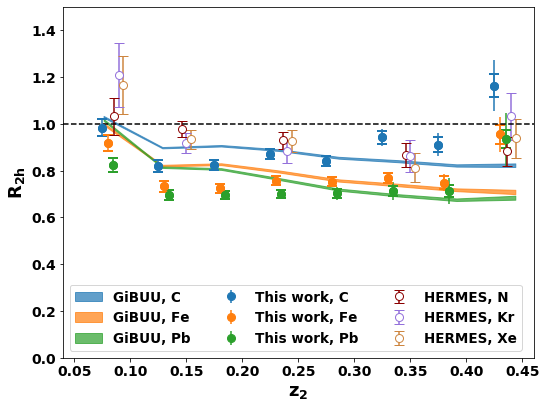

In [31]:
fig = plt.figure(figsize=(8,6))
colorBands=['black','#1f77b4','#ff7f0e','#2ca02c']
sysErr=sysErr_z2

for i,target in enumerate(['C','Fe','Pb']):
    r, err,x = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2, nbins=dpionz2Bins, variable='h2_z', 
                        pair_cut = pair_cut_nom,trig_cut = trigger_cut_nom)
    plt.errorbar(x+0.005*i,r,yerr=err,label='This work, %s'%target,fmt='o',ms=8,color=colorBands[i+1]) ## 'fmt' is for formatting
    plt.errorbar(x+0.005*i,r,yerr=r*(sysErr[target]/100),fmt='o',ms=8,capthick=2,capsize=5,color=colorBands[i+1])
    #if i==0:plt.fill_between(x+0.005, 0,sysErr/100., color=colorBands[i],alpha=0.4)
    print(err)
    print(sysErr[target]/100)
for i,target in enumerate(['C','Fe','Pb']):    
    #plt.errorbar(np.subtract(x,-i*0.005),r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',
    #alpha=0.99,color=colors[target])
    #plt.fill_between(np.subtract(x, 0,1.04, color=colors[target],alpha=0.2)
    #GiBUU
    print('GiBUU: ', target)
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,variable='h2_z',minz=minz2,maxz=maxz2+0.02, nbins=dpionz2Bins, applyweight=False, 
                        pair_cut = '')
    #plt.fill_between(x,r,r-err,r+err,label='GiBUU, %s'%target,alpha=0.9,lw=5)
    #plt.plot(x,r,label='GiBUU %s'%target,alpha=0.79,lw=3,color=colors[target])
    #plt.errorbar(x,r,yerr=0,label='GiBUU, %s'%target,fmt='o', ls='-', lw=3, alpha=0.7, ms=0.)
    plt.fill_between(x+0.00*i,r-err,r+err,label='GiBUU, %s'%target,alpha=0.7,lw=1,color=colorBands[i+1])
plt.xlabel('$\mathrm{z}_{\mathrm{2}}$',fontsize=18, fontweight='bold')
plt.ylabel('R$_{\mathrm{2h}}$',fontsize=18, fontweight='bold')


plt.errorbar(hermes_x['N'], hermes_y['N'],yerr=hermes_ytotal['N'],fmt='o',mfc='white',
             label='HERMES, N',fillstyle=None,ms=8,capsize=5, color='darkred')
plt.errorbar(hermes_x['Kr'], hermes_y['Kr'],yerr=hermes_ytotal['Kr'],fmt='o',mfc='white',
             label='HERMES, Kr',fillstyle=None,ms=8,capsize=5, color='mediumpurple')
plt.errorbar(hermes_x['Xe'], hermes_y['Xe'],yerr=hermes_ytotal['Xe'],fmt='o',mfc='white',
             label='HERMES, Xe',fillstyle=None,ms=8,capsize=5, color='peru')
#plt.errorbar(neutrino_x, neutrino_y,yerr=neutrino_yerror,fmt='s',mfc='white',
            #label='Neutrino, $A_{eff}=21$',fillstyle=None,ms=8,capsize=5)

plt.ylim([0.,1.5])
plt.xlim([0.04,0.46])
plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(loc='best',frameon=True,fontsize=13.5,ncol=3 )

plt.tight_layout()
##plt.savefig('ComparisonWithHermes_Linear.png')
#plt.ylim([0.55,1.85]) 

#plt.yscale('log')
##plt.savefig('ComparisonWithHermes_Log.png')
#plt.grid(True, axis='x',color='gainsboro', linestyle='dashed')
#plt.grid(True, axis='y',color='gainsboro', linestyle='dashed')
plt.xticks(np.arange(0.05,0.5,0.05),fontsize=14)
plt.yticks(fontsize=14)

outname='ComparisonWithHermes_Linear_sys_included2'
if not os.path.isdir(outdir):    os.mkdir(outdir)
plt.savefig(outdir+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir+outname+'.png', bbox_inches='tight')
#for paper
del colorBands
plt.show()

In [ ]:
print(outdir)

**Plotting only GiBUU**

In [ ]:
fig = plt.figure(figsize=(8,6))

for i,target in enumerate(['C','Fe','Pb']):    
#plt.errorbar(np.subtract(x,-i*0.005),r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',
#alpha=0.99,color=colors[target])
#plt.fill_between(np.subtract(x,-i*0.005), r*0.94,r*1.04, color=colors[target],alpha=0.2)
    
    #GiBUU
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,variable='h2_z',minz=minz2,maxz=maxz2+0.03, nbins=dpionz2Bins, applyweight=False, 
                        pair_cut = '')
    #plt.fill_between(x,r,r-err,r+err,label='GiBUU %s'%target,alpha=0.9,lw=5)
    #plt.plot(x,r,label='GiBUU %s'%target,alpha=0.79,lw=3,color=colors[target])
    #plt.errorbar(x,r,yerr=err,label='GiBUU %s'%target,fmt='o',ms=8)
    #plt.fill_between(x,r-err,r+err,label='GiBUU, %s'%target,alpha=0.5,lw=2)
    plt.fill_between(x+0.00*i,r-err,r+err,label='GiBUU, %s'%target,alpha=0.5,lw=2,color=colors[target])
plt.xlabel('z$_{2}$',fontsize=18, fontweight='bold')
plt.ylabel('R$_{2\mathrm{h}}$',fontsize=18, fontweight='bold')



plt.ylim([0.59,1.11])
#plt.xlim([0.00,0.5])
plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(loc='best',frameon=False,fontsize=13.5,ncol=1 )

plt.tight_layout()
##plt.savefig('ComparisonWithHermes_Linear.png')
#plt.ylim([0.55,1.85]) 

#plt.yscale('log')
##plt.savefig('ComparisonWithHermes_Log.png')
#plt.grid(True, axis='x',color='gainsboro', linestyle='dashed')
#plt.grid(True, axis='y',color='gainsboro', linestyle='dashed')
plt.xticks(np.arange(0.05,0.5,0.05),fontsize=14)
plt.yticks(fontsize=14)


outname='r2h_z2_GiBUU_only'
if not os.path.isdir(outdir_intro):    os.mkdir(outdir_intro)
plt.savefig(outdir_intro+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_intro+outname+'.png', bbox_inches='tight')

plt.show()

**Comaprison only with HERMES**

In [ ]:
fig = plt.figure(figsize=(8,6))

for i,target in enumerate(['C','Fe','Pb']):
    r, err,x = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2, nbins=dpionz2Bins, variable='h2_z', 
                        pair_cut = pair_cut_nom,trig_cut = trigger_cut_nom)
    plt.errorbar(x+0.005*i,r,yerr=err,label='This work, %s'%target,fmt='o',ms=8) ## 'fmt' is for formatting
    
plt.xlabel('$z_{2}$',fontsize=18)
plt.ylabel('R$_{2h}$',fontsize=18)
for i,target in enumerate(['C','Fe','Pb']): 
    #GiBUU
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,variable='h2_z',minz=minz2,maxz=maxz2, nbins=dpionz2Bins, applyweight=False, 
                        pair_cut = '')
    #plt.fill_between(x,r,r-err,r+err,label='GiBUU %s'%target,alpha=0.9,lw=5)
    #plt.plot(x,r,label='GiBUU %s'%target,alpha=0.79,lw=3,color=colors[target])
    #plt.errorbar(x,r,yerr=err,label='GiBUU %s'%target,fmt='o',ms=8)
    #plt.fill_between(x+0.005*i,r-err,r+err,label='GiBUU %s'%target,alpha=0.9,lw=5)
plt.xlabel('$z_{2}$',fontsize=18)
plt.ylabel('R$_{2h}$',fontsize=18)

plt.errorbar(hermes_x['N'], hermes_y['N'],yerr=hermes_ytotal['N'],fmt='o',mfc='white',
             label='HERMES, N',fillstyle=None,ms=8,capsize=5)
plt.errorbar(hermes_x['Kr'], hermes_y['Kr'],yerr=hermes_ytotal['Kr'],fmt='o',mfc='white',
             label='HERMES, Kr',fillstyle=None,ms=8,capsize=5)
plt.errorbar(hermes_x['Xe'], hermes_y['Xe'],yerr=hermes_ytotal['Xe'],fmt='o',mfc='white',
             label='HERMES, Xe',fillstyle=None,ms=8,capsize=5)
#plt.errorbar(neutrino_x, neutrino_y,yerr=neutrino_yerror,fmt='s',mfc='white',
            #label='Neutrino, $A_{eff}=21$',fillstyle=None,ms=8,capsize=5)

plt.ylim([0.45,1.45])
#plt.xlim([0.00,0.5])
plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(loc='upper center',frameon=True,fontsize=13.5,ncol=2 )

plt.tight_layout()
##plt.savefig('ComparisonWithHermes_Linear.png')
#plt.ylim([0.55,1.85]) 

#plt.yscale('log')
##plt.savefig('ComparisonWithHermes_Log.png')
#plt.grid(True, axis='x',color='gainsboro', linestyle='dashed')
#plt.grid(True, axis='y',color='gainsboro', linestyle='dashed')
plt.xticks(np.arange(0.1,0.5,0.05),fontsize=14)
plt.yticks(fontsize=14)

#plt.savefig('ComparisonWithHERMES_noGiBUU.pdf', bbox_inches='tight')
plt.show()

**Comparison with z1+z2<0.8 cut**

In [ ]:
fig = plt.figure(figsize=(8,6))

for i,target in enumerate(['C','Fe','Pb']):
    r, err,x = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2, nbins=dpionz2Bins, variable='h2_z', 
                        pair_cut = pair_cut_nom,
                        trig_cut = trigger_cut_nom)
    plt.errorbar(x+0.005*i,r,yerr=err,label='This work, %s'%target,fmt='o',ms=8) ## 'fmt' is for formatting
for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2, nbins=dpionz2Bins, variable='h2_z', 
                        pair_cut = '%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0. '%pair_cut_nom,
                        trig_cut = trigger_cut_nom)
    plt.errorbar(x+0.005*i,r2,yerr=err2,label='$z_{1}+z_{2}<1.0$ %s'%target,fmt='o',ms=8) ## 'fmt' is for formatting
        
    
    
    
for i,target in enumerate(['C','Fe','Pb']):    
    #GiBUU
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,variable='h2_z',minz=minz2,maxz=maxz2, nbins=dpionz2Bins, applyweight=False, 
                        pair_cut = '')
    plt.fill_between(x+0.005*i,r-err,r+err,label='GiBUU %s'%target,alpha=0.9,lw=5)
plt.xlabel('$z_{2}$',fontsize=18)
plt.ylabel('R$_{2h}$',fontsize=18)

for i,target in enumerate(['C','Fe','Pb']):    
    #GiBUU
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,variable='h2_z',minz=minz2,maxz=maxz2, nbins=dpionz2Bins, applyweight=False, 
                        pair_cut = 'and  (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0. ')
    plt.fill_between(x+0.005*i,r-err,r+err,label='GiBUU,$z_{1}+z_{2}<1.0$ %s'%target,alpha=0.9,lw=5)
plt.xlabel('$z_{2}$',fontsize=18)
plt.ylabel('R$_{2h}$',fontsize=18)

#plt.ylim([0.,1.5])
#plt.xlim([0.00,0.5])
plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(loc='best',frameon=False,fontsize=13.5,ncol=4 )

plt.tight_layout()
##plt.savefig('ComparisonWithHermes_Linear.png')
#plt.ylim([0.55,1.85]) 

#plt.yscale('log')
##plt.savefig('ComparisonWithHermes_Log.png')
plt.grid(True, axis='x',color='gainsboro', linestyle='dashed')
plt.grid(True, axis='y',color='gainsboro', linestyle='dashed')
plt.xticks(np.arange(0.1,0.5,0.05),fontsize=14)
plt.yticks(fontsize=14)


##plt.savefig('ComparisonR2h_z1z2less08.pdf', bbox_inches='tight')
plt.show()

**Comparison with single-hadron suppression**

In [ ]:
x_data_singleHadron = np.array([0.05,0.15,0.25,0.35,0.45])
y_data_singleHadron = {}
erry_data_singleHadron  ={}

y_data_singleHadron['pip_C'] = np.array([1.14377 , 0.991528 , 0.902358 , 0.853406 , 0.837642 ])
erry_data_singleHadron['pip_C'] = np.array([0.00311613 , 0.00157512 , 0.001843 , 0.00229271 , 0.00291008 ])
y_data_singleHadron['pip_Fe'] = np.array([1.16785 , 0.914393 , 0.758705 , 0.683655 , 0.642149 ])
erry_data_singleHadron['pip_Fe'] = np.array([0.00285128 , 0.00131102 , 0.00141581 , 0.00169536 , 0.00206393  ])
y_data_singleHadron['pip_Pb'] = np.array([0.958606 , 0.719983 , 0.57628 , 0.503447 , 0.464043  ])
erry_data_singleHadron['pip_Pb'] = np.array([0.00273899 , 0.00124261 , 0.00132827 , 0.00159042 , 0.00194019 ])

x_data_pim_singleHadron = np.array([0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75])

y_data_singleHadron['pim_C'] = np.array([ 1.14172 , 0.992301 , 0.904382 , 0.858762 , 0.814561 ])
erry_data_singleHadron['pim_C'] = np.array([0.0054489 , 0.00266114 , 0.00303142 , 0.00430438 , 0.00651458  ])
y_data_singleHadron['pim_Fe'] = np.array([1.18926 , 0.949964 , 0.802236 , 0.717104 , 0.656101 ])
erry_data_singleHadron['pim_Fe'] = np.array([0.00532453 , 0.00237637 , 0.00250118 , 0.00334693 , 0.00490003  ])
y_data_singleHadron['pim_Pb'] = np.array([1.07461 , 0.826597 , 0.668954 , 0.571658 , 0.511301 ]) 
erry_data_singleHadron['pim_Pb'] = np.array([0.00523426 , 0.00230227 , 0.00241594 , 0.00321067 , 0.00467534  ])


y_GiBUU_singleHadron = {}
erry_GiBUU_singleHadron  ={}
x_GiBUU_singleHadron = np.array([0.05555556 ,0.16666667 ,0.27777778 ,0.38888889, 0.45  ])


y_GiBUU_singleHadron['pip_C']=np.array([1.2706959,  1.08947724, 0.99504182, 0.90983822, 0.87008815])
y_GiBUU_singleHadron['pip_Fe']=np.array([1.45474057, 1.08676467, 0.90162779, 0.75997446, 0.70464241])
y_GiBUU_singleHadron['pip_Pb']=np.array([1.34267664, 0.92325242 ,0.70871029, 0.57738503, 0.52548756])
y_GiBUU_singleHadron['pim_C']=np.array([1.15775933 ,1.00102127, 0.96162586, 0.89191957, 0.85893181])
y_GiBUU_singleHadron['pim_Fe']=np.array([1.25795649 ,0.95501298, 0.85133908, 0.73355979, 0.68619796])
y_GiBUU_singleHadron['pim_Pb']=np.array([1.50585669 ,1.00346182, 0.83044466, 0.65311636, 0.58317362])

erry_GiBUU_singleHadron['pip_C']=np.array([0.00178479 ,0.00118499 ,0.00151467, 0.00174534, 0.00196202])
erry_GiBUU_singleHadron['pip_Fe']=np.array([0.00225931, 0.00137018 ,0.0016492 , 0.00181247, 0.00200441])
erry_GiBUU_singleHadron['pip_Pb']=np.array([0.00193688, 0.00109174, 0.0012368,  0.00132385, 0.00144436])
erry_GiBUU_singleHadron['pim_C']=np.array([0.00149382 ,0.00100624, 0.00145127, 0.0018199,  0.00216692])
erry_GiBUU_singleHadron['pim_Fe']=np.array([0.00182938, 0.00113482, 0.00155974, 0.00187395, 0.00219665])
erry_GiBUU_singleHadron['pim_Pb']=np.array([0.00191197, 0.00105352, 0.00136291 ,0.00152573, 0.0017285])

 #totalerror = np.sqrt(np.power(np.array(erry_data['pip_%s'%target]),2) + 
 #                        np.power(np.array(y_data['pip_%s'%target])*sysError,2))

sysError=0.045
for i, target in enumerate(['C','Fe','Pb']):
    erry_data_singleHadron['pip_%s'%target] = np.sqrt(np.power(np.array(erry_data_singleHadron['pip_%s'%target]),2) + 
                                           np.power(np.array(y_data_singleHadron['pip_%s'%target])*sysError,2))


sysError=0.045
for i, target in enumerate(['C','Fe','Pb']):
    erry_data_singleHadron['pim_%s'%target] = np.sqrt(np.power(np.array(erry_data_singleHadron['pim_%s'%target]),2) + 
                                           np.power(np.array(y_data_singleHadron['pim_%s'%target])*sysError,2))

colors2=['','#1f77b4','#ff7f0e','#2ca02c']


alpha_value=0.8

fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,5),gridspec_kw={'hspace': 0., 'wspace':0.})


for i,target in enumerate(['C','Fe','Pb']):
    r, err,x = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2, nbins=dpionz2Bins, variable='h2_z',
                            pair_cut = pair_cut_nom,trig_cut = trigger_cut_nom)
    
    tot_err= np.sqrt(np.power(err,2) + np.power(r*sysErr_z2[target]/100,2) )
    if True:    
        axs[i].errorbar(x+0.00*i,r,yerr=tot_err,label='Data, R$_{\mathrm{2h}}$'if i == 0 else "",fmt='o',ms=8, 
                        color=colors2[1],lw=2, alpha=alpha_value)
        #axs[i].fill_between(x+0.005*i,r-err,r+err,alpha=alpha_value-0.5, 
        #                    color=colors2[1])  

        
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,variable='h2_z',minz=minz2,maxz=maxz2, nbins=dpionz2Bins, applyweight=False, 
                        pair_cut = 'and h1_z>0.5')
    if True:    
        axs[i].errorbar(x+0.005*i,r,yerr=err,fmt='-',ms=8,label='GiBUU, R$_{\mathrm{2h}}$'if i == 0 else "",color=colors2[1],
                        lw=3)
        #axs[i].fill_between(x+0.005*i,r-err,r+err,label='GiBUU cond.',alpha=alpha_value,lw=5)
    #else:
    #    axs[i].errorbar(x+0.005*i,r,yerr=err,fmt='-',ms=8, color=colors2[1],lw=3)
        #axs[i].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)
count=0    
for i,target in enumerate(['C','Fe','Pb']):  
    if True:
        #axs[i].errorbar(x_data_singleHadron+0.005*i,y_data_singleHadron['pim_%s'%target],
        #                yerr=erry_data_singleHadron['pim_%s'%target],label='Inc. $\pi^{-}$'if i == 0 else "",
        #                fmt='--o',ms=8, color=colors2[2], alpha=alpha_value,lw=2)
        #axs[i].errorbar(x_GiBUU_singleHadron+0.005*i,y_GiBUU_singleHadron['pim_%s'%target],
        #                yerr=erry_GiBUU_singleHadron['pim_%s'%target],label='GiBUU Inc. $\pi^{-}$'if i == 0 else "",
        #                fmt='-',ms=8, color=colors2[2],lw=3)
        axs[i].errorbar(x_data_singleHadron+0.005*i,y_data_singleHadron['pip_%s'%target],
                        yerr=erry_data_singleHadron['pip_%s'%target],label='Data, R$_{\mathrm{h}}$'if i == 0 else "",
                        fmt='o',ms=8, color=colors2[2], alpha=alpha_value,lw=2)
        axs[i].errorbar(x_GiBUU_singleHadron+0.005*i,y_GiBUU_singleHadron['pip_%s'%target],
                        yerr=erry_GiBUU_singleHadron['pip_%s'%target],label='GiBUU, R$_{\mathrm{h}}$'if i == 0 else "",
                        fmt='-',ms=8, color=colors2[2],lw=3)


    count=count+1
        
for i in range(3):    axs[i].set_xlabel('z',fontsize=18, fontweight='bold')
tit=r'Suppression Factor'
axs[0].set_ylabel(tit,fontsize=18,fontweight='bold')
axs[0].set_title('C',fontweight='bold')
axs[1].set_title('Fe',fontweight='bold')
axs[2].set_title('Pb',fontweight='bold')



for i in range(0,3):    
    axs[i].axhline(y=1.0,color='black',linestyle='--')
    #axs[i].legend(loc='best',frameon=False,fontsize=13.5,ncol=2 )
    #axs[i].grid(True, axis='x',color='gainsboro', linestyle='dashed')
    #axs[i].grid(True, axis='y',color='gainsboro', linestyle='dashed')
    axs[i].tick_params(axis='y', which='major', labelsize=11)
    axs[i].tick_params(axis='both', which='major', labelsize=11)



#plt.ylim([0.,1.5])
#plt.xlim([0.00,0.5])
#plt.axhline(y=1.0,color='black',linestyle='--')
#plt.legend(loc='best',frameon=False,fontsize=13.5,ncol=3 )

#plt.tight_layout()
##plt.savefig('ComparisonWithHermes_Linear.png')
#plt.ylim([0.55,1.85]) 

#plt.yscale('log')
##plt.savefig('ComparisonWithHermes_Log.png')
#plt.grid(True, axis='x',color='gainsboro', linestyle='dashed')
#plt.grid(True, axis='y',color='gainsboro', linestyle='dashed')
#plt.xticks(np.arange(0.1,0.5,0.05),fontsize=14)
#plt.yticks(fontsize=14)
plt.subplots_adjust(right=0.85, top=0.9)
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=15, borderaxespad=0.3, title='\n')
##plt.savefig('ComparisonWithHermes_Linear.png')
#plt.yscale('log')



outname='ComparisonConditionalInclusiveRatios_noPiminus'
if not os.path.isdir(outdir):
    os.mkdir(outdir)
plt.savefig(outdir+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir+outname+'.png', bbox_inches='tight')
del colors2

plt.show()



In [ ]:
x_data_singleHadron = np.array([0.05,0.15,0.25,0.35,0.45])
y_data_singleHadron = {}
erry_data_singleHadron  ={}

y_data_singleHadron['pip_C'] = np.array([1.14377 , 0.991528 , 0.902358 , 0.853406 , 0.837642 ])
erry_data_singleHadron['pip_C'] = np.array([0.00311613 , 0.00157512 , 0.001843 , 0.00229271 , 0.00291008 ])
y_data_singleHadron['pip_Fe'] = np.array([1.16785 , 0.914393 , 0.758705 , 0.683655 , 0.642149 ])
erry_data_singleHadron['pip_Fe'] = np.array([0.00285128 , 0.00131102 , 0.00141581 , 0.00169536 , 0.00206393  ])
y_data_singleHadron['pip_Pb'] = np.array([0.958606 , 0.719983 , 0.57628 , 0.503447 , 0.464043  ])
erry_data_singleHadron['pip_Pb'] = np.array([0.00273899 , 0.00124261 , 0.00132827 , 0.00159042 , 0.00194019 ])

x_data_pim_singleHadron = np.array([0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75])

y_data_singleHadron['pim_C'] = np.array([ 1.14172 , 0.992301 , 0.904382 , 0.858762 , 0.814561 ])
erry_data_singleHadron['pim_C'] = np.array([0.0054489 , 0.00266114 , 0.00303142 , 0.00430438 , 0.00651458  ])
y_data_singleHadron['pim_Fe'] = np.array([1.18926 , 0.949964 , 0.802236 , 0.717104 , 0.656101 ])
erry_data_singleHadron['pim_Fe'] = np.array([0.00532453 , 0.00237637 , 0.00250118 , 0.00334693 , 0.00490003  ])
y_data_singleHadron['pim_Pb'] = np.array([1.07461 , 0.826597 , 0.668954 , 0.571658 , 0.511301 ]) 
erry_data_singleHadron['pim_Pb'] = np.array([0.00523426 , 0.00230227 , 0.00241594 , 0.00321067 , 0.00467534  ])


y_GiBUU_singleHadron = {}
erry_GiBUU_singleHadron  ={}
x_GiBUU_singleHadron = np.array([0.05555556 ,0.16666667 ,0.27777778 ,0.38888889, 0.45  ])


y_GiBUU_singleHadron['pip_C']=np.array([1.2706959,  1.08947724, 0.99504182, 0.90983822, 0.87008815])
y_GiBUU_singleHadron['pip_Fe']=np.array([1.45474057, 1.08676467, 0.90162779, 0.75997446, 0.70464241])
y_GiBUU_singleHadron['pip_Pb']=np.array([1.34267664, 0.92325242 ,0.70871029, 0.57738503, 0.52548756])
y_GiBUU_singleHadron['pim_C']=np.array([1.15775933 ,1.00102127, 0.96162586, 0.89191957, 0.85893181])
y_GiBUU_singleHadron['pim_Fe']=np.array([1.25795649 ,0.95501298, 0.85133908, 0.73355979, 0.68619796])
y_GiBUU_singleHadron['pim_Pb']=np.array([1.50585669 ,1.00346182, 0.83044466, 0.65311636, 0.58317362])

erry_GiBUU_singleHadron['pip_C']=np.array([0.00178479 ,0.00118499 ,0.00151467, 0.00174534, 0.00196202])
erry_GiBUU_singleHadron['pip_Fe']=np.array([0.00225931, 0.00137018 ,0.0016492 , 0.00181247, 0.00200441])
erry_GiBUU_singleHadron['pip_Pb']=np.array([0.00193688, 0.00109174, 0.0012368,  0.00132385, 0.00144436])
erry_GiBUU_singleHadron['pim_C']=np.array([0.00149382 ,0.00100624, 0.00145127, 0.0018199,  0.00216692])
erry_GiBUU_singleHadron['pim_Fe']=np.array([0.00182938, 0.00113482, 0.00155974, 0.00187395, 0.00219665])
erry_GiBUU_singleHadron['pim_Pb']=np.array([0.00191197, 0.00105352, 0.00136291 ,0.00152573, 0.0017285])

 #totalerror = np.sqrt(np.power(np.array(erry_data['pip_%s'%target]),2) + 
 #                        np.power(np.array(y_data['pip_%s'%target])*sysError,2))

sysError=0.045
for i, target in enumerate(['C','Fe','Pb']):
    erry_data_singleHadron['pip_%s'%target] = np.sqrt(np.power(np.array(erry_data_singleHadron['pip_%s'%target]),2) + 
                                           np.power(np.array(y_data_singleHadron['pip_%s'%target])*sysError,2))


sysError=0.045
for i, target in enumerate(['C','Fe','Pb']):
    erry_data_singleHadron['pim_%s'%target] = np.sqrt(np.power(np.array(erry_data_singleHadron['pim_%s'%target]),2) + 
                                           np.power(np.array(y_data_singleHadron['pim_%s'%target])*sysError,2))

colors2=['','#1f77b4','#ff7f0e','#2ca02c']


alpha_value=0.8

fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,5),gridspec_kw={'hspace': 0., 'wspace':0.})


for i,target in enumerate(['C','Fe','Pb']):
    r, err,x = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2, nbins=dpionz2Bins, variable='h2_z',
                            pair_cut = pair_cut_nom,trig_cut = trigger_cut_nom)


        #axs[i].fill_between(x+0.005*i,r-err,r+err,alpha=alpha_value-0.5, 
        #                    color=colors2[1])  

        
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,variable='h2_z',minz=minz2,maxz=maxz2, nbins=dpionz2Bins, applyweight=False, 
                        pair_cut = 'and h1_z>0.5')
    if True:    
        axs[i].errorbar(x+0.00*i,r,yerr=err,fmt='-',ms=8,label='GiBUU, R$_{2\mathrm{h}}$'if i == 0 else "",color=colors2[1],
                        lw=3)
        #axs[i].fill_between(x+0.005*i,r-err,r+err,label='GiBUU cond.',alpha=alpha_value,lw=5)
    #else:
    #    axs[i].errorbar(x+0.005*i,r,yerr=err,fmt='-',ms=8, color=colors2[1],lw=3)
        #axs[i].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)
count=0    
for i,target in enumerate(['C','Fe','Pb']):  
    if True:
        #axs[i].errorbar(x_data_singleHadron+0.005*i,y_data_singleHadron['pim_%s'%target],
        #                yerr=erry_data_singleHadron['pim_%s'%target],label='Inc. $\pi^{-}$'if i == 0 else "",
        #                fmt='--o',ms=8, color=colors2[2], alpha=alpha_value,lw=2)
        #axs[i].errorbar(x_GiBUU_singleHadron+0.005*i,y_GiBUU_singleHadron['pim_%s'%target],
        #                yerr=erry_GiBUU_singleHadron['pim_%s'%target],label='GiBUU Inc. $\pi^{-}$'if i == 0 else "",
        #                fmt='-',ms=8, color=colors2[2],lw=3)

        axs[i].errorbar(x_GiBUU_singleHadron+0.00*i,y_GiBUU_singleHadron['pip_%s'%target],
                        yerr=erry_GiBUU_singleHadron['pip_%s'%target],label='GiBUU, R$_{\mathrm{h}}$'if i == 0 else "",
                        fmt='-',ms=8, color=colors2[2],lw=3)


    count=count+1
        
for i in range(3):    axs[i].set_xlabel('z',fontsize=18, fontweight='bold')
tit=r'Suppression Factor'
axs[0].set_ylabel(tit,fontsize=18,fontweight='bold')
axs[0].set_title('C',fontweight='bold')
axs[1].set_title('Fe',fontweight='bold')
axs[2].set_title('Pb',fontweight='bold')



for i in range(0,3):    
    axs[i].axhline(y=1.0,color='black',linestyle='--')
    #axs[i].legend(loc='best',frameon=False,fontsize=13.5,ncol=2 )
    #axs[i].grid(True, axis='x',color='gainsboro', linestyle='dashed')
    #axs[i].grid(True, axis='y',color='gainsboro', linestyle='dashed')
    axs[i].tick_params(axis='y', which='major', labelsize=11)
    axs[i].tick_params(axis='both', which='major', labelsize=11)



#plt.ylim([0.,1.5])
#plt.xlim([0.00,0.5])
#plt.axhline(y=1.0,color='black',linestyle='--')
#plt.legend(loc='best',frameon=False,fontsize=13.5,ncol=3 )

#plt.tight_layout()
##plt.savefig('ComparisonWithHermes_Linear.png')
#plt.ylim([0.55,1.85]) 

#plt.yscale('log')
##plt.savefig('ComparisonWithHermes_Log.png')
#plt.grid(True, axis='x',color='gainsboro', linestyle='dashed')
#plt.grid(True, axis='y',color='gainsboro', linestyle='dashed')
#plt.xticks(np.arange(0.1,0.5,0.05),fontsize=14)
#plt.yticks(fontsize=14)
plt.subplots_adjust(right=0.85, top=0.9)
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=15, borderaxespad=0.3, title='\n')
##plt.savefig('ComparisonWithHermes_Linear.png')
#plt.yscale('log')

outname='ComparisonConditionalInclusiveRatios_noPiminus_GiBUU_only'
if not os.path.isdir(outdir_intro):    os.mkdir(outdir_intro)
plt.savefig(outdir_intro+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_intro+outname+'.png', bbox_inches='tight')
del colors2
plt.show()



# Get ratio from MC (null expected). 
**Deviations reflect acceptance differences between solid and liquid target**


**Idea: MC has not signal, any modification from unity is due to acceptance effects**

**As a function of $z_{2}$**

In [ ]:
fig = plt.figure(figsize=(8,6))
triCut='h1_z> 0.5'
for i,target in enumerate(['Pb']):
    r, err,x = r2h.getRatio(df_mc['%s'%target], df_mc['D'], 
                        df_mc_trigger['%s_trigger'%target], df_mc_trigger['D_trigger'],
                        minz=0.08,maxz=0.45 , trig_cut='%s'%triCut)
    
    plt.errorbar(x+0.01,r,yerr=err,label='all pairs,  %s'%target,fmt='o',ms=8)
    r, err,x = r2h.getRatio(df_mc['%s'%target], df_mc['D'], 
                        df_mc_trigger['%s_trigger'%target], df_mc_trigger['D_trigger'],
                        minz=0.08,maxz=0.45,    pair_cut='and h1_pid>0 and h2_pid<0', trig_cut='%s'%triCut)
    plt.errorbar(x+0.02,r,yerr=err,label='$\pi^{+}$, $\pi^{-}$',fmt='o',ms=8)
    
    
    r, err,x = r2h.getRatio(df_mc['%s'%target], df_mc['D'], 
                        df_mc_trigger['%s_trigger'%target], df_mc_trigger['D_trigger'],
                        minz=0.08, maxz=0.45,   pair_cut='and h1_pid<0 and h2_pid>0', trig_cut='%s'%triCut)
    plt.errorbar(x+0.03,r,yerr=err,label='$\pi^{-}$, $\pi^{+}$',fmt='o',ms=8)
    
plt.ylabel(r'R$_{2h}$',fontsize=22, fontweight='bold')
plt.xlabel(r'$z_{2}$',fontsize=22)
plt.ylim([0.8,1.2])
plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(frameon=False,loc='best')

In [ ]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,5),gridspec_kw={'hspace': 0., 'wspace':0.})

triCut='h1_z> 0.5 and abs(h1_pid)==211 and h1_th<90 and h1_th>10'
pairCut_1='and h1_pid==211 and abs(h2_pid)==211 and h1_z> 0.5 and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0.  and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s'%(minz2,maxz2,maxzmass ,minzmass)
pairCut_2='and h1_pid==-211 and abs(h2_pid)==211 and h1_z> 0.5 and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0.  and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s'%(minz2,maxz2,maxzmass ,minzmass)

for i,target in enumerate(['C','Fe','Pb']):
    r, err,x = r2h.getRatio(df_mc['%s'%target], df_mc['D'], 
                        df_mc_trigger['%s_trigger'%target], df_mc_trigger['D_trigger'],
                        minz=minz2,maxz=maxz2, variable='h2_z', trig_cut='%s'%triCut,nbins=dpionz2Bins,
                           pair_cut='')
    
    axs[i].errorbar(x+0.005,r,yerr=err,label='All'if i == 0 else "",fmt='o',ms=8, alpha=0.7)
    r, err,x = r2h.getRatio(df_mc['%s'%target], df_mc['D'], 
                        df_mc_trigger['%s_trigger'%target], df_mc_trigger['D_trigger'],
                        minz=minz2,maxz=maxz2,    pair_cut='%s'%pairCut_1, nbins=dpionz2Bins,
                            variable='h2_z', trig_cut='%s'%triCut)
    axs[i].errorbar(x+0.01,r,yerr=err,label='$\pi^{+}$ trigger'if i == 0 else "",fmt='o',ms=8, alpha=0.7)
    
    
    r, err,x = r2h.getRatio(df_mc['%s'%target], df_mc['D'], 
                        df_mc_trigger['%s_trigger'%target], df_mc_trigger['D_trigger'],
                        minz=0.06, maxz=0.45,   pair_cut='%s'%pairCut_2, nbins=dpionz2Bins,
                            variable='h2_z', trig_cut='%s'%triCut)
    axs[i].errorbar(x+0.015,r,yerr=err,label='$\pi^{-}$ trigger'if i == 0 else "",fmt='o',ms=8, alpha=0.7)
    

for i in range(3):    axs[i].set_xlabel(r'$z_{2}$',fontsize=18)

axs[0].set_ylabel('R$_{\mathrm{2h}}$',fontsize=18, fontweight='bold')
axs[0].set_title('C', fontweight='bold')
axs[1].set_title('Fe', fontweight='bold')
axs[2].set_title('Pb', fontweight='bold')


axs[0].set_ylim([0.85,1.15])
#axs[0].set_xlim([0.00,0.5])
for i in range(0,3):    
    axs[i].axhline(y=1.0,color='black',linestyle='--')
    #axs[i].legend(loc='best',frameon=False,fontsize=13.5,ncol=2 )
    axs[i].grid(True, axis='x',color='gainsboro', linestyle='dashed')
    axs[i].grid(True, axis='y',color='gainsboro', linestyle='dashed')
    axs[i].tick_params(axis='y', which='major', labelsize=11)
    axs[i].tick_params(axis='both', which='major', labelsize=11)

plt.subplots_adjust(right=0.85, top=0.9)
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=14, borderaxespad=0.3, title='\n\n MC')
##plt.savefig('ComparisonWithHermes_Linear.png')
#plt.yscale('log')


outname='MC_cross_check_z2'
if not os.path.isdir(outdir_sys):
    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')


plt.show()


**As a function of $\Delta \phi$**

In [ ]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,5),gridspec_kw={'hspace': 0., 'wspace':0.})

triCut='h1_z> 0.5 and abs(h1_pid)==211 and h1_th<90 and h1_th>10'
pairCut_1='and h1_pid==211 and abs(h2_pid)==211 and h1_z> 0.5 and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0.  and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s'%(minz2,maxz2,maxzmass ,minzmass)
pairCut_2='and h1_pid==-211 and abs(h2_pid)==211 and h1_z> 0.5 and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0.  and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s'%(minz2,maxz2,maxzmass ,minzmass)


for i,target in enumerate(['C','Fe','Pb']):
    r, err,x = r2h.getRatio(df_mc['%s'%target], df_mc['D'], 
                        df_mc_trigger['%s_trigger'%target], df_mc_trigger['D_trigger'],
                        minz=mindphi,maxz=maxdphi, variable='dphi', trig_cut='%s'%triCut,nbins=dpiondphiBins,
                           pair_cut='and  h2_z>0.1')
    
    axs[i].errorbar(x+0.01,r,yerr=err,label='All'if i == 0 else "",fmt='o',ms=8, alpha=0.7)
    r, err,x = r2h.getRatio(df_mc['%s'%target], df_mc['D'], 
                        df_mc_trigger['%s_trigger'%target], df_mc_trigger['D_trigger'],
                        minz=mindphi,maxz=maxdphi,    pair_cut='%s and h2_z>0.1'%pairCut_1, nbins=dpiondphiBins,
                            variable='dphi', trig_cut='%s'%triCut)
    axs[i].errorbar(x+0.02,r,yerr=err,label='$\pi^{+}$ trigger'if i == 0 else "",fmt='o',ms=8, alpha=0.7)
    
    
    r, err,x = r2h.getRatio(df_mc['%s'%target], df_mc['D'], 
                        df_mc_trigger['%s_trigger'%target], df_mc_trigger['D_trigger'],
                        minz=mindphi,maxz=maxdphi,   pair_cut='%s and h2_z>0.1'%pairCut_2, nbins=dpiondphiBins,
                            variable='dphi', trig_cut='%s'%triCut)
    axs[i].errorbar(x+0.03,r,yerr=err,label='$\pi^{-}$ trigger'if i == 0 else "",fmt='o',ms=8, alpha=0.7)
    

for i in range(3):    axs[i].set_xlabel(r'$\Delta \phi$ [rad]',fontsize=18, fontweight='bold')

axs[0].set_ylabel('R$_{\mathrm{2h}}$',fontsize=18, fontweight='bold')
axs[0].set_title('C', fontweight='bold')
axs[1].set_title('Fe', fontweight='bold')
axs[2].set_title('Pb', fontweight='bold')


axs[0].set_ylim([0.85,1.15])
#axs[0].set_xlim([0.00,0.5])
for i in range(0,3):    
    axs[i].axhline(y=1.0,color='black',linestyle='--')
    #axs[i].legend(loc='best',frameon=False,fontsize=13.5,ncol=2 )
    axs[i].grid(True, axis='x',color='gainsboro', linestyle='dashed')
    axs[i].grid(True, axis='y',color='gainsboro', linestyle='dashed')
    axs[i].tick_params(axis='y', which='major', labelsize=11)
    axs[i].tick_params(axis='both', which='major', labelsize=11)

plt.subplots_adjust(right=0.85, top=0.9)
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=14, borderaxespad=0.3, title='\n\n MC')
##plt.savefig('ComparisonWithHermes_Linear.png')
#plt.yscale('log')

outname='MC_cross_check_dphi'
if not os.path.isdir(outdir_sys):
    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')


plt.show()




**As a function of pion-par mass**

In [ ]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,5),gridspec_kw={'hspace': 0., 'wspace':0.})

triCut='h1_z> 0.5 and abs(h1_pid)==211 and h1_th<90 and h1_th>10'
pairCut_1='and h1_pid==211 and abs(h2_pid)==211 and h1_z> 0.5 and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0.  and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s'%(minz2,maxz2,maxzmass ,minzmass)
pairCut_2='and h1_pid==-211 and abs(h2_pid)==211 and h1_z> 0.5 and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0.  and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s'%(minz2,maxz2,maxzmass ,minzmass)


for i,target in enumerate(['C', 'Fe','Pb']):
    r, err,x = r2h.getRatio(df_mc['%s'%target], df_mc['D'], 
                        df_mc_trigger['%s_trigger'%target], df_mc_trigger['D_trigger'],
                        minz=minzmass,maxz=maxzmass, variable='pair_mass', trig_cut='%s'%triCut,nbins=dpionMassBins,
                           pair_cut='and h2_z>0.10')
    
    axs[i].errorbar(x+0.01,r,yerr=err,label='All'if i == 0 else "",fmt='o',ms=8, alpha=0.7)
    r, err,x = r2h.getRatio(df_mc['%s'%target], df_mc['D'], 
                        df_mc_trigger['%s_trigger'%target], df_mc_trigger['D_trigger'],
                        minz=minzmass,maxz=maxzmass,    pair_cut='%s and h2_z>0.10'%pairCut_1, nbins=dpionMassBins,
                            variable='pair_mass', trig_cut='%s'%triCut)
    axs[i].errorbar(x+0.02,r,yerr=err,label='$\pi^{+}$ trigger'if i == 0 else "",fmt='o',ms=8, alpha=0.7)
    
    
    r, err,x = r2h.getRatio(df_mc['%s'%target], df_mc['D'], 
                        df_mc_trigger['%s_trigger'%target], df_mc_trigger['D_trigger'],
                        minz=minzmass,maxz=maxzmass,   pair_cut='%s and h2_z>0.10'%pairCut_2, nbins=dpionMassBins,
                            variable='pair_mass', trig_cut='%s '%triCut)
    axs[i].errorbar(x+0.03,r,yerr=err,label='$\pi^{-}$ trigger'if i == 0 else "",fmt='o',ms=8, alpha=0.7)
    

for i in range(3):    axs[i].set_xlabel('m$_{\pi\pi}$ (GeV)',fontsize=18,fontweight='bold')

axs[0].set_ylabel('R$_{\mathrm{2h}}$',fontsize=18, fontweight='bold')
axs[0].set_title('C', fontweight='bold')
axs[1].set_title('Fe', fontweight='bold')
axs[2].set_title('Pb', fontweight='bold')


axs[0].set_ylim([0.85,1.15])
#axs[0].set_xlim([0.00,0.5])
for i in range(0,3):    
    axs[i].axhline(y=1.0,color='black',linestyle='--')
    #axs[i].legend(loc='best',frameon=False,fontsize=13.5,ncol=2 )
    axs[i].grid(True, axis='x',color='gainsboro', linestyle='dashed')
    axs[i].grid(True, axis='y',color='gainsboro', linestyle='dashed')
    axs[i].tick_params(axis='y', which='major', labelsize=11)
    axs[i].tick_params(axis='both', which='major', labelsize=11)

plt.subplots_adjust(right=0.85, top=0.9)
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=14, borderaxespad=0.3, title='\n\n MC')
##plt.savefig('ComparisonWithHermes_Linear.png')
#plt.yscale('log')

outname='MC_cross_check_dpionMass'
if not os.path.isdir(outdir_sys):
    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')


plt.show()


# As a function of Pair_pt
pair_pt is a variable, is the transverse momentum of the dipion wrt the virtual photon (the usual pt but this time of the dipion)

In [ ]:
fig = plt.figure(figsize=(8,6))

for j,target in enumerate(['C','Fe','Pb']):
    r, err,x = r2h.getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target],
                        df_trigger['D_%s_trigger'%target],
                        pair_cut = pair_cut_nom,trig_cut = trigger_cut_nom,                            
                            minz=0.01,maxz=1.0,nbins=15,variable='pair_pt')
    plt.errorbar(np.subtract(x,-i*0.005),r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',
                 alpha=0.99,color=colors[target])
    #plt.fill_between(np.subtract(x,-i*0.005), r*0.94,r*1.04, color=colors[target],alpha=0.2)
    
for j,target in enumerate(['C','Fe','Pb']):
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],
                        df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                        pair_cut='',minz=0.01,maxz=1.0,nbins=15,variable='pair_pt')    
    #plt.errorbar(x,r,yerr=err,label='GiBUU %s'%target,ms=8,lw=2)
    plt.fill_between(x+0.005*i,r-err,r+err,label='GiBUU, %s'%target,alpha=0.5,lw=2,color=colors[target] )

plt.xlabel('Pair p$_{\mathrm{T}}$',fontsize=18, fontweight='bold')
plt.ylabel('R$_{2\mathrm{h}}$',fontsize=18, fontweight='bold')
plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(loc='upper left',frameon=False,fontsize=15,ncol=2)
plt.tight_layout()
plt.grid(True, axis='x',color='gainsboro', linestyle='dashed')
plt.grid(True, axis='y',color='gainsboro', linestyle='dashed')
##plt.savefig('R2h_Pt.pdf')

# With respect to $\Delta \phi$
'dphi' is a variable , is the difference between the PhiPQ of the trigger hadron and the secondary hadron

In [ ]:
fig = plt.figure(figsize=(8,6))

for j,target in enumerate(['C','Fe','Pb']):
    r, err,x = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBins,variable='dphi', 
                            pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_nom,
                            trig_cut = '%s'%trigger_cut_nom )
                            #pair_cut = 'and h2_z>0.1 and h2_z<0.5',
                            #trig_cut = 'h1_z>0.5' 
                            
    print('x is: ', x)
    print('r is: ', r) 
    print('err is: ', err) 
    plt.errorbar(np.subtract(x,-j*0.005),r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',alpha=0.99,color=colors[target])
    #plt.fill_between(np.subtract(x,-i*0.005), r*0.94,r*1.04, color=colors[target],alpha=0.2)
    
for j,target in enumerate(['C','Fe','Pb']):   
    #GiBUU
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],
                        df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBins,variable='dphi', 
                        pair_cut='and h2_z>0.1 and h2_z<0.5',
                           trig_cut='h1_z>0.5')
        
    plt.fill_between(x+0.005*j,r-err,r+err,label='GiBUU %s'%target,alpha=0.5,lw=2,color=colors[target])

    
    
plt.xlabel('$|\Delta\phi|$ [rad]',fontsize=18, fontweight='bold')
plt.ylabel('$\mathrm{R}_{\mathrm{2h}} (\mathrm{z}_{1},\mathrm{z}_{\mathrm{2}},\Delta\phi)$',fontsize=18, fontweight='bold')


plt.xlim([-0.01,3.155])
plt.ylim([0.55,1.13])
#plt.title('$0.10 < z_{2} < 0.50$')
plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(loc='lower left',frameon=True,fontsize=14,ncol=2)
#plt.grid(True, axis='x',color='gainsboro', linestyle='dashed')
#plt.grid(True, axis='y',color='gainsboro', linestyle='dashed')
plt.tight_layout()
##plt.savefig('R2h_DeltaPhi.pdf', bbox_inches='tight')

**Including systematic uncertainties**

Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not 

Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5and h2_z>0.05 and h2_z<0.45
Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5and h2_z>0.05 and h2_z<0.45


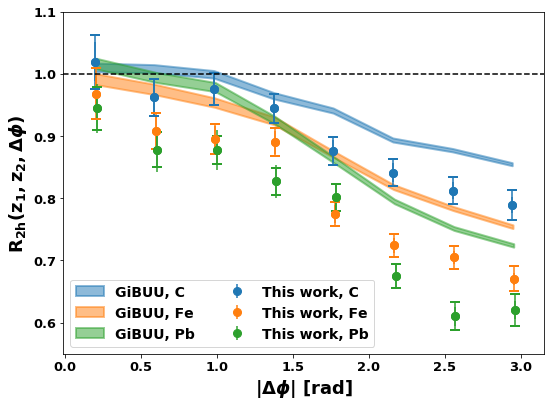

In [23]:
fig = plt.figure(figsize=(8,6))



colorBands=['black','#1f77b4','#ff7f0e','#2ca02c']
sysErr=sysErr_dphi

for j,target in enumerate(['C','Fe','Pb']):
    r, err,x = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBins,variable='dphi', 
                            pair_cut = '%s and h2_z>0.05 and h2_z<0.45'%pair_cut_nom,
                            trig_cut = '%s'%trigger_cut_nom )
                            #pair_cut = 'and h2_z>0.1 and h2_z<0.5',
                            #trig_cut = 'h1_z>0.5' 
                          
    print('x is: ', x)
    print('r is: ', r) 
    print('err is: ', err) 
    print('sys err is:', sysErr[target]/100)
    plt.errorbar(np.subtract(x,-j*0.009),r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',
                 alpha=0.99,color=colors[target],) #capsize=5, capthick=2)
    plt.errorbar(x+0.009*j,r,yerr=r*(sysErr[target]/100),fmt='o',ms=8,capthick=2,capsize=5,color=colorBands[j+1])
    
    #plt.fill_between(np.subtract(x,-i*0.005), r*0.94,r*1.04, color=colors[target],alpha=0.2)
    
for j,target in enumerate(['C','Fe','Pb']):   
    #GiBUU
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],
                        df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBins,variable='dphi', 
                        pair_cut='and h2_z>0.05 and h2_z<0.45',
                           trig_cut='h1_z>0.5')
        
    plt.fill_between(x+0.005*j,r-err,r+err,label='GiBUU, %s'%target,alpha=0.5,lw=2,color=colors[target])

    
    
plt.xlabel('$|\Delta\phi|$ [rad]',fontsize=18, fontweight='bold')
plt.ylabel('$\mathrm{R}_{\mathrm{2h}} (\mathrm{z}_{1},\mathrm{z}_{\mathrm{2}},\Delta\phi)$',fontsize=18, fontweight='bold')


plt.xlim([-0.01,3.155])
plt.ylim([0.55,1.1])
#plt.ylim([0.55,0.73])
#plt.title('$0.10 < z_{2} < 0.50$')
plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(loc='lower left',frameon=True,fontsize=14,ncol=2)
#plt.grid(True, axis='x',color='gainsboro', linestyle='dashed')
#plt.grid(True, axis='y',color='gainsboro', linestyle='dashed')
plt.tight_layout()

#for paper
outname='R2h_DeltaPhi2'
if not os.path.isdir(outdir):    os.mkdir(outdir)
plt.savefig(outdir+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir+outname+'.png', bbox_inches='tight')



In [ ]:
fig = plt.figure(figsize=(8,6))

for j,target in enumerate(['C','Fe','Pb']):   
    #GiBUU
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],
                        df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBins,variable='dphi', 
                            pair_cut='and h2_z>0.1 and h2_z<0.5',
                           trig_cut='h1_z>0.5')
        
    plt.fill_between(x+0.00*i,r-err,r+err,label='GiBUU, %s'%target,alpha=0.5,lw=2,color=colors[target])

    
plt.xlabel('$|\Delta\phi|$ [rad]',fontsize=18, fontweight='bold')
plt.ylabel('R$_{2\mathrm{h}} (z_{1},z_{2},\Delta\phi)$',fontsize=18, fontweight='bold')

plt.xlim([-0.01,3.155])
plt.ylim([0.65,1.05])
#plt.title('$0.10 < z_{2} < 0.50$')
plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(loc='best',frameon=False,fontsize=14,ncol=1)
#plt.grid(True, axis='x',color='gainsboro', linestyle='dashed')
#plt.grid(True, axis='y',color='gainsboro', linestyle='dashed')
plt.tight_layout()

outname='r2h_dphi_GiBUU_only'
if not os.path.isdir(outdir_intro):    os.mkdir(outdir_intro)
plt.savefig(outdir_intro+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_intro+outname+'.png', bbox_inches='tight')



In [ ]:
plt.hist(df['Fe']['dphi'],bins=100,alpha=0.5,density=True,label='Iron') # it's normalized due to the density=True!
plt.hist(df['D_Fe']['dphi'],bins=100,alpha=0.5,density=True,label='Deuterium')
plt.xlabel('dphi')
plt.ylabel('Normalized Entries')
plt.legend()
plt.show()

# As a function of the m$_{\pi\pi}$ (GeV)
**the variable is called 'pair_mass'**

In [ ]:
fig = plt.figure(figsize=(8,6))

for i,target in enumerate(['C','Fe','Pb']):
    r, err,x = r2h.getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target], 
                        df_trigger['D_%s_trigger'%target],variable='pair_mass',
                            minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,
                            pair_cut='%s and h2_z>0.10 '%pair_cut_nom,
                            trig_cut = '%s '%trigger_cut_nom, applyweight=False)
    plt.errorbar(x+0.005*i,r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',alpha=0.8,color=colors[target])
    #plt.fill_between(x+0.02*i,r*1.04,r*0.96, alpha=0.2,color=colors[target])
    
    ##GiBUU
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger'],variable='pair_mass',
                            minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,
                            pair_cut='and h2_z>0.10', trig_cut='h1_z>0.5',applyweight=False)
    #plt.fill_between(x,r,r-err,r+err,label='GiBUU %s'%target,alpha=0.5)
    #plt.plot(x+0.005*i,r,color=colors[target],lw=3,alpha=0.8,label='GiBUU %s'%target)
    plt.fill_between(x+0.005*i,r-err,r+err,label='GiBUU %s'%target,alpha=0.5,lw=2,color=colors[target])

plt.tick_params(axis="x", labelsize=16)
plt.tick_params(axis="y", labelsize=16)
plt.legend(frameon=True,ncol=2,loc='upper left',fontsize=15)
plt.xlabel('m$_{\pi\pi}$ (GeV)',fontsize=22,fontweight='bold' )
plt.ylabel('R$_{\mathrm{2h}}$',fontsize=22,fontweight='bold')
plt.axhline(y=1.0,color='black',linestyle='--')
#plt.grid(True, axis='x',color='gainsboro', linestyle='dashed')
#plt.grid(True, axis='y',color='gainsboro', linestyle='dashed')

#plt.text(0.60, 1.1, 'CLAS \nINTERNAL', fontsize=30)
#plt.xscale('log')
#plt.ylim([0.0,1.2])
plt.tight_layout()
##plt.savefig('MainResult_withGiBUU_mass.png')
##plt.savefig('DipionMass_comp.pdf', bbox_inches='tight')

**including systematic uncertainties**

Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   
Total Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not

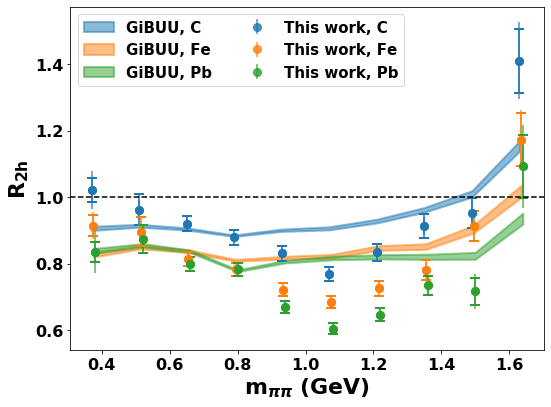

In [32]:
fig = plt.figure(figsize=(8,6))
colorBands=['black','#1f77b4','#ff7f0e','#2ca02c']
sysErr=sysErr_mass
for i,target in enumerate(['C','Fe','Pb']):
    r, err,x = r2h.getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target], 
                        df_trigger['D_%s_trigger'%target],variable='pair_mass',
                            minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,
                            pair_cut='%s and h2_z>0.05 and h2_z<0.45'%pair_cut_nom,
                            trig_cut = '%s '%trigger_cut_nom, applyweight=False)
    plt.errorbar(x+0.005*i,r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',alpha=0.8,color=colors[target])
    plt.errorbar(x+0.005*i,r,yerr=r*(sysErr[target]/100),fmt='o',ms=8,capthick=2,capsize=5,color=colorBands[i+1])
    
    #plt.fill_between(x+0.02*i,r*1.04,r*0.96, alpha=0.2,color=colors[target])
    
    ##GiBUU
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger'],variable='pair_mass',
                            minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,
                            pair_cut='and h2_z>0.05 and h2_z<0.45', trig_cut='h1_z>0.5',applyweight=False)
    #plt.fill_between(x,r,r-err,r+err,label='GiBUU %s'%target,alpha=0.5)
    #plt.plot(x+0.005*i,r,color=colors[target],lw=3,alpha=0.8,label='GiBUU %s'%target)
    plt.fill_between(x+0.005*i,r-err,r+err,label='GiBUU, %s'%target,alpha=0.5,lw=2,color=colors[target])

plt.tick_params(axis="x", labelsize=16)
plt.tick_params(axis="y", labelsize=16)
plt.legend(frameon=True,ncol=2,loc='upper left',fontsize=15)
plt.xlabel('m$_{\pi\pi}$ (GeV)',fontsize=22,fontweight='bold' )
plt.ylabel('R$_{\mathrm{2h}}$',fontsize=22,fontweight='bold')
plt.axhline(y=1.0,color='black',linestyle='--')
#plt.grid(True, axis='x',color='gainsboro', linestyle='dashed')
#plt.grid(True, axis='y',color='gainsboro', linestyle='dashed')

#plt.text(0.60, 1.1, 'CLAS \nINTERNAL', fontsize=30)
#plt.xscale('log')
#plt.ylim([0.0,1.2])
plt.tight_layout()
##plt.savefig('MainResult_withGiBUU_mass.png')

#for paper
outname='DipionMass_comp2'
if not os.path.isdir(outdir):
    os.mkdir(outdir)
plt.savefig(outdir+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir+outname+'.png', bbox_inches='tight')


In [ ]:
fig = plt.figure(figsize=(8,6))

for i,target in enumerate(['C','Fe','Pb']):

    ##GiBUU
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger'],variable='pair_mass',
                            minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,
                            pair_cut='and h2_z>0.10 ',
                            trig_cut='h1_z>0.5 ',applyweight=False)
    #plt.fill_between(x,r,r-err,r+err,label='GiBUU %s'%target,alpha=0.5)
    #plt.plot(x+0.005*i,r,color=colors[target],lw=3,alpha=0.8,label='GiBUU %s'%target)
    plt.fill_between(x+0.00*i,r-err,r+err,label='GiBUU, %s'%target,alpha=0.5,lw=2,color=colors[target])

plt.tick_params(axis="x", labelsize=16)
plt.tick_params(axis="y", labelsize=16)
plt.legend(frameon=False,ncol=1,loc='upper left',fontsize=15)
plt.xlabel('m$_{\pi\pi}$ (GeV)',fontsize=22,fontweight='bold' )
plt.ylabel('R$_{2\mathrm{h}}$',fontsize=22,fontweight='bold')
plt.axhline(y=1.0,color='black',linestyle='--')
#plt.grid(True, axis='x',color='gainsboro', linestyle='dashed')
#plt.grid(True, axis='y',color='gainsboro', linestyle='dashed')

#plt.text(0.60, 1.1, 'CLAS \nINTERNAL', fontsize=30)
#plt.xscale('log')
#plt.ylim([0.0,1.2])
plt.tight_layout()
##plt.savefig('MainResult_withGiBUU_mass.png')

outname='r2h_dipionMass_GiBUU_only'
if not os.path.isdir(outdir_intro):    os.mkdir(outdir_intro)
plt.savefig(outdir_intro+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_intro+outname+'.png', bbox_inches='tight')



In [ ]:
fig, axs = plt.subplots(3, 3,sharex=True, sharey=True,figsize=(14,8),gridspec_kw={'hspace': 0., 'wspace':0.})


# Comparing all pairs with ($\pi^{+}$$\pi^{-}$) and ($\pi^{-}$$\pi^{+}$) pairs. 
**Format is (trigger/secondary)**

**All pairs and +- and -+ R2h results for the 3 variables**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.7000

Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5
Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5
Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5
Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211and h1_pid==211 and h2_pid==-211
Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211and h1_pid==211 and h2_pid==-211
Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211and h1_pid==211 and h2_pid==-211
Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h1_pid==-211 and h2_pid==211
Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h1_pid==-211 and h2_pid==211
Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h1_pid==-211 and h2_pid==211
Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.1395

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.7000

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==-211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==-211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h2_z>0.1  and h2_z<0.5 and h1_pid==-211 and h2_pid==211
Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h2_z>0.1  and h2_z<0.5 and h1_pid==-211 and h2_pid==211


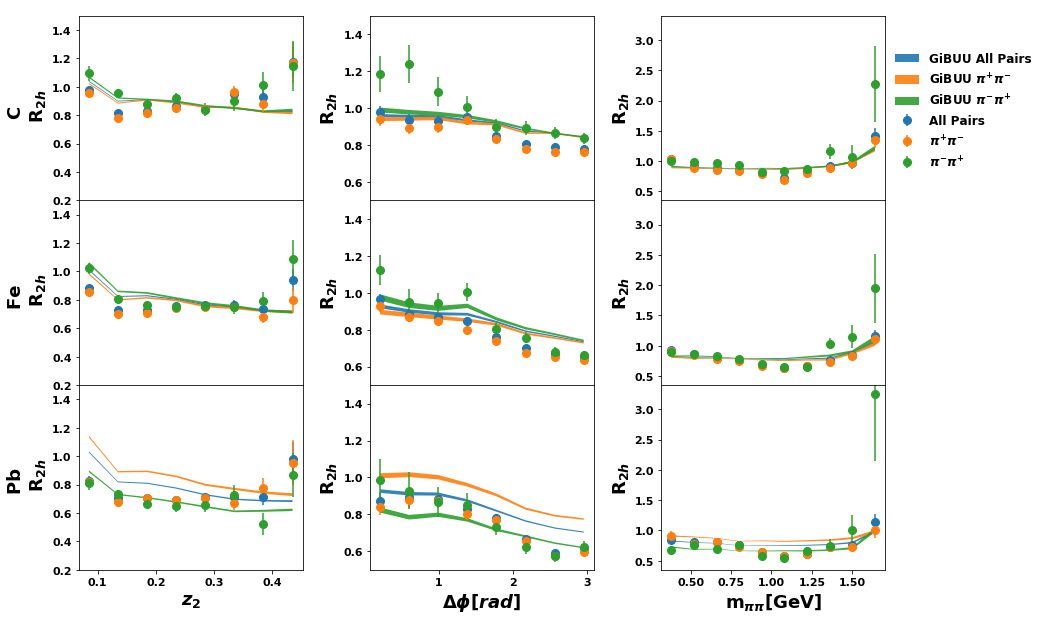

In [82]:
fig, axs = plt.subplots(3, 3,sharex=False, sharey=False,figsize=(14,9),gridspec_kw={'hspace': 0., 'wspace':0.3})

for i,target in enumerate(['C','Fe','Pb']):
    r, err,x = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2, nbins=dpionz2Bins, variable='h2_z', 
                            pair_cut = pair_cut_nom,
                            trig_cut = trigger_cut_nom)
    axs[i][0].errorbar(x+0.005*i,r,yerr=err,label='All Pairs'if i == 0 else "",fmt='o',ms=8) 
    
for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2, nbins=dpionz2Bins, variable='h2_z', 
                               pair_cut ='%s and h1_pid==211 and h2_pid==-211'%pair_cut_nom,
                               trig_cut ='%s and h1_pid==211'%trigger_cut_nom )
    axs[i][0].errorbar(x2+0.005*i,r2,yerr=err2,label='$\pi^{+}\pi^{-}$'if i == 0 else "",fmt='o',ms=8) 
    
for i,target in enumerate(['C','Fe','Pb']):    
    r3, err3,x3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2, nbins=dpionz2Bins, variable='h2_z', 
                               pair_cut = '%s and h1_pid==-211 and h2_pid==211'%pair_cut_nom,
                               trig_cut ='%s and h1_pid==-211'%trigger_cut_nom )
    axs[i][0].errorbar(x3+0.005*i,r3,yerr=err3,label='$\pi^{-}\pi^{+}$'if i == 0 else "",fmt='o',ms=8) 
    

 #GiBUU    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,variable='h2_z',minz=minz2,maxz=maxz2, nbins=dpionz2Bins, applyweight=False, 
                            pair_cut = '', trig_cut='h1_z>0.5')
    axs[i][0].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5,label='GiBUU All Pairs'if i == 0 else "")
    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,variable='h2_z',minz=minz2,maxz=maxz2, nbins=dpionz2Bins, applyweight=False, 
                        pair_cut = 'and h1_pid==211 and h2_pid==-211', 
                            trig_cut='h1_z>0.5 and h1_pid==211')
    axs[i][0].fill_between(x+0.005*i,r-err,r+err,label='GiBUU $\pi^{+}\pi^{-}$'if i == 0 else "",alpha=0.9,lw=5)
    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,variable='h2_z',minz=minz2,maxz=maxz2, nbins=dpionz2Bins, applyweight=False, 
                        pair_cut = 'and h1_pid==-211 and h2_pid==211', 
                            trig_cut='h1_z>0.5 and h1_pid==-211')
    axs[i][0].fill_between(x+0.005*i,r-err,r+err,label='GiBUU $\pi^{-}\pi^{+}$'if i == 0 else "",alpha=0.9,lw=5)
    
### Dphi
dphiBins=8

for i,target in enumerate(['C','Fe','Pb']):
    r, err,x = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi, variable='dphi', 
                            pair_cut = '%s and h2_z>0.1  and h2_z<0.5'%pair_cut_nom,
                            trig_cut = trigger_cut_nom, nbins=dpiondphiBins)
    axs[i][1].errorbar(x+0.005*i,r,yerr=err,fmt='o',ms=8) 
    
for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi, variable='dphi', 
                               pair_cut ='%s and h1_pid==211 and h2_pid==-211 and h2_z>0.1  and h2_z<0.5'%pair_cut_nom,
                               trig_cut ='%s and h1_pid==211'%trigger_cut_nom, nbins=dpiondphiBins )
    axs[i][1].errorbar(x2+0.005*i,r2,yerr=err2,fmt='o',ms=8) 
    
for i,target in enumerate(['C','Fe','Pb']):    
    r3, err3,x3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi, variable='dphi', 
                               pair_cut = '%s and h1_pid==-211 and h2_pid==211 and h2_z>0.1  and h2_z<0.5'%pair_cut_nom,
                               trig_cut ='%s and h1_pid==-211'%trigger_cut_nom , nbins=dpiondphiBins)
    axs[i][1].errorbar(x3+0.005*i,r3,yerr=err3,fmt='o',ms=8) 
    

 #GiBUU    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=mindphi,maxz=maxdphi, variable='dphi',  applyweight=False, 
                            pair_cut = 'and h2_z>0.1  and h2_z<0.5', trig_cut='h1_z>0.5', nbins=dpiondphiBins)
    axs[i][1].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)
    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=mindphi,maxz=maxdphi, variable='dphi',  applyweight=False,  nbins=dpiondphiBins,
                        pair_cut = 'and h2_z>0.1  and h2_z<0.5 and h1_pid==211 and h2_pid==-211', 
                            trig_cut='h1_z>0.5 and h1_pid==211')
    axs[i][1].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)
    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=mindphi,maxz=maxdphi, variable='dphi',  applyweight=False,  nbins=dpiondphiBins,
                        pair_cut = 'and h2_z>0.1  and h2_z<0.5 and h1_pid==-211 and h2_pid==211', 
                            trig_cut='h1_z>0.5 and h1_pid==-211')
    axs[i][1].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)



### Inv Mass

for i,target in enumerate(['C','Fe','Pb']):
    r, err,x = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass',
                            pair_cut = '%s and h2_z>0.1 '%pair_cut_nom,
                            trig_cut = trigger_cut_nom)
    axs[i][2].errorbar(x+0.005*i,r,yerr=err,fmt='o',ms=8) 
    
for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass',
                               pair_cut ='%s and h1_pid==211 and h2_pid==-211 and h2_z>0.1 '%pair_cut_nom,
                               trig_cut ='%s and h1_pid==211'%trigger_cut_nom)
    axs[i][2].errorbar(x2+0.005*i,r2,yerr=err2,fmt='o',ms=8) 
    
for i,target in enumerate(['C','Fe','Pb']):    
    r3, err3,x3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass', 
                               pair_cut = '%s and h1_pid==-211 and h2_pid==211 and h2_z>0.1 '%pair_cut_nom,
                               trig_cut ='%s and h1_pid==-211'%trigger_cut_nom )
    axs[i][2].errorbar(x3+0.005*i,r3,yerr=err3,fmt='o',ms=8) 
    

 #GiBUU    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass',  applyweight=False, 
                            pair_cut = 'and h2_z>0.1 ', trig_cut='h1_z>0.5')
    axs[i][2].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)
    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass',  applyweight=False, 
                        pair_cut = 'and h2_z>0.1  and h2_z<0.5 and h1_pid==211 and h2_pid==-211', 
                            trig_cut='h1_z>0.5 and h1_pid==211')
    axs[i][2].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)
    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass',  applyweight=False, 
                        pair_cut = 'and h2_z>0.1  and h2_z<0.5 and h1_pid==-211 and h2_pid==211', 
                            trig_cut='h1_z>0.5 and h1_pid==-211')
    axs[i][2].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)

    
            
axs[2][0].set_xlabel('$z_{2}$',fontsize=18)
axs[2][1].set_xlabel('$\Delta \phi [rad]$',fontsize=18)
axs[2][2].set_xlabel('m$_{\pi\pi}$[GeV]',fontsize=18,fontweight='bold')

axs[0][0].set_ylabel('C \n R$_{2h}$',fontsize=18,fontweight='bold')
axs[1][0].set_ylabel('Fe \n R$_{2h}$',fontsize=18,fontweight='bold')
axs[2][0].set_ylabel('Pb \n R$_{2h}$',fontsize=18,fontweight='bold')

for i in range(1,3):     
    axs[0][i].set_ylabel('R$_{2h}$',fontsize=18,fontweight='bold')
    axs[1][i].set_ylabel('R$_{2h}$',fontsize=18,fontweight='bold')
    axs[2][i].set_ylabel('R$_{2h}$',fontsize=18,fontweight='bold')

axs[0][0].set_ylim([0.4,1.5])
for i in range(3):    
    axs[i][1].set_ylim([0.5,1.5])
    axs[i][0].set_ylim([0.2,1.5])
    axs[i][2].set_ylim([0.35,3.4])
    
#axs[0].set_xlim([0.00,0.5])
for i in range(0,3):    
    #axs[i][0].axhline(y=1.0,color='black',linestyle='--')
    #axs[i].legend(loc='best',frameon=False,fontsize=13.5,ncol=2 )
    #axs[i][0].grid(True, axis='x',color='gainsboro', linestyle='dashed')
    #axs[i][0].grid(True, axis='y',color='gainsboro', linestyle='dashed')
    
    #axs[i][0].tick_params(axis='y', which='major', labelsize=11)
    axs[i][0].tick_params(axis='both', which='major', labelsize=11)    
    axs[i][1].tick_params(axis='both', which='major', labelsize=11)
    axs[i][2].tick_params(axis='both', which='major', labelsize=11)
for i in range(0,3):
    axs[0][i].tick_params(axis='x', which='major', labelsize=0)    
    axs[1][i].tick_params(axis='x', which='major', labelsize=0)    
    
plt.subplots_adjust(right=0.85, top=0.98, left=0.05)
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=12, borderaxespad=0.3, title='\n')
##plt.savefig('ComparisonWithHermes_Linear.png')
#plt.yscale('log')
#plt.savefig('testingR2hPairs.pdf', bbox_inches='tight')
plt.show()

**Considering only the trigger, i.e trigger pi+ means all pairs in which the pi+ is the trigger**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.7000

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==-211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==-211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==-211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h2_z>0.1  and h2_z<0.5 and h1_pid==-211 and abs(h2_pid)==211
Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h2_z>0.1  and h2_z<0.5 and h1_pid==-211 and abs(h2_pid)==211


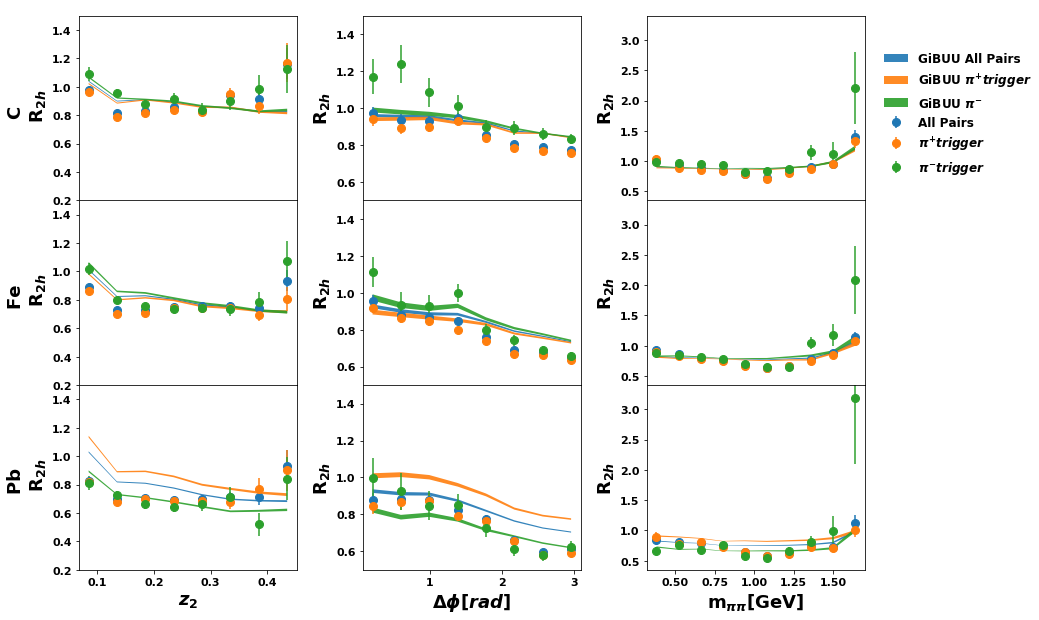

In [45]:
fig, axs = plt.subplots(3, 3,sharex=False, sharey=False,figsize=(14,9),gridspec_kw={'hspace': 0., 'wspace':0.3})

for i,target in enumerate(['C','Fe','Pb']):
    r, err,x = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2, nbins=dpionz2Bins, variable='h2_z', 
                            pair_cut = pair_cut_nom,
                            trig_cut = trigger_cut_nom)
    axs[i][0].errorbar(x+0.005*i,r,yerr=err,label='All Pairs'if i == 0 else "",fmt='o',ms=8) 
    
for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2, nbins=dpionz2Bins, variable='h2_z', 
                               pair_cut ='%s and h1_pid==211 and abs(h2_pid)==211'%pair_cut_nom,
                               trig_cut ='%s and h1_pid==211'%trigger_cut_nom )
    axs[i][0].errorbar(x2+0.005*i,r2,yerr=err2,label='$\pi^{+} trigger$'if i == 0 else "",fmt='o',ms=8) 
    
for i,target in enumerate(['C','Fe','Pb']):    
    r3, err3,x3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2, nbins=dpionz2Bins, variable='h2_z', 
                               pair_cut = '%s and h1_pid==-211 and abs(h2_pid)==211'%pair_cut_nom,
                               trig_cut ='%s and h1_pid==-211'%trigger_cut_nom )
    axs[i][0].errorbar(x3+0.005*i,r3,yerr=err3,label='$\pi^{-} trigger$'if i == 0 else "",fmt='o',ms=8) 
    

 #GiBUU    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,variable='h2_z',minz=minz2,maxz=maxz2, nbins=dpionz2Bins, applyweight=False, 
                            pair_cut = '', trig_cut='h1_z>0.5')
    axs[i][0].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5,label='GiBUU All Pairs'if i == 0 else "")
    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,variable='h2_z',minz=minz2,maxz=maxz2, nbins=dpionz2Bins, applyweight=False, 
                        pair_cut = 'and h1_pid==211 and abs(h2_pid)==211', 
                            trig_cut='h1_z>0.5 and h1_pid==211')
    axs[i][0].fill_between(x+0.005*i,r-err,r+err,label='GiBUU $\pi^{+} trigger$'if i == 0 else "",alpha=0.9,lw=5)
    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,variable='h2_z',minz=minz2,maxz=maxz2, nbins=dpionz2Bins, applyweight=False, 
                        pair_cut = 'and h1_pid==-211 and abs(h2_pid)==211', 
                            trig_cut='h1_z>0.5 and h1_pid==-211')
    axs[i][0].fill_between(x+0.005*i,r-err,r+err,label='GiBUU $\pi^{-}$'if i == 0 else "",alpha=0.9,lw=5)
    
### Dphi
dphiBins=8

for i,target in enumerate(['C','Fe','Pb']):
    r, err,x = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi, variable='dphi', 
                            pair_cut = '%s and h2_z>0.1  and h2_z<0.5'%pair_cut_nom,
                            trig_cut = trigger_cut_nom, nbins=dpiondphiBins)
    axs[i][1].errorbar(x+0.005*i,r,yerr=err,fmt='o',ms=8) 
    
for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi, variable='dphi', 
                               pair_cut ='%s and h1_pid==211 and abs(h2_pid)==211 and h2_z>0.1  and h2_z<0.5'%pair_cut_nom,
                               trig_cut ='%s and h1_pid==211'%trigger_cut_nom, nbins=dpiondphiBins )
    axs[i][1].errorbar(x2+0.005*i,r2,yerr=err2,fmt='o',ms=8) 
    
for i,target in enumerate(['C','Fe','Pb']):    
    r3, err3,x3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi, variable='dphi', 
                               pair_cut = '%s and h1_pid==-211 and abs(h2_pid)==211 and h2_z>0.1  and h2_z<0.5'%pair_cut_nom,
                               trig_cut ='%s and h1_pid==-211'%trigger_cut_nom , nbins=dpiondphiBins)
    axs[i][1].errorbar(x3+0.005*i,r3,yerr=err3,fmt='o',ms=8) 
    

 #GiBUU    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=mindphi,maxz=maxdphi, variable='dphi',  applyweight=False, 
                            pair_cut = 'and h2_z>0.1  and h2_z<0.5', trig_cut='h1_z>0.5', nbins=dpiondphiBins)
    axs[i][1].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)
    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=mindphi,maxz=maxdphi, variable='dphi',  applyweight=False,  nbins=dpiondphiBins,
                        pair_cut = 'and h2_z>0.1  and h2_z<0.5 and h1_pid==211 and abs(h2_pid)==211', 
                            trig_cut='h1_z>0.5 and h1_pid==211')
    axs[i][1].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)
    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=mindphi,maxz=maxdphi, variable='dphi',  applyweight=False,  nbins=dpiondphiBins,
                        pair_cut = 'and h2_z>0.1  and h2_z<0.5 and h1_pid==-211 and abs(h2_pid)==211', 
                            trig_cut='h1_z>0.5 and h1_pid==-211')
    axs[i][1].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)



### Inv Mass

for i,target in enumerate(['C','Fe','Pb']):
    r, err,x = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass',
                            pair_cut = '%s and h2_z>0.1 '%pair_cut_nom,
                            trig_cut = trigger_cut_nom)
    axs[i][2].errorbar(x+0.005*i,r,yerr=err,fmt='o',ms=8) 
    
for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass',
                               pair_cut ='%s and h1_pid==211 and abs(h2_pid)==211 and h2_z>0.1 '%pair_cut_nom,
                               trig_cut ='%s and h1_pid==211'%trigger_cut_nom)
    axs[i][2].errorbar(x2+0.005*i,r2,yerr=err2,fmt='o',ms=8) 
    
for i,target in enumerate(['C','Fe','Pb']):    
    r3, err3,x3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass', 
                               pair_cut = '%s and h1_pid==-211 and abs(h2_pid)==211 and h2_z>0.1 '%pair_cut_nom,
                               trig_cut ='%s and h1_pid==-211'%trigger_cut_nom )
    axs[i][2].errorbar(x3+0.005*i,r3,yerr=err3,fmt='o',ms=8) 
    

 #GiBUU    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass',  applyweight=False, 
                            pair_cut = 'and h2_z>0.1 ', trig_cut='h1_z>0.5')
    axs[i][2].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)
    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass',  applyweight=False, 
                        pair_cut = 'and h2_z>0.1  and h2_z<0.5 and h1_pid==211 and abs(h2_pid)==211', 
                            trig_cut='h1_z>0.5 and h1_pid==211')
    axs[i][2].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)
    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass',  applyweight=False, 
                        pair_cut = 'and h2_z>0.1  and h2_z<0.5 and h1_pid==-211 and abs(h2_pid)==211', 
                            trig_cut='h1_z>0.5 and h1_pid==-211')
    axs[i][2].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)

    
            
axs[2][0].set_xlabel('$z_{2}$',fontsize=18)
axs[2][1].set_xlabel('$\Delta \phi [rad]$',fontsize=18)
axs[2][2].set_xlabel('m$_{\pi\pi}$[GeV]',fontsize=18,fontweight='bold')

axs[0][0].set_ylabel('C \n R$_{2h}$',fontsize=18,fontweight='bold')
axs[1][0].set_ylabel('Fe \n R$_{2h}$',fontsize=18,fontweight='bold')
axs[2][0].set_ylabel('Pb \n R$_{2h}$',fontsize=18,fontweight='bold')

for i in range(1,3):     
    axs[0][i].set_ylabel('R$_{2h}$',fontsize=18,fontweight='bold')
    axs[1][i].set_ylabel('R$_{2h}$',fontsize=18,fontweight='bold')
    axs[2][i].set_ylabel('R$_{2h}$',fontsize=18,fontweight='bold')

axs[0][0].set_ylim([0.4,1.5])
for i in range(3):    
    axs[i][1].set_ylim([0.5,1.5])
    axs[i][0].set_ylim([0.2,1.5])
    axs[i][2].set_ylim([0.35,3.4])
    
#axs[0].set_xlim([0.00,0.5])
for i in range(0,3):    
    #axs[i][0].axhline(y=1.0,color='black',linestyle='--')
    #axs[i].legend(loc='best',frameon=False,fontsize=13.5,ncol=2 )
    #axs[i][0].grid(True, axis='x',color='gainsboro', linestyle='dashed')
    #axs[i][0].grid(True, axis='y',color='gainsboro', linestyle='dashed')
    
    #axs[i][0].tick_params(axis='y', which='major', labelsize=11)
    axs[i][0].tick_params(axis='both', which='major', labelsize=11)    
    axs[i][1].tick_params(axis='both', which='major', labelsize=11)
    axs[i][2].tick_params(axis='both', which='major', labelsize=11)
for i in range(0,3):
    axs[0][i].tick_params(axis='x', which='major', labelsize=0)    
    axs[1][i].tick_params(axis='x', which='major', labelsize=0)    
    
plt.subplots_adjust(right=0.83, top=0.98, left=0.05)
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=12, borderaxespad=0.3, title='\n')
##plt.savefig('ComparisonWithHermes_Linear.png')
#plt.yscale('log')
#plt.savefig('testingR2hPairs_onlyConsideringTriggers.pdf', bbox_inches='tight')
plt.show()

**Same as before but this time with a change in the format**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.7000

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==-211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.7000

Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211and h2_z>0.1  and h2_z<0.5 and h1_pid==211 and abs(h2_pid)==211
Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211and h2_z>0.1  and h2_z<0.5 and h1_pid==211 and abs(h2_pid)==211
Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211and h2_z>0.1  and h2_z<0.5 and h1_pid==211 and abs(h2_pid)==211
Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h2_z>0.1  and h2_z<0.5 and h1_pid==-211 and abs(h2_pid)==211
Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h2_z>0.1  and h2_z<0.5 and h1_pid==-211 and abs(h2_pid)==211
Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h2_z>0.1  and h2_z<0.5 and h1_pid==-211 and abs(h2_pid)==211
Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus=

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==-211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211 and h2_z<0.5 and h1_pid==-211 and abs(h2_pid)==211


PermissionError: [Errno 13] Permission denied: '/home/seba/di-hadron/systematicsPlots_images/R2hPairs_onlyConsideringTriggers_newFormat.pdf'

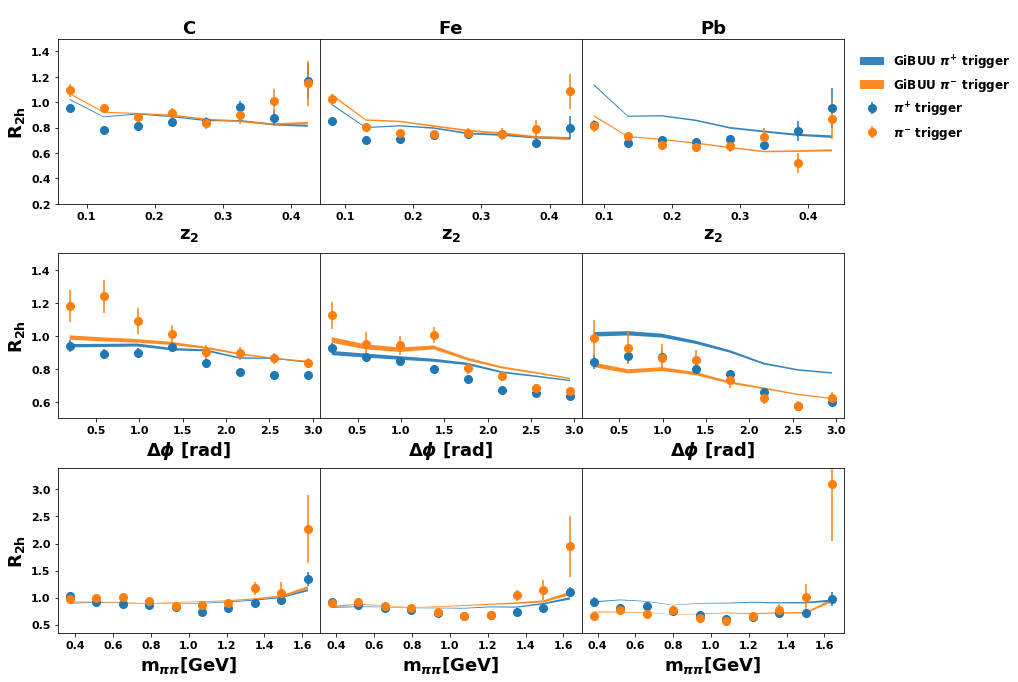

In [83]:
fig, axs = plt.subplots(3, 3,sharex=False, sharey=False,figsize=(14,10),gridspec_kw={'hspace': 0.3, 'wspace':0.})


for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2, nbins=dpionz2Bins, variable='h2_z', 
                               pair_cut ='%s and h1_pid==211 and abs(h2_pid)==211'%pair_cut_nom,
                               trig_cut ='%s and h1_pid==211'%trigger_cut_nom )
    axs[0][i].errorbar(x2+0.005*i,r2,yerr=err2,label='$\pi^{+}$ trigger'if i == 0 else "",fmt='o',ms=8) 
    
for i,target in enumerate(['C','Fe','Pb']):    
    r3, err3,x3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2, nbins=dpionz2Bins, variable='h2_z', 
                               pair_cut = '%s and h1_pid==-211 and abs(h2_pid)==211'%pair_cut_nom,
                               trig_cut ='%s and h1_pid==-211'%trigger_cut_nom )
    axs[0][i].errorbar(x3+0.005*i,r3,yerr=err3,label='$\pi^{-}$ trigger'if i == 0 else "",fmt='o',ms=8) 
    

 #GiBUU    

for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,variable='h2_z',minz=minz2,maxz=maxz2, nbins=dpionz2Bins, applyweight=False, 
                        pair_cut = 'and h1_pid==211 and abs(h2_pid)==211', 
                            trig_cut='h1_z>0.5 and h1_pid==211')
    axs[0][i].fill_between(x+0.005*i,r-err,r+err,label='GiBUU $\pi^{+}$ trigger'if i == 0 else "",alpha=0.9,lw=5)
    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,variable='h2_z',minz=minz2,maxz=maxz2, nbins=dpionz2Bins, applyweight=False, 
                        pair_cut = 'and h1_pid==-211 and abs(h2_pid)==211', 
                            trig_cut='h1_z>0.5 and h1_pid==-211')
    axs[0][i].fill_between(x+0.005*i,r-err,r+err,label='GiBUU $\pi^{-}$ trigger'if i == 0 else "",alpha=0.9,lw=5)
    
### Dphi


for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi, variable='dphi', 
                               pair_cut ='%s and h1_pid==211 and abs(h2_pid)==211 and h2_z>0.1  and h2_z<0.5'%pair_cut_nom,
                               trig_cut ='%s and h1_pid==211'%trigger_cut_nom, nbins=dpiondphiBins )
    axs[1][i].errorbar(x2+0.005*i,r2,yerr=err2,fmt='o',ms=8) 
    
for i,target in enumerate(['C','Fe','Pb']):    
    r3, err3,x3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi, variable='dphi', 
                               pair_cut = '%s and h1_pid==-211 and abs(h2_pid)==211 and h2_z>0.1  and h2_z<0.5'%pair_cut_nom,
                               trig_cut ='%s and h1_pid==-211'%trigger_cut_nom , nbins=dpiondphiBins)
    axs[1][i].errorbar(x3+0.005*i,r3,yerr=err3,fmt='o',ms=8) 
    

 #GiBUU    

for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=mindphi,maxz=maxdphi, variable='dphi',  applyweight=False,  nbins=dpiondphiBins,
                        pair_cut = 'and h2_z>0.1  and h2_z<0.5 and h1_pid==211 and abs(h2_pid)==211', 
                            trig_cut='h1_z>0.5 and h1_pid==211')
    axs[1][i].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)
    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=mindphi,maxz=maxdphi, variable='dphi',  applyweight=False,  nbins=dpiondphiBins,
                        pair_cut = 'and h2_z>0.1  and h2_z<0.5 and h1_pid==-211 and abs(h2_pid)==211', 
                            trig_cut='h1_z>0.5 and h1_pid==-211')
    axs[1][i].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)



### Inv Mass

for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass',
                               pair_cut ='%s and h1_pid==211 and abs(h2_pid)==211  '%pair_cut_nom,
                               trig_cut ='%s and h1_pid==211'%trigger_cut_nom)
    axs[2][i].errorbar(x2+0.005*i,r2,yerr=err2,fmt='o',ms=8) 
    
for i,target in enumerate(['C','Fe','Pb']):    
    r3, err3,x3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass', 
                               pair_cut = '%s and h1_pid==-211 and abs(h2_pid)==211  '%pair_cut_nom,
                               trig_cut ='%s and h1_pid==-211'%trigger_cut_nom )
    axs[2][i].errorbar(x3+0.005*i,r3,yerr=err3,fmt='o',ms=8) 
    

 #GiBUU    

for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass',  applyweight=False, 
                        pair_cut = '  and h2_z<0.5 and h1_pid==211 and abs(h2_pid)==211', 
                            trig_cut='h1_z>0.5 and h1_pid==211')
    axs[2][i].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)
    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass',  applyweight=False, 
                        pair_cut = ' and h2_z<0.5 and h1_pid==-211 and abs(h2_pid)==211', 
                            trig_cut='h1_z>0.5 and h1_pid==-211')
    axs[2][i].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)

           
for i in range(3):    
    axs[0][i].set_xlabel('z$_{2}$',fontsize=18,fontweight='bold')
    axs[1][i].set_xlabel('$\Delta \phi$ [rad]',fontsize=18,fontweight='bold')
    axs[2][i].set_xlabel('m$_{\pi\pi}$[GeV]',fontsize=18,fontweight='bold')

    
axs[0][0].set_title('C',fontsize=18,fontweight='bold')
axs[0][1].set_title('Fe',fontsize=18,fontweight='bold')
axs[0][2].set_title('Pb',fontsize=18,fontweight='bold')
#axs[0][0].set_ylabel('C \n R$_{2h}$',fontsize=18,fontweight='bold')
#axs[1][0].set_ylabel('Fe \n R$_{2h}$',fontsize=18,fontweight='bold')
#axs[2][0].set_ylabel('Pb \n R$_{2h}$',fontsize=18,fontweight='bold')

    
axs[0][0].set_ylabel('R$_{\mathrm{2h}}$',fontsize=18,fontweight='bold')
axs[1][0].set_ylabel('R$_{\mathrm{2h}}$',fontsize=18,fontweight='bold')
axs[2][0].set_ylabel('R$_{\mathrm{2h}}$',fontsize=18,fontweight='bold')
for i in range(3): 
    axs[0][i].set_ylim([0.2,1.5])
    axs[1][i].set_ylim([0.5,1.5])
    axs[2][i].set_ylim([0.35,3.4])

#for i in range(3):    
#    axs[i][1].set_ylim([0.5,1.5])
#    axs[i][0].set_ylim([0.2,1.5])
#    axs[i][2].set_ylim([0.35,3.4])
    
#axs[0].set_xlim([0.00,0.5])
for i in range(0,3):    
    #axs[i][0].axhline(y=1.0,color='black',linestyle='--')
    #axs[i].legend(loc='best',frameon=False,fontsize=13.5,ncol=2 )
    #axs[i][0].grid(True, axis='x',color='gainsboro', linestyle='dashed')
    #axs[i][0].grid(True, axis='y',color='gainsboro', linestyle='dashed')
    
    #axs[i][0].tick_params(axis='y', which='major', labelsize=11)
    axs[i][0].tick_params(axis='both', which='major', labelsize=11)    
    axs[i][1].tick_params(axis='both', which='major', labelsize=11)
    axs[i][2].tick_params(axis='both', which='major', labelsize=11)
for i in range(1,3):
    axs[0][i].yaxis.set_visible(False)    
    axs[1][i].yaxis.set_visible(False)    
    axs[2][i].yaxis.set_visible(False)      

plt.subplots_adjust(right=0.83, top=0.95, left=0.05)
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=12, borderaxespad=0.3, title='\n')
##plt.savefig('ComparisonWithHermes_Linear.png')
#plt.yscale('log')

outname='R2hPairs_onlyConsideringTriggers_newFormat'
if not os.path.isdir(outdir_sys):
    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')



plt.show()

Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211and h1_pid==211 and abs(h2_pid)==211
Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211and h1_pid==211 and abs(h2_pid)==211
Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211and h1_pid==211 and abs(h2_pid)==211
Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h1_pid==-211 and abs(h2_pid)==211
Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h1_pid==-211 and abs(h2_pid)==211
Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h1_pid==-211 and abs(h2_pid)==211
Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211and h2_z>0.1  and h2_z<0.5 and h1_pid==211 and abs(h2_pid)==211
Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211and h2_z>0.1  and h2_z<0.5 and h1_pid==211 and abs(h2_pid)==211
Print Tri

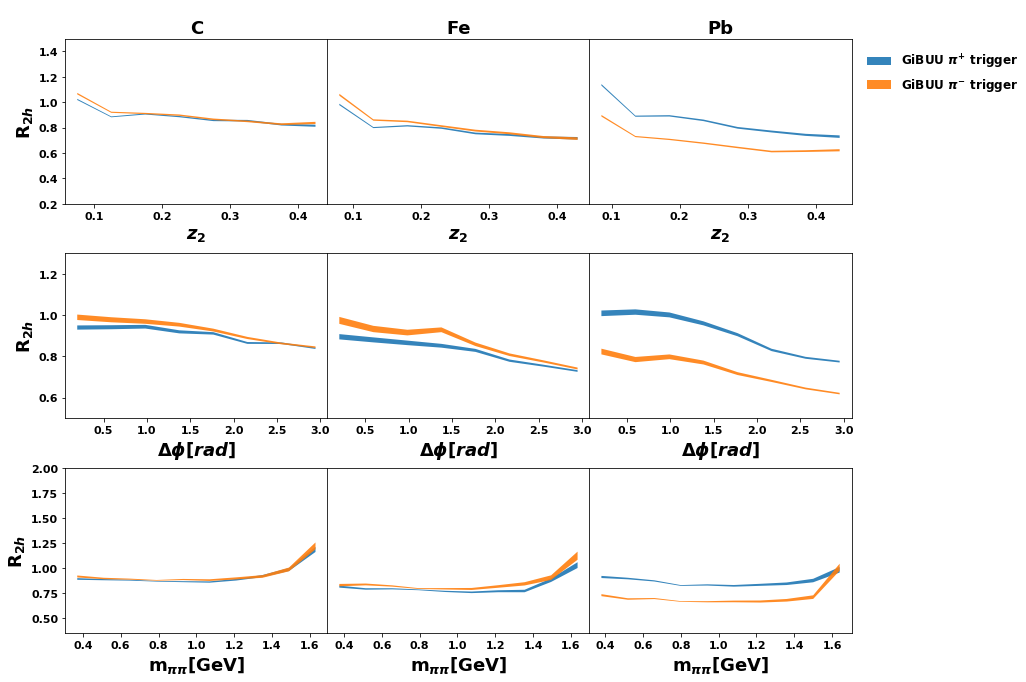

In [47]:
fig, axs = plt.subplots(3, 3,sharex=False, sharey=False,figsize=(14,10),gridspec_kw={'hspace': 0.3, 'wspace':0.})




 #GiBUU    

for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,variable='h2_z',minz=minz2,maxz=maxz2, nbins=dpionz2Bins, applyweight=False, 
                        pair_cut = 'and h1_pid==211 and abs(h2_pid)==211', 
                            trig_cut='h1_z>0.5 and h1_pid==211')
    axs[0][i].fill_between(x+0.005*i,r-err,r+err,label='GiBUU $\pi^{+}$ trigger'if i == 0 else "",alpha=0.9,lw=5)
    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,variable='h2_z',minz=minz2,maxz=maxz2, nbins=dpionz2Bins, applyweight=False, 
                        pair_cut = 'and h1_pid==-211 and abs(h2_pid)==211', 
                            trig_cut='h1_z>0.5 and h1_pid==-211')
    axs[0][i].fill_between(x+0.005*i,r-err,r+err,label='GiBUU $\pi^{-}$ trigger'if i == 0 else "",alpha=0.9,lw=5)
    
### Dphi
dphiBins=8



 #GiBUU    

for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=mindphi,maxz=maxdphi, variable='dphi',  applyweight=False,  nbins=dpiondphiBins,
                        pair_cut = 'and h2_z>0.1  and h2_z<0.5 and h1_pid==211 and abs(h2_pid)==211', 
                            trig_cut='h1_z>0.5 and h1_pid==211')
    axs[1][i].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)
    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=mindphi,maxz=maxdphi, variable='dphi',  applyweight=False,  nbins=dpiondphiBins,
                        pair_cut = 'and h2_z>0.1  and h2_z<0.5 and h1_pid==-211 and abs(h2_pid)==211', 
                            trig_cut='h1_z>0.5 and h1_pid==-211')
    axs[1][i].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)



### Inv Mass

 #GiBUU    

for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass',  applyweight=False, 
                        pair_cut = 'and h2_z>0.1  and h2_z<0.5 and h1_pid==211 and abs(h2_pid)==211', 
                            trig_cut='h1_z>0.5 and h1_pid==211')
    axs[2][i].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)
    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass',  applyweight=False, 
                        pair_cut = 'and h2_z>0.1  and h2_z<0.5 and h1_pid==-211 and abs(h2_pid)==211', 
                            trig_cut='h1_z>0.5 and h1_pid==-211')
    axs[2][i].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)

    
            
for i in range(3):    
    axs[0][i].set_xlabel('$z_{2}$',fontsize=18)
    axs[1][i].set_xlabel('$\Delta \phi [rad]$',fontsize=18)
    axs[2][i].set_xlabel('m$_{\pi\pi}$[GeV]',fontsize=18,fontweight='bold')

    
axs[0][0].set_title('C',fontsize=18,fontweight='bold')
axs[0][1].set_title('Fe',fontsize=18,fontweight='bold')
axs[0][2].set_title('Pb',fontsize=18,fontweight='bold')
#axs[0][0].set_ylabel('C \n R$_{2h}$',fontsize=18,fontweight='bold')
#axs[1][0].set_ylabel('Fe \n R$_{2h}$',fontsize=18,fontweight='bold')
#axs[2][0].set_ylabel('Pb \n R$_{2h}$',fontsize=18,fontweight='bold')

    
axs[0][0].set_ylabel('R$_{2h}$',fontsize=18,fontweight='bold')
axs[1][0].set_ylabel('R$_{2h}$',fontsize=18,fontweight='bold')
axs[2][0].set_ylabel('R$_{2h}$',fontsize=18,fontweight='bold')
for i in range(3): 
    axs[0][i].set_ylim([0.2,1.5])
    axs[1][i].set_ylim([0.5,1.3])
    axs[2][i].set_ylim([0.35,2.0])

#for i in range(3):    
#    axs[i][1].set_ylim([0.5,1.5])
#    axs[i][0].set_ylim([0.2,1.5])
#    axs[i][2].set_ylim([0.35,3.4])
    
#axs[0].set_xlim([0.00,0.5])
for i in range(0,3):    
    #axs[i][0].axhline(y=1.0,color='black',linestyle='--')
    #axs[i].legend(loc='best',frameon=False,fontsize=13.5,ncol=2 )
    #axs[i][0].grid(True, axis='x',color='gainsboro', linestyle='dashed')
    #axs[i][0].grid(True, axis='y',color='gainsboro', linestyle='dashed')
    
    #axs[i][0].tick_params(axis='y', which='major', labelsize=11)
    axs[i][0].tick_params(axis='both', which='major', labelsize=11)    
    axs[i][1].tick_params(axis='both', which='major', labelsize=11)
    axs[i][2].tick_params(axis='both', which='major', labelsize=11)
for i in range(1,3):
    axs[0][i].yaxis.set_visible(False)    
    axs[1][i].yaxis.set_visible(False)    
    axs[2][i].yaxis.set_visible(False)      

plt.subplots_adjust(right=0.83, top=0.95, left=0.05)
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=12, borderaxespad=0.3, title='\n')
##plt.savefig('ComparisonWithHermes_Linear.png')
#plt.yscale('log')
#plt.savefig('R2hPairs_onlyConsideringTriggers_newFormat_tmp.pdf', bbox_inches='tight')
plt.show()

**Ratios +-/-+**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.7000

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==-211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.7000

Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211and h2_z>0.1  and h2_z<0.5 and h1_pid==211 and h2_pid==-211
Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h2_z>0.1  and h2_z<0.5 and h1_pid==-211 and h2_pid==211
Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211and h2_z>0.1  and h2_z<0.5 and h1_pid==211 and h2_pid==-211
Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h2_z>0.1  and h2_z<0.5 and h1_pid==-211 and h2_pid==211
Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211and h2_z>0.1  and h2_z<0.5 and h1_pid==211 and h2_pid==-211
Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h2_z>0.1  and h2_z<0.5 and h1_pid==-211 and h2_pid==211
Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.7000

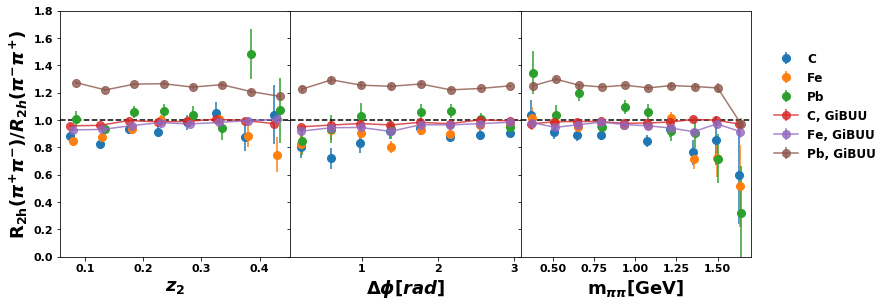

In [48]:
fig, axs = plt.subplots(1, 3,sharex=False, sharey=True,figsize=(12,4),gridspec_kw={'hspace': 0., 'wspace':0.})


for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2, nbins=dpionz2Bins, variable='h2_z', 
                               pair_cut ='%s and h1_pid==211 and h2_pid==-211'%pair_cut_nom,
                               trig_cut ='%s and h1_pid==211'%trigger_cut_nom )
    #axs[i][0].errorbar(x2+0.005*i,r2,yerr=err2,label='$\pi^{+}\pi^{-}$'if i == 0 else "",fmt='o',ms=8) 
    
    
    r3, err3,x3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2, nbins=dpionz2Bins, variable='h2_z', 
                               pair_cut = '%s and h1_pid==-211 and h2_pid==211'%pair_cut_nom,
                               trig_cut ='%s and h1_pid==-211'%trigger_cut_nom )
    #axs[i][0].errorbar(x3+0.005*i,r3,yerr=err3,label='$\pi^{-}\pi^{+}$'if i == 0 else "",fmt='o',ms=8) 
    
    y=r2/r3
    dy=r2/r3*np.hypot(err2/r2, err3,r3)
    axs[0].errorbar(x3+0.005*i,y,yerr=dy,label='%s'%target,fmt='o',ms=8)
    
    
    

 #GiBUU    
    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,variable='h2_z',minz=minz2,maxz=maxz2, nbins=dpionz2Bins, applyweight=False, 
                        pair_cut = 'and h1_pid==211 and h2_pid==-211', 
                            trig_cut='h1_z>0.5 and h1_pid==211')
    #axs[i][0].fill_between(x+0.005*i,r-err,r+err,label='GiBUU $\pi^{+}\pi^{-}$'if i == 0 else "",alpha=0.9,lw=5)
    
    
    r2, err2,x2 = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,variable='h2_z',minz=minz2,maxz=maxz2, nbins=dpionz2Bins, applyweight=False, 
                        pair_cut = 'and h1_pid==-211 and h2_pid==211', 
                            trig_cut='h1_z>0.5 and h1_pid==-211')
    #axs[i][0].fill_between(x+0.005*i,r-err,r+err,label='GiBUU $\pi^{-}\pi^{+}$'if i == 0 else "",alpha=0.9,lw=5)

    
    y=r/r2
    dy=r/r2*np.hypot(err/r, err2,r2)
    axs[0].errorbar(x2+0.005*i,y,yerr=dy,label='%s, GiBUU'%target,fmt='o-',ms=8, alpha=0.8)
    
    #axs[0][0].fill_between(x+0.005*i,r-err,r+err,label='GiBUU $\pi^{-}\pi^{+}$'if i == 0 else "",alpha=0.9,lw=5)
        
    
    
### Dphi

for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi, variable='dphi', 
                               pair_cut ='%s and h1_pid==211 and h2_pid==-211 and h2_z>0.1  and h2_z<0.5'%pair_cut_nom,
                               trig_cut ='%s and h1_pid==211'%trigger_cut_nom, nbins=dpiondphiBins )
    #axs[i][1].errorbar(x2+0.005*i,r2,yerr=err2,fmt='o',ms=8) 
    
    
    r3, err3,x3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi, variable='dphi', 
                               pair_cut = '%s and h1_pid==-211 and h2_pid==211 and h2_z>0.1  and h2_z<0.5'%pair_cut_nom,
                               trig_cut ='%s and h1_pid==-211'%trigger_cut_nom , nbins=dpiondphiBins)
    #xs[i][1].errorbar(x3+0.005*i,r3,yerr=err3,fmt='o',ms=8) 
    y=r2/r3
    dy=r2/r3*np.hypot(err2/r2, err3,r3)
    axs[1].errorbar(x3+0.005*i,y,yerr=dy,fmt='o',ms=8)
    
        

 #GiBUU    

    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=mindphi,maxz=maxdphi, variable='dphi',  applyweight=False,  nbins=dpiondphiBins,
                        pair_cut = 'and h2_z>0.1  and h2_z<0.5 and h1_pid==211 and h2_pid==-211', 
                            trig_cut='h1_z>0.5 and h1_pid==211')
    #axs[i][1].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)
    
    r2, err2,x2 = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=mindphi,maxz=maxdphi, variable='dphi',  applyweight=False,  nbins=dpiondphiBins,
                        pair_cut = 'and h2_z>0.1  and h2_z<0.5 and h1_pid==-211 and h2_pid==211', 
                            trig_cut='h1_z>0.5 and h1_pid==-211')
    #axs[i][1].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)

    y=r/r2
    dy=r/r2*np.hypot(err/r, err2,r2)
    axs[1].errorbar(x2+0.005*i,y,yerr=dy,fmt='o-',ms=8, alpha=0.8)
    
        

### Inv Mass

for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass',
                               pair_cut ='%s and h1_pid==211 and h2_pid==-211 and h2_z>0.1 '%pair_cut_nom,
                               trig_cut ='%s and h1_pid==211'%trigger_cut_nom)
    #axs[i][2].errorbar(x2+0.005*i,r2,yerr=err2,fmt='o',ms=8) 
    
    r3, err3,x3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass', 
                               pair_cut = '%s and h1_pid==-211 and h2_pid==211 and h2_z>0.1 '%pair_cut_nom,
                               trig_cut ='%s and h1_pid==-211'%trigger_cut_nom )
    #axs[i][2].errorbar(x3+0.005*i,r3,yerr=err3,fmt='o',ms=8) 
    y=r2/r3
    dy=r2/r3*np.hypot(err2/r2, err3,r3)
    axs[2].errorbar(x2+0.005*i,y,yerr=dy,fmt='o',ms=8)
    
            

 #GiBUU    

    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass',  applyweight=False, 
                        pair_cut = 'and h2_z>0.1  and h2_z<0.5 and h1_pid==211 and h2_pid==-211', 
                            trig_cut='h1_z>0.5 and h1_pid==211')
    #axs[i][2].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)
    
    r2, err2,x2 = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass',  applyweight=False, 
                        pair_cut = 'and h2_z>0.1  and h2_z<0.5 and h1_pid==-211 and h2_pid==211', 
                            trig_cut='h1_z>0.5 and h1_pid==-211')
    #axs[i][2].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)

    y=r/r2
    dy=r/r2*np.hypot(err/r, err2,r2)
    axs[2].errorbar(x2+0.005*i,y,yerr=dy,fmt='o-',ms=8, alpha=0.8)
        
            
axs[0].set_xlabel('$z_{2}$',fontsize=18)
axs[1].set_xlabel('$\Delta \phi [rad]$',fontsize=18)
axs[2].set_xlabel('m$_{\pi\pi}$[GeV]',fontsize=18,fontweight='bold')

axs[0].set_ylabel('R$_{2\mathrm{h}}(\pi^{+}\pi^{-}) / R_{2h}(\pi^{-}\pi^{+})$',fontsize=18,fontweight='bold')


axs[0].set_ylim([0.0,1.8])

#axs[0].set_xlim([0.00,0.5])

  
for i in range(3):    axs[i].axhline(y=1.0,color='black',linestyle='--')

    #axs[i].legend(loc='best',frameon=False,fontsize=13.5,ncol=2 )
    #axs[i][0].grid(True, axis='x',color='gainsboro', linestyle='dashed')
    #axs[i][0].grid(True, axis='y',color='gainsboro', linestyle='dashed')
    
    #axs[i][0].tick_params(axis='y', which='major', labelsize=11)
axs[0].tick_params(axis='both', which='major', labelsize=11)    
axs[1].tick_params(axis='both', which='major', labelsize=11)
axs[2].tick_params(axis='both', which='major', labelsize=11)

plt.subplots_adjust(right=0.85, top=0.98, left=0.05)
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=12, borderaxespad=0.3, title='\n')
##plt.savefig('ComparisonWithHermes_Linear.png')
#plt.yscale('log')
#plt.savefig('R2hPairs_ratio.pdf', bbox_inches='tight')
plt.show()

**Considering only the trigger, i.e trigger pi+ means all pairs in which the pi+ is the trigger**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.7000

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==-211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==211 and h1_cm_pt**2>0.005
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.

Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h2_z>0.05  and h2_z<0.45 and h1_pid==-211 and abs(h2_pid)==211
Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211and h2_z>0.05  and h2_z<0.45 and h1_pid==211 and abs(h2_pid)==211
Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h2_z>0.05  and h2_z<0.45 and h1_pid==-211 and abs(h2_pid)==211
Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211and h2_z>0.05  and h2_z<0.45 and h1_pid==211 and abs(h2_pid)==211
Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h2_z>0.05  and h2_z<0.45 and h1_pid==-211 and abs(h2_pid)==211
Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==-211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211and h2_z>0.05  and h2_z<0.45 and h1_pid==211 and abs(h2_pid)==211
Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h2_z>0.05  and h2_z<0.45 and h1_pid==-211 and abs(h2_pid)==211


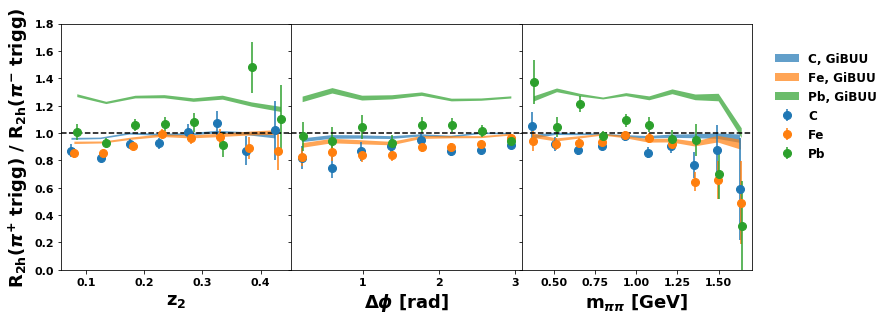

In [157]:
fig, axs = plt.subplots(1, 3,sharex=False, sharey=True,figsize=(12,4),gridspec_kw={'hspace': 0., 'wspace':0.})


for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2, nbins=dpionz2Bins, variable='h2_z', 
                               pair_cut ='%s and h1_pid==211 and abs(h2_pid)==211'%pair_cut_nom,
                               trig_cut ='%s and h1_pid==211'%trigger_cut_nom )
    #axs[i][0].errorbar(x2+0.005*i,r2,yerr=err2,label='$\pi^{+}\pi^{-}$'if i == 0 else "",fmt='o',ms=8) 
    
    r3, err3,x3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2, nbins=dpionz2Bins, variable='h2_z', 
                               pair_cut = '%s and h1_pid==-211 and abs(h2_pid)==211'%pair_cut_nom,
                               trig_cut ='%s and h1_pid==-211'%trigger_cut_nom )
    #axs[i][0].errorbar(x3+0.005*i,r3,yerr=err3,label='$\pi^{-}\pi^{+}$'if i == 0 else "",fmt='o',ms=8) 
    
    y=r2/r3
    dy=r2/r3*np.hypot(err2/r2, err3,r3)
    axs[0].errorbar(x3+0.005*i,y,yerr=dy,label='%s'%target,fmt='o',ms=8)

 #GiBUU    
    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,variable='h2_z',minz=minz2,maxz=maxz2, nbins=dpionz2Bins, applyweight=False, 
                        pair_cut = 'and h1_pid==211 and abs(h2_pid)==211', 
                            trig_cut='h1_z>0.5 and h1_pid==211')
    #axs[i][0].fill_between(x+0.005*i,r-err,r+err,label='GiBUU $\pi^{+}\pi^{-}$'if i == 0 else "",alpha=0.9,lw=5)
    
    
    r2, err2,x2 = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,variable='h2_z',minz=minz2,maxz=maxz2, nbins=dpionz2Bins, applyweight=False, 
                        pair_cut = 'and h1_pid==-211 and abs(h2_pid)==211', 
                            trig_cut='h1_z>0.5 and h1_pid==-211')
    #axs[i][0].fill_between(x+0.005*i,r-err,r+err,label='GiBUU $\pi^{-}\pi^{+}$'if i == 0 else "",alpha=0.9,lw=5)

    y=r/r2
    dy=r/r2*np.hypot(err/r, err2,r2)
    #axs[0].errorbar(x2+0.005*i,y,yerr=dy,label='%s, GiBUU'%target,fmt='o-',ms=8, alpha=0.8)
    axs[0].fill_between(x2+0.005*i,y-dy,y+dy,alpha=0.7,lw=5,label='%s, GiBUU'%target)
    #axs[0][0].fill_between(x+0.005*i,r-err,r+err,label='GiBUU $\pi^{-}\pi^{+}$'if i == 0 else "",alpha=0.9,lw=5)

### Dphi

for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi, variable='dphi', 
                               pair_cut ='%s and h1_pid==211 and abs(h2_pid)==211 and h2_z>0.05  and h2_z<0.45 and h2_cm_pt**2>0.005'%pair_cut_nom,
                               trig_cut ='%s and h1_pid==211 and h1_cm_pt**2>0.005'%trigger_cut_nom, nbins=dpiondphiBins )
    #axs[i][1].errorbar(x2+0.005*i,r2,yerr=err2,fmt='o',ms=8) 
    
    
    r3, err3,x3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi, variable='dphi', 
                               pair_cut = '%s and h1_pid==-211 and abs(h2_pid)==211 and h2_z>0.05  and h2_z<0.45 and h2_cm_pt**2>0.005'%pair_cut_nom,
                               trig_cut ='%s and h1_pid==-211 and h1_cm_pt**2>0.005'%trigger_cut_nom , nbins=dpiondphiBins)
    #xs[i][1].errorbar(x3+0.005*i,r3,yerr=err3,fmt='o',ms=8) 
    y=r2/r3
    dy=r2/r3*np.hypot(err2/r2, err3,r3)
    axs[1].errorbar(x3+0.005*i,y,yerr=dy,fmt='o',ms=8)

 #GiBUU    

for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=mindphi,maxz=maxdphi, variable='dphi',  applyweight=False,  nbins=dpiondphiBins,
                        pair_cut = 'and h2_z>0.05  and h2_z<0.45 and h1_pid==211 and abs(h2_pid)==211', 
                            trig_cut='h1_z>0.5 and h1_pid==211')
    #axs[i][1].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)
    
    r2, err2,x2 = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=mindphi,maxz=maxdphi, variable='dphi',  applyweight=False,  nbins=dpiondphiBins,
                        pair_cut = 'and h2_z>0.05  and h2_z<0.45 and h1_pid==-211 and abs(h2_pid)==211', 
                            trig_cut='h1_z>0.5 and h1_pid==-211')
    #axs[i][1].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)

    y=r/r2
    dy=r/r2*np.hypot(err/r, err2,r2)
    axs[1].fill_between(x2+0.005*i,y-dy,y+dy,alpha=0.7,lw=5)
    #axs[1].errorbar(x2+0.005*i,y,yerr=dy,fmt='o-',ms=8, alpha=0.8)

### Inv Mass

for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass',
                               pair_cut ='%s and h1_pid==211 and abs(h2_pid)==211 and h2_z>0.05 and h2_z<0.45'%pair_cut_nom,
                               trig_cut ='%s and h1_pid==211'%trigger_cut_nom)
    #axs[i][2].errorbar(x2+0.005*i,r2,yerr=err2,fmt='o',ms=8) 
    
    r3, err3,x3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass', 
                               pair_cut = '%s and h1_pid==-211 and abs(h2_pid)==211 and h2_z>0.05 and h2_z<0.45 '%pair_cut_nom,
                               trig_cut ='%s and h1_pid==-211'%trigger_cut_nom )
    #axs[i][2].errorbar(x3+0.005*i,r3,yerr=err3,fmt='o',ms=8) 
    y=r2/r3
    dy=r2/r3*np.hypot(err2/r2, err3,r3)
    axs[2].errorbar(x2+0.005*i,y,yerr=dy,fmt='o',ms=8)

 #GiBUU    

    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass',  applyweight=False, 
                        pair_cut = 'and h2_z>0.05  and h2_z<0.45 and h1_pid==211 and abs(h2_pid)==211', 
                            trig_cut='h1_z>0.5 and h1_pid==211')
    #axs[i][2].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)
    
    r2, err2,x2 = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass',  applyweight=False, 
                        pair_cut = 'and h2_z>0.05  and h2_z<0.45 and h1_pid==-211 and abs(h2_pid)==211', 
                            trig_cut='h1_z>0.5 and h1_pid==-211')
    y=r/r2
    dy=r/r2*np.hypot(err/r, err2,r2)
    axs[2].fill_between(x2+0.005*i,y-dy,y+dy,alpha=0.7,lw=5)
    #axs[2].errorbar(x2+0.005*i,y,yerr=dy,fmt='-',ms=8, alpha=0.8)
        
            
axs[0].set_xlabel('z$_{2}$',fontsize=18,fontweight='bold')
axs[1].set_xlabel('$\Delta \phi$ [rad]',fontsize=18,fontweight='bold')
axs[2].set_xlabel('m$_{\pi\pi}$ [GeV]',fontsize=18,fontweight='bold')

axs[0].set_ylabel('R$_{\mathrm{2h}}$($\pi^{+}$ trigg) / R$_{\mathrm{2h}}$($\pi^{-}$ trigg)',fontsize=18,fontweight='bold')
axs[0].set_ylim([0.0,1.8])

#axs[0].set_xlim([0.00,0.5])

for i in range(3):    axs[i].axhline(y=1.0,color='black',linestyle='--')

    #axs[i].legend(loc='best',frameon=False,fontsize=13.5,ncol=2 )
    #axs[i][0].grid(True, axis='x',color='gainsboro', linestyle='dashed')
    #axs[i][0].grid(True, axis='y',color='gainsboro', linestyle='dashed')
    
    #axs[i][0].tick_params(axis='y', which='major', labelsize=11)
axs[0].tick_params(axis='both', which='major', labelsize=11)    
axs[1].tick_params(axis='both', which='major', labelsize=11)
axs[2].tick_params(axis='both', which='major', labelsize=11)

plt.subplots_adjust(right=0.85, top=0.98, left=0.05)
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=12, borderaxespad=0.3, title='\n')
##plt.savefig('ComparisonWithHermes_Linear.png')
#plt.yscale('log')

outname='R2hPairs_ratio_onlyConsideringTriggers'
if not os.path.isdir(outdir):
    os.mkdir(outdir)
plt.savefig(outdir+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir+outname+'.png', bbox_inches='tight')

plt.show()

**Making the ratio of R2h for charged triggers, for MC (reconstruction)**

Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211 and h1_z>0.5 and h1_pid==211 and abs(h2_pid)==211
Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h1_z>0.5 and h1_pid==-211 and abs(h2_pid)==211
Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211 and h1_z>0.5 and h1_pid==211 and abs(h2_pid)==211
Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h1_z>0.5 and h1_pid==-211 and abs(h2_pid)==211
Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211 and h1_z>0.5 and h1_pid==211 and abs(h2_pid)==211
Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h1_z>0.5 and h1_pid==-211 and abs(h2_pid)==211
Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211 and h1_z>0.5 and h1_pid==211 and abs(h2_pid)==211 and h2_z>0.1  and h2_z<0.5
Print Trigger Cut   h1_z>0.5 and h1_pid==-211
Total Cut  

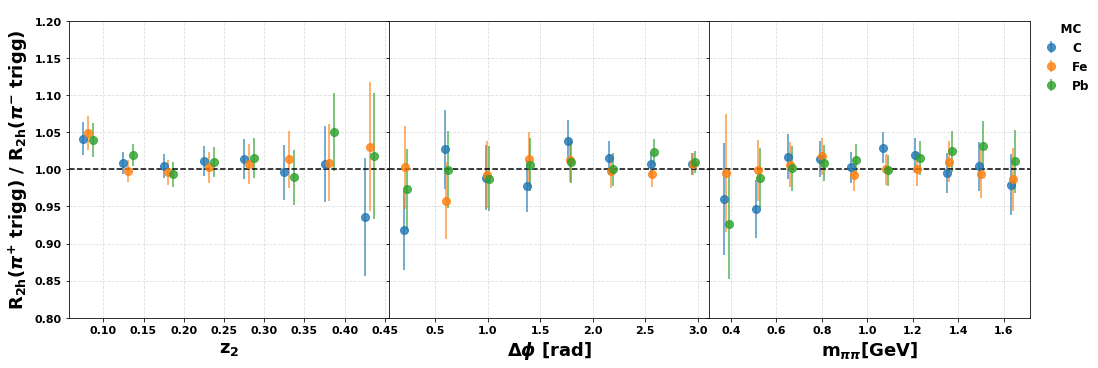

In [50]:
fig, axs = plt.subplots(1, 3,sharex=False, sharey=True,figsize=(15,5),gridspec_kw={'hspace': 0., 'wspace':0.})


for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df_mc['%s'%target], df_mc['D'], 
                        df_mc_trigger['%s_trigger'%target], df_mc_trigger['D_trigger'],
                        minz=minz2,maxz=maxz2, nbins=dpionz2Bins, variable='h2_z', 
                               pair_cut =' and h1_z>0.5 and h1_pid==211 and abs(h2_pid)==211',
                               trig_cut ='h1_z>0.5 and h1_pid==211' )

    
    r3, err3,x3 = r2h.getRatio(df_mc['%s'%target], df_mc['D'], 
                        df_mc_trigger['%s_trigger'%target], df_mc_trigger['D_trigger'],
                        minz=minz2,maxz=maxz2, nbins=dpionz2Bins, variable='h2_z', 
                               pair_cut = 'and h1_z>0.5 and h1_pid==-211 and abs(h2_pid)==211',
                               trig_cut = 'h1_z>0.5 and h1_pid==-211' )
    
    y=r2/r3
    dy=r2/r3*np.hypot(err2/r2, err3,r3)
    axs[0].errorbar(x3+0.006*i,y,yerr=dy,label='%s'%target,fmt='o',ms=8, alpha=0.8)
    
### Dphi

    
for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df_mc['%s'%target], df_mc['D'], 
                        df_mc_trigger['%s_trigger'%target], df_mc_trigger['D_trigger'],
                        minz=mindphi,maxz=maxdphi, variable='dphi', 
                               pair_cut =' and h1_z>0.5 and h1_pid==211 and abs(h2_pid)==211 and h2_z>0.1  and h2_z<0.5',
                               trig_cut ='h1_z>0.5 and h1_pid==211', nbins=dpiondphiBins )
    
    r3, err3,x3 = r2h.getRatio(df_mc['%s'%target], df_mc['D'], 
                        df_mc_trigger['%s_trigger'%target], df_mc_trigger['D_trigger'],
                        minz=mindphi,maxz=maxdphi, variable='dphi', 
                               pair_cut = 'and h1_z>0.5 and h1_pid==-211 and abs(h2_pid)==211 and h2_z>0.1  and h2_z<0.5',
                               trig_cut =' h1_z>0.5 and h1_pid==-211' , nbins=dpiondphiBins)
    y=r2/r3
    dy=r2/r3*np.hypot(err2/r2, err3,r3)
    axs[1].errorbar(x3+0.015*i,y,yerr=dy,fmt='o',ms=8, alpha=0.8)
    
### Inv Mass

for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df_mc['%s'%target], df_mc['D'], 
                        df_mc_trigger['%s_trigger'%target], df_mc_trigger['D_trigger'],
                        minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass',
                               pair_cut =' and h1_z>0.5 and h1_pid==211 and abs(h2_pid)==211 and h2_z>0.1 ',
                               trig_cut ='h1_z>0.5 and h1_pid==211')
    
    r3, err3,x3 = r2h.getRatio(df_mc['%s'%target], df_mc['D'], 
                        df_mc_trigger['%s_trigger'%target], df_mc_trigger['D_trigger'],
                        minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass', 
                               pair_cut = 'and h1_z>0.5 and h1_pid==-211 and abs(h2_pid)==211 and h2_z>0.1 ',
                               trig_cut ='h1_z>0.5 and h1_pid==-211' )
    y=r2/r3
    dy=r2/r3*np.hypot(err2/r2, err3,r3)
    axs[2].errorbar(x2+0.01*i,y,yerr=dy,fmt='o',ms=8, alpha=0.8)
        
axs[0].set_xlabel('z$_{2}$',fontsize=18,fontweight='bold')
axs[1].set_xlabel('$\Delta \phi$ [rad]',fontsize=18,fontweight='bold')
axs[2].set_xlabel('m$_{\pi\pi}$[GeV]',fontsize=18,fontweight='bold')

axs[0].set_ylabel('R$_{\mathrm{2h}}$($\pi^{+}$ trigg) / R$_{\mathrm{2h}}$($\pi^{-}$ trigg)',fontsize=18,fontweight='bold')


axs[0].set_ylim([0.8,1.2])
for i in range(3):
    axs[i].grid(True, axis='x',color='gainsboro', linestyle='dashed')
    axs[i].grid(True, axis='y',color='gainsboro', linestyle='dashed')

for i in range(3):    axs[i].axhline(y=1.0,color='black',linestyle='--')

    #axs[i].legend(loc='best',frameon=False,fontsize=13.5,ncol=2 )
    #axs[i][0].grid(True, axis='x',color='gainsboro', linestyle='dashed')
    #axs[i][0].grid(True, axis='y',color='gainsboro', linestyle='dashed')
    
    #axs[i][0].tick_params(axis='y', which='major', labelsize=11)
axs[0].tick_params(axis='both', which='major', labelsize=11)    
axs[1].tick_params(axis='both', which='major', labelsize=11)
axs[2].tick_params(axis='both', which='major', labelsize=11)

plt.subplots_adjust(right=0.94, top=0.95, left=0.05)
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=12, borderaxespad=0.3, title='  \n    MC ', title_fontsize=12)
##plt.savefig('ComparisonWithHermes_Linear.png')
#plt.yscale('log')

outname='R2hPairs_ratio_onlyConsideringTriggers_MC'
if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')

plt.show()

In [51]:
print(df_trigger.keys())
print(df_trigger['C_trigger'])
#print(df_trigger['GiBUU_D_trigger'])
#df_trigger['GiBUU_Pb_trigger'].query('h1_pid==211').hist(figsize=(10,5),bins=100,column=[ 'h1_pid','h1_z'])
#df_trigger['GiBUU_Pb_trigger'].query('h1_pid==-211').hist(figsize=(10,5),bins=100,column=[ 'h1_pid','h1_z'])
#df_trigger['GiBUU_Pb_trigger'].query('h1_pid==+211').hist(bins=100,column=[ 'h1_pid','h1_z'])

#plt.show()
#nbins=100


#plt.show()

dict_keys(['C_trigger', 'D_C_trigger', 'Fe_trigger', 'D_Fe_trigger', 'Pb_trigger', 'D_Pb_trigger', 'GiBUU_D_trigger', 'GiBUU_C_trigger', 'GiBUU_Fe_trigger', 'GiBUU_Pb_trigger'])
        h1_pid     h1_xf  h1_xf_default      h1_z  h1_cm_pt    h1_rap  \
2          211  0.590588             -1  0.760310  0.348340  1.329085   
6          211  0.187145             -1  0.509437  0.861463  0.286596   
8         -211  0.001607             -1  0.568571  1.070901  0.001821   
11         211  0.430161             -1  0.754712  0.612823  0.656805   
16         211  0.427394             -1  0.681517  0.487444  0.782900   
...        ...       ...            ...       ...       ...       ...   
652682     211  0.416222             -1  0.598139  0.512115  0.859298   
652683     211  0.458048             -1  0.606181  0.450679  1.033055   
652684     211  0.433006             -1  0.644908  0.491112  0.853385   
652688     211  0.439695             -1  0.617135  0.394433  0.999965   
652689     211  0.3

**making the ratio between ($\pi^{+}\pi^{-}$)  and  ($\pi^{-}\pi^{+}$).**
**Also, MC case added**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.7000

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.7000

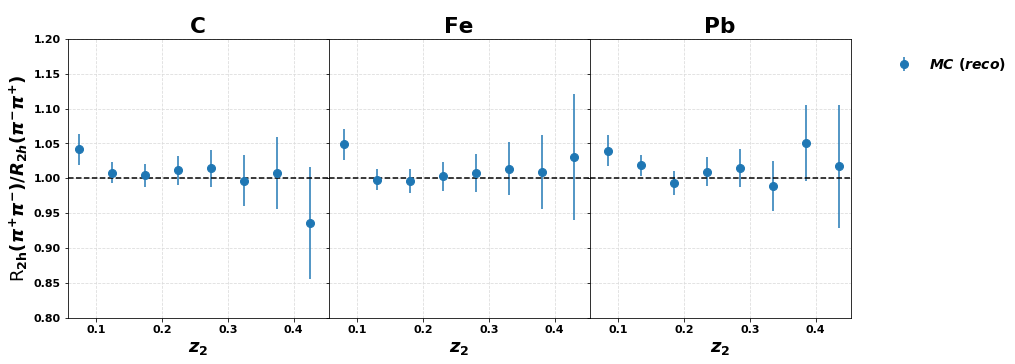

In [52]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,5),gridspec_kw={'hspace': 0., 'wspace':0.})
ratio={}
ratio_err={}
x_coor={}

##Data
for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2, nbins=dpionz2Bins, variable='h2_z', 
                               pair_cut = '%s and h1_pid==211 and h2_pid==-211'%pair_cut_nom,
                               trig_cut='%s and h1_pid==211'%trigger_cut_nom )
    r3, err3,x3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2, nbins=dpionz2Bins, variable='h2_z', 
                               pair_cut = '%s and h1_pid==-211 and h2_pid==211'%pair_cut_nom,
                              trig_cut='%s and h1_pid==-211'%trigger_cut_nom  )
    ratio['%s_data'%target] = r2/r3
    x_coor['%s_data'%target]   =x2 
    ratio_err['%s_data'%target] = (r2/r3)*   np.sqrt( np.power( (err2/r2),2.0) + np.power((err3/r3) ,2.0)   ) 
    
    
    
##GiBUU    
#for i,target in enumerate(['C','Fe','Pb']):    
#    r, err,x = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
#                        df_trigger['GiBUU_D_trigger']
#                       ,variable='h2_z',minz=minz2,maxz=maxz2, nbins=dpionz2Bins, applyweight=False, pair_cut = '')
#    if i==0:    axs[i].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5,label='GiBUU All Pairs')
#    else:    axs[i].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)
for i,target in enumerate(['C','Fe','Pb']):    
    r2_GiBUU, err2_GiBUU,x2_GiBUU = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],
                                             df_trigger['GiBUU_%s_trigger'%target], df_trigger['GiBUU_D_trigger']
                       ,variable='h2_z',minz=minz2,maxz=maxz2, nbins=dpionz2Bins, applyweight=False, 
                        pair_cut = 'and h1_pid==211 and h2_pid==-211',
                                                trig_cut='h1_z>0.5 and  h1_pid==211')
    r3_GiBUU, err3_GiBUU,x3_GiBUU = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],
                                             df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger']
                       ,variable='h2_z',minz=minz2,maxz=maxz2, nbins=dpionz2Bins, applyweight=False, 
                        pair_cut = 'and h1_pid==-211 and h2_pid==211',
                                                 trig_cut='h1_z>0.5 and  h1_pid==-211'        )
    ratio['%s_GiBUU'%target] = r2_GiBUU/r3_GiBUU
    ratio_err['%s_GiBUU'%target] = (r2_GiBUU/r3_GiBUU)*   np.sqrt( np.power( (err2_GiBUU/r2_GiBUU),2.0) + 
                                                                  np.power((err3_GiBUU/r3_GiBUU) ,2.0)   )
## MC
for i,target in enumerate(['C','Fe','Pb']):    
    r2_mc, err2_mc,x2_mc = r2h.getRatio(df_mc['%s'%target],df_mc['D'],
                                             df_mc_trigger['%s_trigger'%target], df_mc_trigger['D_trigger']
                       ,variable='h2_z',minz=minz2,maxz=maxz2, nbins=dpionz2Bins, applyweight=False, 
                        pair_cut = 'and h1_pid==211 and h2_pid==-211',
                                      trig_cut='h1_z>0.5 and  h1_pid==211' )    
    r3_mc, err3_mc,x3_mc = r2h.getRatio(df_mc['%s'%target],df_mc['D'],
                                             df_mc_trigger['%s_trigger'%target], df_mc_trigger['D_trigger']
                       ,variable='h2_z',minz=minz2,maxz=maxz2, nbins=dpionz2Bins, applyweight=False, 
                        pair_cut = 'and h1_pid==-211 and h2_pid==211',
                                       trig_cut='h1_z>0.5 and  h1_pid==-211')     
    ratio['%s_mc'%target] = r2_mc/r3_mc
    ratio_err['%s_mc'%target] = (r2_mc/r3_mc)*   np.sqrt( np.power( (err2_mc/r2_mc),2.0) + 
                                                                  np.power((err3_mc/r3_mc) ,2.0)   )    
    
    
alpha_value=0.5
        
    
for i,target in enumerate(['C','Fe','Pb']): 
    #if True:    
    #    axs[i].errorbar(x_coor['%s_data'%target]+0.005*i,ratio['%s_data'%target],
    #                            yerr=ratio_err['%s_data'%target],label='$Data$'if i == 0 else "",fmt='o',ms=8)
        #axs[i].fill_between(x_coor['%s_data'%target]+0.005*i,ratio['%s_data'%target]-ratio_err['%s_data'%target],
        #                    ratio['%s_data'%target]+ratio_err['%s_data'%target],alpha=alpha_value,lw=5)

    #if True:    
    #    axs[i].errorbar(x_coor['%s_data'%target]+0.005*i,ratio['%s_GiBUU'%target],
    #                            yerr=ratio_err['%s_GiBUU'%target],
    #                            label='$GiBUU$ \n$(model$ $only)$'if i == 0 else "",fmt='o',ms=8)
        #axs[i].fill_between(x_coor['%s_data'%target]+0.005*i,ratio['%s_GiBUU'%target]-ratio_err['%s_GiBUU'%target],
        #                    ratio['%s_GiBUU'%target]+ratio_err['%s_GiBUU'%target],alpha=alpha_value,
        #                    lw=5,label='$GiBUU$ \n$(model$ $only)$',)

    if True:    
        axs[i].errorbar(x_coor['%s_data'%target]+0.005*i,ratio['%s_mc'%target],
                                yerr=ratio_err['%s_mc'%target],
                                label='$MC$ $(reco)$'if i == 0 else "",fmt='o',ms=8)
        #axs[i].fill_between(x_coor['%s_data'%target]+0.005*i,ratio['%s_mc'%target]-ratio_err['%s_mc'%target],
        #                    ratio['%s_mc'%target]+ratio_err['%s_mc'%target],alpha=alpha_value,lw=5, 
        #                    label='$MC$ $(reco)$')

for i in range(3):    axs[i].set_xlabel('$z_{2}$',fontsize=18)

axs[0].set_ylabel('R$_{2\mathrm{h}} (\pi^{+}\pi^{-}) / R_{2h} (\pi^{-}\pi^{+})$',fontsize=18)
axs[0].set_title('C', fontweight='bold')
axs[1].set_title('Fe', fontweight='bold')
axs[2].set_title('Pb', fontweight='bold')


axs[0].set_ylim([0.8,1.2])
#axs[0].set_xlim([0.00,0.5])
for i in range(0,3):    
    axs[i].axhline(y=1.0,color='black',linestyle='--')
    #axs[i].legend(loc='best',frameon=False,fontsize=13.5,ncol=2 )
    axs[i].grid(True, axis='x',color='gainsboro', linestyle='dashed')
    axs[i].grid(True, axis='y',color='gainsboro', linestyle='dashed')
    axs[i].tick_params(axis='y', which='major', labelsize=11)
    axs[i].tick_params(axis='both', which='major', labelsize=11)

plt.subplots_adjust(right=0.85, top=0.9)
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=14, borderaxespad=0.3, title='\n')
##plt.savefig('ComparisonWithHermes_Linear.png')
#plt.yscale('log')
#plt.savefig('ComparisonGiBUUMC_chargedSeparatedPairs_z2.pdf', bbox_inches='tight')
plt.show()

**making the ratio between ($\pi^{+}\pi^{-}$)  and  ($\pi^{-}\pi^{+}$). Just data**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.7000

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.7000

Text(0, 0.5, 'R$_{2\\mathrm{h}} (\\pi^{+}\\pi^{-}) / R_{2h} (\\pi^{-}\\pi^{+})$')

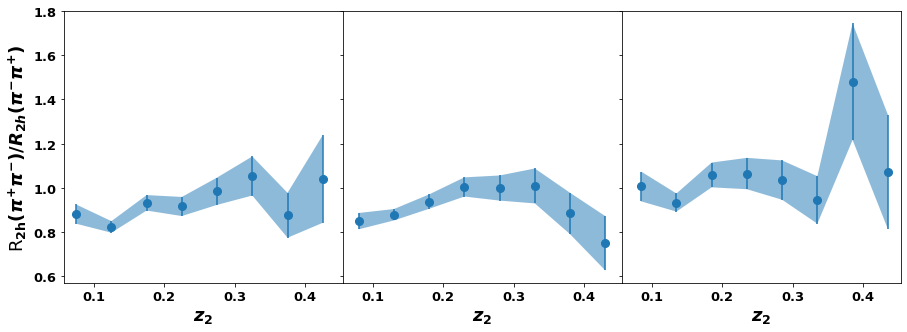

In [53]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,5),gridspec_kw={'hspace': 0., 'wspace':0.})
ratio={}
ratio_err={}
x_coor={}

##Data
for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2, nbins=dpionz2Bins, variable='h2_z', 
                               pair_cut = '%s and h1_pid==211 and h2_pid==-211'%pair_cut_nom,
                               trig_cut='%s and h1_pid==211'%trigger_cut_nom )
    r3, err3,x3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2, nbins=dpionz2Bins, variable='h2_z', 
                               pair_cut = '%s and h1_pid==-211 and h2_pid==211'%pair_cut_nom ,
                              trig_cut='%s and h1_pid==-211'%trigger_cut_nom  )
    ratio['%s_data'%target] = r2/r3
    x_coor['%s_data'%target]   =x2 
    ratio_err['%s_data'%target] = (r2/r3)*   np.sqrt( np.power( (err2/r2),2.0) + np.power((err3/r3) ,2.0)   ) 
    
alpha_value=0.5
        
    
for i,target in enumerate(['C','Fe','Pb']): 
    if i==0:    
        axs[i].errorbar(x_coor['%s_data'%target]+0.005*i,ratio['%s_data'%target],
                                yerr=ratio_err['%s_data'%target],label='$Data$',fmt='o',ms=8)
        axs[i].fill_between(x_coor['%s_data'%target]+0.005*i,ratio['%s_data'%target]-ratio_err['%s_data'%target],
                            ratio['%s_data'%target]+ratio_err['%s_data'%target],alpha=alpha_value,lw=5)
       
    else:      
        axs[i].errorbar(x_coor['%s_data'%target]+0.005*i,ratio['%s_data'%target],
                               yerr=ratio_err['%s_data'%target],fmt='o',ms=8)
        axs[i].fill_between(x_coor['%s_data'%target]+0.005*i,ratio['%s_data'%target]-ratio_err['%s_data'%target],
                            ratio['%s_data'%target]+ratio_err['%s_data'%target],alpha=alpha_value,lw=5)
     
        
for i in range(3):    axs[i].set_xlabel('$z_{2}$',fontsize=18)

axs[0].set_ylabel('R$_{2\mathrm{h}} (\pi^{+}\pi^{-}) / R_{2h} (\pi^{-}\pi^{+})$',fontsize=18)    

# Data/MC comparison distributions

In [54]:
#vars=[]
#n_row=4
#n_col=4
#tar='C'
#tar_mc='Fe'
#nbins=70
#vars=df[tar].keys()
#vars = vars[-16:] ## we select the last 16 variables to plot, from Q2 down below
#print ('There are ', len(df['Fe'].columns), ' in total for ', tar)
#fig, axs = plt.subplots(n_row, n_col,sharex=False, sharey=False,figsize=(14,14),
#                        gridspec_kw={'hspace': 0.4, 'wspace':0.7})
#for j in range(n_row):
#    for i in range(n_col):
#        axs[j,i].hist(df[tar][vars[i+n_col*j]],bins=nbins,alpha=0.5,density=True,
#                      label=' Data'if i+j == 0 else "")
#        axs[j,i].hist(df_mc[tar_mc][vars[i+n_col*j]],bins=nbins,alpha=0.5,density=True,
#                      label='  MC\n(reco)'if i+j == 0 else "")
#        axs[j,i].set_xlabel(vars[i+n_col*j],fontsize=13)
#        axs[j,i].set_ylabel('Entries',fontsize=13)
#        axs[j,i].tick_params(axis='y', which='major', labelsize=8)
#        axs[j,i].tick_params(axis='x', which='major', labelsize=8)
#axs[3,3].set_xlim(-0.1,2.2)
#plt.subplots_adjust(right=0.9, top=1)
#fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n')
##plt.savefig('data_MC_comparison_%s.pdf'%tar, bbox_inches='tight')

In [55]:
tar='D_Fe'
tar_mc='D'
vars=df[tar].keys()
print(vars[-16:])
print(vars)

Index(['h1_Sector', 'h2_Sector', 'h1_FidCutPiPlus', 'h2_FidCutPiPlus',
       'h1_Chi2CC', 'h2_Chi2CC', 'h1_StatCC', 'h2_StatCC', 'evnt',
       'inelasticity', 'h1_e', 'h1_p', 'z_tot', 'h2_e', 'h2_p', 'pair_pt2'],
      dtype='object')
Index(['dphi', 'dphi_lab', 'drap', 'h1_z', 'h2_z', 'h1_cm_pt', 'h2_cm_pt',
       'h1_xf', 'h2_xf', 'h1_rap', 'ycm', 'h2_rap', 'h1_pid', 'h2_pid',
       'h1_cm_ph', 'h2_cm_ph', 'h1_cm_th', 'h2_cm_th', 'pair_mass', 'pair_pt',
       'mx_eh1h2x', 'mx_eh1x', 'mx_eh2x', 't', 'Q2', 'nu', 'W', 'SampFracEl25',
       'SampFracEl20', 'TargTypeSM', 'TargType', 'x', 'u', 'h1_ph', 'h1_th',
       'h2_ph', 'h2_th', 'h1_deltaZ', 'h2_deltaZ', 'h1_Nphe', 'h2_Nphe',
       'h1_Sector', 'h2_Sector', 'h1_FidCutPiPlus', 'h2_FidCutPiPlus',
       'h1_Chi2CC', 'h2_Chi2CC', 'h1_StatCC', 'h2_StatCC', 'evnt',
       'inelasticity', 'h1_e', 'h1_p', 'z_tot', 'h2_e', 'h2_p', 'pair_pt2'],
      dtype='object')


# Mix Events

**data**

In [56]:
%%time
df_mix = {}
#path_data="/home/seba/CreatePairTuples"
path_data="/home/seba/di-hadron/P27"
for target in ['C','Fe','Pb']:
    print ('Getting dataframes from target %s'%target)
    df_mix[target]=getdatainChunks('%s/Pairs_%s.root'%(path_data,target), '%s_mix'%target)
    df_mix['D_%s'%target]= getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 'D_%s_mix'%target)  


Getting dataframes from target C
Getting dataframes from target Fe
Getting dataframes from target Pb
CPU times: user 3.94 s, sys: 111 ms, total: 4.05 s
Wall time: 4.34 s


**Aplying the cuts to mix events**

In [57]:
%%time
for key in df_mix.keys():
    isMC = False
    if 'GiBUU' in key:
        isMC=True
    print ('\nkey: ',key)
    df_mix[key] = r2h.applyCuts(df_mix[key],isMC=isMC)
    df_mix[key] = r2h.applyCutsPair(df_mix[key],isMC=isMC)
    df_mix[key].rename(columns={'h1_FidCut':'h1_FidCutPiPlus'}, inplace=True)
    df_mix[key].rename(columns={'h2_FidCut':'h2_FidCutPiPlus'}, inplace=True)


key:  C
Entries before cut  315010
Q2>1.0 and Q2<4.0 315010  (100.00  %)
0.2<h1_p<5.0  314999  (100.00  %)
inelasticity < 0.85 314999  (100.00  %)
h1_pid = pions (trigger) 314999  (100.00  %)
2.2 < nu <4.2 310231  (98.49  %)
10< h1_th<90 310228  (100.00  %)
Theta/P fiducial region selected for trigger 310228  (100.00  %)
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 310228  (100.00  %)
2.2 < nu < 4.2 310228  (100.00  %)
secondary hadrons are pions 310228  (100.00  %)
(h1_z+h2_z)<1.0 261609  (84.33  %)
(h1_pid*h2_pid)<0, opposite charge pions 96421  (36.86  %)
kinematic limits for h2_z 94564  (98.07  %)
kinematic limits for dphi 94507  (99.94  %)
kinematic limits for pair_mass 93632  (99.07  %)
leading hadrons are pions 93632  (100.00  %)
0.2<h2_p<5.0 89225  (95.29  %)
0.2<h1_p<5.0 89225  (100.00  %)
10<h2_th<90 88699  (99.41  %)
Theta/P fiducial region selected for secondary hadron 39829  (44.90  %)
10< h1_th<90 39829  (100.00  %)
Theta/P fiducial region selected for

In [58]:
#for key in df_trigger.keys():
#    print (key)
#    df_trigger[key] = r2h.applyCuts(df_trigger[key],isTrigger=True)
#    print (' ')
    

In [59]:

print( 'There are ', len(df_mix['Fe'].keys()) , 'variables in mix_tuple')
print(df_mix['C'].keys())

#df_mix['Pb'].hist(figsize=(20,20),bins=100)
#plt.show()


There are  60 variables in mix_tuple
Index(['dphi', 'dphi_lab', 'drap', 'h1_z', 'h2_z', 'h1_cm_pt', 'h2_cm_pt',
       'h1_xf', 'h2_xf', 'h1_rap', 'ycm', 'h2_rap', 'h1_pid', 'h2_pid',
       'h1_cm_ph', 'h2_cm_ph', 'h1_cm_th', 'h2_cm_th', 'pair_mass', 'pair_pt',
       'mx_eh1h2x', 'mx_eh1x', 'mx_eh2x', 't', 'Q2', 'nu', 'W', 'SampFracEl25',
       'SampFracEl20', 'TargTypeSM', 'TargType', 'x', 'u', 'h1_ph', 'h1_th',
       'h2_ph', 'h2_th', 'dphi_norot', 'h2_cm_ph_norot', 'h2_cm_th_norot',
       'h1_deltaZ', 'h2_deltaZ', 'h1_Nphe', 'h2_Nphe', 'h1_Sector',
       'h2_Sector', 'h1_FidCutPiPlus', 'h2_FidCutPiPlus', 'h1_Chi2CC',
       'h2_Chi2CC', 'h1_StatCC', 'h2_StatCC', 'evnt', 'inelasticity', 'h1_e',
       'h1_p', 'z_tot', 'h2_e', 'h2_p', 'pair_pt2'],
      dtype='object')


**MC**

In [60]:
%%time
df_mc_mix = {}
path_mc="/home/seba/CreatePairTuples"

for target in ['C','D', 'Fe','Pb']:
    print ('Getting dataframes from target %s'%target)
    df_mc_mix[target]=getdatainChunks('%s/MC_Pairs_%s.root'%(path_mc,target), '%s_mix'%target)
 

Getting dataframes from target C
Getting dataframes from target D
Getting dataframes from target Fe
Getting dataframes from target Pb
CPU times: user 23.9 s, sys: 1.84 s, total: 25.7 s
Wall time: 27.2 s


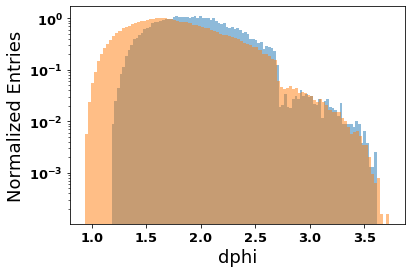

In [61]:
plt.hist(df['Fe']['h1_p'],bins=100,alpha=0.5,density=True,label='Deuterium')
plt.hist(df_mc['Fe']['h1_p'],bins=100,alpha=0.5,density=True,label='Iron') 

plt.yscale('log')
#plt.xlim(100,125)
plt.xlabel('dphi')
plt.ylabel('Normalized Entries')
#plt.legend()
plt.show()

In [62]:
%%time
for key in df_mc_mix.keys():
    isMC = False
    if 'GiBUU' in key:
        isMC=True
    print (key)
    df_mc_mix[key] = r2h.applyCuts(df_mc_mix[key],isMC=isMC)
    df_mc_mix[key] = r2h.applyCutsPair(df_mc_mix[key],isMC=isMC)    
    df_mc_mix[key] = r2h.applyCuts(df_mc_mix[key],isMC=isMC)
    df_mc_mix[key] = r2h.applyCutsPair(df_mc_mix[key],isMC=isMC)
    df_mc_mix[key].rename(columns={'h1_FidCut':'h1_FidCutPiPlus'}, inplace=True)
    df_mc_mix[key].rename(columns={'h2_FidCut':'h2_FidCutPiPlus'}, inplace=True)

C
Entries before cut  3828317
Q2>1.0 and Q2<4.0 3828317  (100.00  %)
0.2<h1_p<5.0  3828311  (100.00  %)
inelasticity < 0.85 3828311  (100.00  %)
h1_pid = pions (trigger) 1513966  (39.55  %)
2.2 < nu <4.2 1493447  (98.64  %)
10< h1_th<90 1493334  (99.99  %)
Theta/P fiducial region selected for trigger 1493334  (100.00  %)
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 1493334  (100.00  %)
2.2 < nu < 4.2 1493334  (100.00  %)
secondary hadrons are pions 953730  (63.87  %)
(h1_z+h2_z)<1.0 557153  (58.42  %)
(h1_pid*h2_pid)<0, opposite charge pions 163245  (29.30  %)
kinematic limits for h2_z 158851  (97.31  %)
kinematic limits for dphi 158776  (99.95  %)
kinematic limits for pair_mass 153569  (96.72  %)
leading hadrons are pions 153569  (100.00  %)
0.2<h2_p<5.0 147034  (95.74  %)
0.2<h1_p<5.0 147034  (100.00  %)
10<h2_th<90 76626  (52.11  %)
Theta/P fiducial region selected for secondary hadron 28961  (37.80  %)
10< h1_th<90 28961  (100.00  %)
Theta/P fiducial region selec

**This is normalized by area not by trigger**

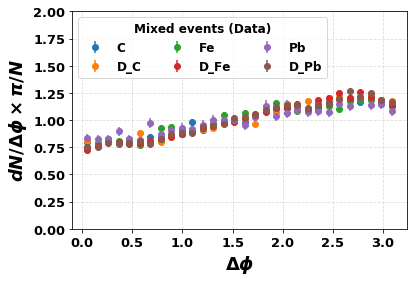

In [63]:
nbins = 30
dys = []
ys = []
for tar in ['C','D_C','Fe','D_Fe','Pb','D_Pb']:
    a=df_mix[tar]['dphi']
    rang=None
    if rang == None:        rang=(min(a),max(a))
    y,x = np.histogram(a,bins=nbins) ## this return the y array of values and the x arrays of bin edges 
    #print(y)
    #print(x)
    #print(x[1] ,' ; ', x[0])
    y = pd.Series(y)
    denom = np.sum(y)*(x[1]-x[0])/(rang[1]-rang[0])
    #print('denom is ',denom)
    #print(rang[1]-rang[0])
    dy = np.sqrt(y)/denom
    y = y/denom
    dys.append(dy)
    ys.append(y)
    x = np.add(x[1:],x[:-1])/2
    plt.errorbar(x,y,dy,linestyle='',marker='o',label=tar)
plt.legend(ncol=3, loc='upper left' ,frameon=True,fontsize=12, title='Mixed events (Data)', title_fontsize=12)
plt.ylim(0.,2.0)
plt.gca().set_xlabel("$\\Delta\\phi$") #gca stands for 'get current axis'
plt.gca().set_ylabel("$dN/\\Delta\\phi \\times \pi/N$") #gca stands for 'get current axis'

plt.grid(b=True, which='both', axis='both',color='gainsboro', linestyle='dashed' )
#plt.savefig('dphi_mixedEvents_comp_data.pdf', bbox_inches='tight')

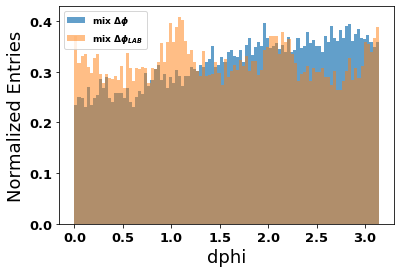

In [64]:
plt.hist(df_mix['Fe']['dphi'],bins=100,alpha=0.7,density=True, label='mix $\Delta \phi$')
plt.hist(df_mix['Fe']['dphi_lab'],bins=100,alpha=0.5,density=True, label='mix $\Delta \phi_{LAB}$')

#plt.yscale('log')
#plt.xlim(100,125)
plt.xlabel('dphi')
plt.ylabel('Normalized Entries')
plt.legend(fontsize=9)
plt.show()

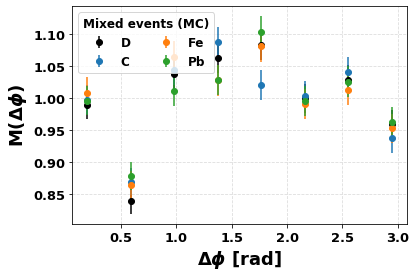

In [65]:

## Here are normalized by the bin average height 
for a,color in zip('D C Fe Pb'.split(),"k tab:blue tab:orange tab:green".split()):
    mix = df_mc_mix[a]
    y,x = np.histogram(mix.query('h2_z>0.1 and h1_z>0.5 and abs(h1_pid)==211 and abs(h2_pid)==211').dphi,bins=dpiondphiBins-1, range=(0,np.pi))
    x = np.add(x[:-1],x[1:])/2
    dy = np.sqrt(y)
    denom = np.mean(y)
    y = np.divide(y,denom)
    dy = np.divide(dy,denom)
    plt.errorbar(x,y,dy,color=color,linestyle='',label=a,marker='o')
plt.legend(ncol=2, loc='upper left' ,frameon=True,fontsize=12, title='Mixed events (MC)', title_fontsize=12)
plt.gca().set_ylabel("M$(\\Delta\\phi)$", fontweight='bold')
plt.gca().set_xlabel("$\\Delta\\phi$ [rad]", fontweight='bold')
plt.grid(axis="x",color='gainsboro', linestyle='dashed')
plt.grid(axis="y",color='gainsboro', linestyle='dashed')

outname='dphi_mixedEvents_comp_MC'
if not os.path.isdir(outdir_sys):
    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')

plt.show()  


**With respect to the lab frame**

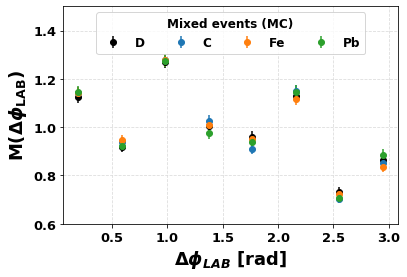

In [66]:
## Here are normalized by the bin average height 
for a,color in zip('D C Fe Pb'.split(),"k tab:blue tab:orange tab:green".split()):
    mix = df_mc_mix[a]
    y,x = np.histogram(mix.query('h2_z>0.1 and h1_z>0.5 and abs(h1_pid)==211 and abs(h2_pid)==211').dphi_lab,bins=dpiondphiBins-1
                       , range=(0,np.pi))
    x = np.add(x[:-1],x[1:])/2
    dy = np.sqrt(y)
    denom = np.mean(y)
    y = np.divide(y,denom)
    dy = np.divide(dy,denom)
    plt.errorbar(x,y,dy,color=color,linestyle='',label=a,marker='o')
plt.legend(ncol=4, loc='upper center' ,frameon=True,fontsize=12, title='Mixed events (MC)', title_fontsize=12)
plt.gca().set_ylabel("M$(\\Delta\\phi_{\mathrm{LAB}})$", fontweight='bold')
plt.ylim(0.6,1.5)
plt.gca().set_xlabel("$\\Delta\\phi_{LAB}$ [rad]", fontweight='bold')
plt.grid(axis="x",color='gainsboro', linestyle='dashed')
plt.grid(axis="y",color='gainsboro', linestyle='dashed')


outname='dphiLAB_mixedEvents_comp_MC'
if not os.path.isdir(outdir_sys):
    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')

plt.show()  


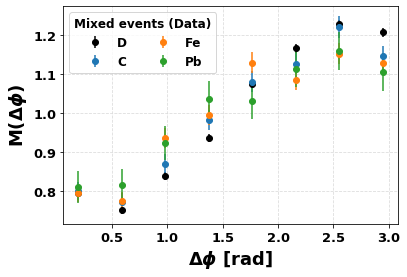

In [67]:
## for data, The D=D_C+D_Fe+D_Pb
deuFrames=[df_mix['D_C'],df_mix['D_Fe'],df_mix['D_Pb']]
df_mix['D']=pd.concat(deuFrames)

for a,color in zip('D C Fe Pb'.split(),"k tab:blue tab:orange tab:green".split()):
    mix = df_mix[a]
    y,x = np.histogram(mix.query('h2_z>0.1 and h1_z>0.5 and abs(h1_pid)==211 and abs(h2_pid)==211 %s'%pair_cut_nom).dphi,bins=dpiondphiBins-1, range=(0,np.pi))
    x = np.add(x[:-1],x[1:])/2
    dy = np.sqrt(y)
    denom = np.mean(y)
    y = np.divide(y,denom)
    dy = np.divide(dy,denom)
    plt.errorbar(x,y,dy,color=color,linestyle='',label=a,marker='o')
plt.legend(ncol=2, loc='upper left' ,frameon=True,fontsize=12, title='Mixed events (Data)', title_fontsize=12)
plt.gca().set_ylabel("M$(\\Delta\\phi)$", fontweight='bold')
plt.gca().set_xlabel("$\\Delta\\phi$ [rad]", fontweight='bold')

#plt.ylim(0.9,1.1)
plt.grid(axis="x",color='gainsboro', linestyle='dashed')
plt.grid(axis="y",color='gainsboro', linestyle='dashed')

outname='dphi_mixedEvents_comp_data'
if not os.path.isdir(outdir_sys):
    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')

plt.show()  


**With respect to the lab frame**

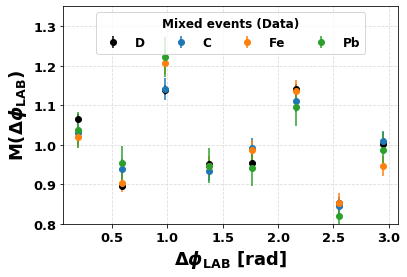

In [68]:
## for data, The D=D_C+D_Fe+D_Pb
deuFrames=[df_mix['D_C'],df_mix['D_Fe'],df_mix['D_Pb']]
df_mix['D']=pd.concat(deuFrames)

for a,color in zip('D C Fe Pb'.split(),"k tab:blue tab:orange tab:green".split()):
    mix = df_mix[a]
    y,x = np.histogram(mix.query('h2_z>0.1 and h1_z>0.5 and abs(h1_pid)==211 and abs(h2_pid)==211 %s'%pair_cut_nom).dphi_lab,bins=dpiondphiBins-1, range=(0,np.pi))
    x = np.add(x[:-1],x[1:])/2
    dy = np.sqrt(y)
    denom = np.mean(y)
    y = np.divide(y,denom)
    dy = np.divide(dy,denom)
    plt.errorbar(x,y,dy,color=color,linestyle='',label=a,marker='o')
plt.legend(ncol=4, loc='upper center' ,frameon=True,fontsize=12, title='Mixed events (Data)', title_fontsize=12)
plt.ylim(0.8,1.35)
plt.gca().set_ylabel("M$(\\Delta\\phi_{\mathrm{LAB}})$", fontweight='bold')
plt.gca().set_xlabel("$\\Delta\\phi_{\mathrm{LAB}}$ [rad]", fontweight='bold')

plt.grid(axis="x",color='gainsboro', linestyle='dashed')
plt.grid(axis="y",color='gainsboro', linestyle='dashed')

outname='dphiLAB_mixedEvents_comp_data'
if not os.path.isdir(outdir_sys):
    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')


plt.show()  


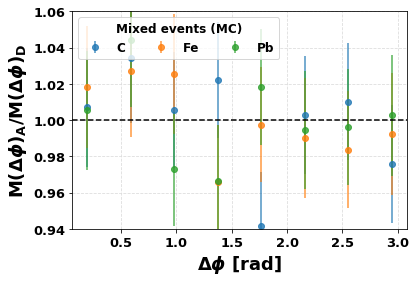

In [69]:
#The ratio of mix events

ys = []
dys = []
x2=[]

for a,color in zip('D C Fe Pb'.split(),"k tab:blue tab:orange tab:green".split()):
    mix = df_mc_mix[a]
    y,x = np.histogram(abs(mix.query('h2_z>0.1 and h1_z>0.5 and abs(h1_pid)==211 and abs(h2_pid)==211').dphi),
                       bins=dpiondphiBins-1, range=(0,np.pi))
    x = np.add(x[:-1],x[1:])/2
    dy = np.sqrt(y)
    denom = np.mean(y)
    ys.append(y)
    dys.append(dy)    
    x2.append(x)
for i,tar in enumerate(['C','Fe','Pb']):
    y = ys[i+1]/ys[0]
    dy = ys[i+1]/ys[0]*np.hypot(dys[0]/ys[0],dys[i+1]/ys[i+1])
    denom = np.average(y)
    y/=denom
    dy/=denom
    plt.errorbar(x2[0],y,dy,linestyle='',marker='o',label=tar,alpha=0.8)

plt.legend(ncol=3, loc='upper left' ,frameon=True,fontsize=12, title='Mixed events (MC)', title_fontsize=12)
plt.gca().set_ylabel("M$(\\Delta\\phi)_{\mathrm{A}}/\mathrm{M}(\\Delta\\phi)_{\mathrm{D}}$", fontweight='bold')
plt.gca().set_xlabel("$\\Delta\\phi$ [rad]", fontweight='bold')
plt.axhline(y=1.0,color='black',linestyle='--')
plt.ylim(0.94,1.06)
plt.grid(axis="x",color='gainsboro', linestyle='dashed')
plt.grid(axis="y",color='gainsboro', linestyle='dashed')

outname='dphi_mixedEvents_comp_MC_ratio'
if not os.path.isdir(outdir_sys):
    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')


plt.show()  


**With respect to the lab frame**

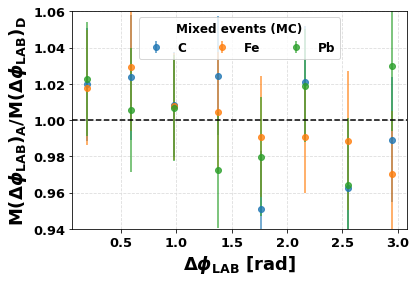

In [70]:
#The ratio of mix events

ys = []
dys = []
x2=[]

for a,color in zip('D C Fe Pb'.split(),"k tab:blue tab:orange tab:green".split()):
    mix = df_mc_mix[a]
    y,x = np.histogram(abs(mix.query('h2_z>0.1 and h1_z>0.5 and abs(h1_pid)==211 and abs(h2_pid)==211').dphi_lab),
                       bins=dpiondphiBins-1, range=(0,np.pi))
    x = np.add(x[:-1],x[1:])/2
    dy = np.sqrt(y)
    denom = np.mean(y)
    ys.append(y)
    dys.append(dy)    
    x2.append(x)
for i,tar in enumerate(['C','Fe','Pb']):
    y = ys[i+1]/ys[0]
    dy = ys[i+1]/ys[0]*np.hypot(dys[0]/ys[0],dys[i+1]/ys[i+1])
    denom = np.average(y)
    y/=denom
    dy/=denom
    plt.errorbar(x2[0],y,dy,linestyle='',marker='o',label=tar,alpha=0.8)

plt.legend(ncol=3, loc='upper center' ,frameon=True,fontsize=12, title='Mixed events (MC)', title_fontsize=12)
plt.gca().set_ylabel("M$(\\Delta\\phi_{\mathrm{LAB}})_{\mathrm{A}}/\mathrm{M}(\\Delta\\phi_{\mathrm{LAB}})_{\mathrm{D}}$", fontweight='bold')
plt.gca().set_xlabel("$\\Delta\\phi_{\mathrm{LAB}}$ [rad]", fontweight='bold')
plt.axhline(y=1.0,color='black',linestyle='--')
plt.ylim(0.94,1.06)
plt.grid(axis="x",color='gainsboro', linestyle='dashed')
plt.grid(axis="y",color='gainsboro', linestyle='dashed')

outname='dphiLAB_mixedEvents_comp_MC_ratio'
if not os.path.isdir(outdir_sys):
    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')


plt.show()  


In [71]:
print(df_mix.keys())

dict_keys(['C', 'D_C', 'Fe', 'D_Fe', 'Pb', 'D_Pb', 'D'])


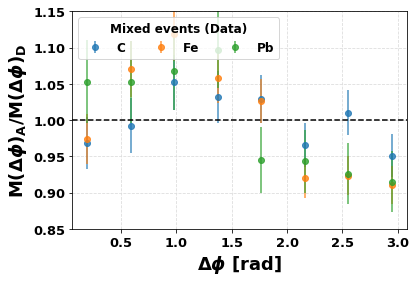

In [72]:
## for data
ys = []
dys = []
x2=[]
for j,a in enumerate(['D_C', 'D_Fe', 'D_Pb', 'C' ,'Fe' ,'Pb']):
    mix = df_mix[a]
    y,x = np.histogram(mix.query('h2_z>0.1 and h1_z>0.5 and abs(h1_pid)==211 and abs(h2_pid)==211 %s'%pair_cut_nom).dphi,
                       bins=dpiondphiBins-1, range=(0,np.pi))
    x = np.add(x[:-1],x[1:])/2
    dy = np.sqrt(y)
    denom = np.mean(y)
    ys.append(y)
    dys.append(dy)    
    x2.append(x)
for i,tar in enumerate(['C','Fe','Pb']):
    y = ys[i+3]/ys[i]
    dy = ys[i+3]/ys[i]*np.hypot(dys[i]/ys[i],dys[i+3]/ys[i+3])
    denom = np.average(y)
    y/=denom
    dy/=denom
    plt.errorbar(x2[0],y,dy,linestyle='',marker='o',label=tar,alpha=0.8)
    
plt.legend(ncol=3, loc='upper left' ,frameon=True,fontsize=12, title='Mixed events (Data)', title_fontsize=12)
plt.gca().set_ylabel("M$(\\Delta\\phi)_{\mathrm{A}}/\mathrm{M}(\\Delta\\phi)_{\mathrm{D}}$", fontweight='bold')
plt.gca().set_xlabel("$\\Delta\\phi$ [rad]", fontweight='bold')
plt.axhline(y=1.0,color='black',linestyle='--')
plt.ylim(0.85,1.15)
plt.grid(axis="x",color='gainsboro', linestyle='dashed')
plt.grid(axis="y",color='gainsboro', linestyle='dashed')


outname='dphi_mixedEvents_comp_Data_ratio'
if not os.path.isdir(outdir_sys):
    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')


plt.show()  


**with respect to lab frame**

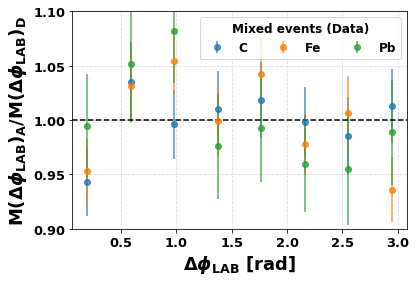

In [73]:
## for data
ys = []
dys = []
x2=[]
for j,a in enumerate(['D_C', 'D_Fe', 'D_Pb', 'C' ,'Fe' ,'Pb']):
    mix = df_mix[a]
    y,x = np.histogram(mix.query('h2_z>0.1 and h1_z>0.5 and abs(h1_pid)==211 and abs(h2_pid)==211 %s'%pair_cut_nom).dphi_lab,
                       bins=dpiondphiBins-1, range=(0,np.pi))
    x = np.add(x[:-1],x[1:])/2
    dy = np.sqrt(y)
    denom = np.mean(y)
    ys.append(y)
    dys.append(dy)    
    x2.append(x)
for i,tar in enumerate(['C','Fe','Pb']):
    y = ys[i+3]/ys[i]
    dy = ys[i+3]/ys[i]*np.hypot(dys[i]/ys[i],dys[i+3]/ys[i+3])
    denom = np.average(y)
    y/=denom
    dy/=denom
    plt.errorbar(x2[0],y,dy,linestyle='',marker='o',label=tar,alpha=0.8)
    
plt.legend(ncol=3, loc='best' ,frameon=True,fontsize=12, title='Mixed events (Data)', title_fontsize=12)
plt.gca().set_ylabel("M$(\\Delta\\phi_{\mathrm{LAB}})_{\mathrm{A}}/\mathrm{M}(\\Delta\\phi_{\mathrm{LAB}})_{\mathrm{D}}$", fontweight='bold')
plt.gca().set_xlabel("$\\Delta\\phi_{\mathrm{LAB}}$ [rad]", fontweight='bold')
plt.axhline(y=1.0,color='black',linestyle='--')

plt.ylim(0.9,1.1)
plt.grid(axis="x",color='gainsboro', linestyle='dashed')
plt.grid(axis="y",color='gainsboro', linestyle='dashed')

outname='dphiLAB_mixedEvents_comp_Data_ratio'
if not os.path.isdir(outdir_sys):
    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')


plt.show()  


Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

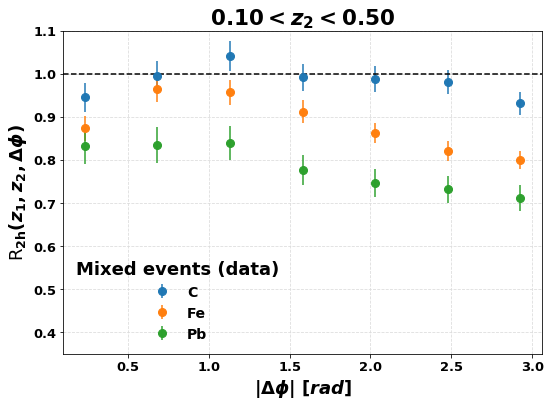

In [74]:
## It's not correct to normalized by the trigger because for the mixed events the normalization must be arbitrary, 
# the particle can be paired with one other particle or 10 or 1000, so it's not clear the normalization

fig = plt.figure(figsize=(8,6))

for j,target in enumerate(['C','Fe','Pb']):
    r, err,x = r2h.getRatio(df_mix['%s'%target], df_mix['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=8,variable='dphi', 
                            pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_nom,
                            trig_cut = trigger_cut_nom )
    plt.errorbar(np.subtract(x,-i*0.005),r,yerr=err,label='%s'%target,ms=8,fmt='o',
                 alpha=0.99,color=colors[target])
    #plt.fill_between(np.subtract(x,-i*0.005), r*0.94,r*1.04, color=colors[target],alpha=0.2)
    

plt.xlabel('$|\Delta\phi|$ $[rad]$',fontsize=18)
plt.ylabel('R$_{2\mathrm{h}} (z_{1},z_{2},\Delta\phi)$',fontsize=18)

#plt.xlim([0.06,0.5])
plt.ylim([0.35,1.1])
plt.title('$0.10 < z_{2} < 0.50$')
plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(loc='best',frameon=False,fontsize=14,ncol=1, title='Mixed events (data)')
plt.grid(True, axis='x',color='gainsboro', linestyle='dashed')
plt.grid(True, axis='y',color='gainsboro', linestyle='dashed')
plt.tight_layout()
##plt.savefig('R2h_DeltaPhi.pdf', bbox_inches='tight')

Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5and h2_z>0.1 and h2_z<0.5
Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5and h2_z>0.1 and h2_z<0.5
Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5and h2_z>0.1 and h2_z<0.5


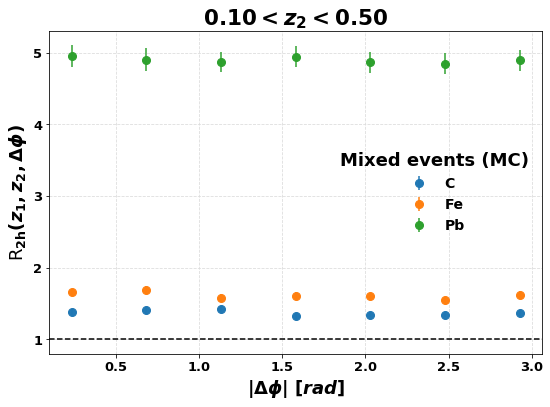

In [75]:
fig = plt.figure(figsize=(8,6))

for j,target in enumerate(['C','Fe','Pb']):
    r, err,x = r2h.getRatio(df_mc_mix['%s'%target], df_mc_mix['D'], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=8,variable='dphi', 
                            pair_cut = 'and h2_z>0.1 and h2_z<0.5',
                            trig_cut = 'h1_z>0.5' )
    plt.errorbar(np.subtract(x,-i*0.005),r,yerr=err,label='%s'%target,ms=8,fmt='o',
                 alpha=0.99,color=colors[target])
    #plt.fill_between(np.subtract(x,-i*0.005), r*0.94,r*1.04, color=colors[target],alpha=0.2)
    

plt.xlabel('$|\Delta\phi|$ $[rad]$',fontsize=18)
plt.ylabel('R$_{2\mathrm{h}} (z_{1},z_{2},\Delta\phi)$',fontsize=18)

#plt.xlim([0.06,0.5])
#plt.ylim([0.35,1.1])
plt.title('$0.10 < z_{2} < 0.50$')
plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(loc='best',frameon=False,fontsize=14,ncol=1, title='Mixed events (MC)')
plt.grid(True, axis='x',color='gainsboro', linestyle='dashed')
plt.grid(True, axis='y',color='gainsboro', linestyle='dashed')
plt.tight_layout()
##plt.savefig('R2h_DeltaPhi.pdf', bbox_inches='tight')

In [147]:
def getMultiplicity(df,df_trigger, variable='h2_z',trig_cut = 'h1_z>0.5', pair_cut='',minz=0.05,maxz=0.5,
                    nbins=9, applyweight=False):
    norm = df_trigger.query(trig_cut).shape[0]
    bins= np.linspace(minz,maxz,nbins)
    y, x    = np.histogram(df.query(pair_cut)[variable],bins=bins)
    erry, x = np.histogram(df.query(pair_cut)[variable],bins=bins)
    x = (x[1:] + x[:-1])/2.0
    err = np.true_divide(np.sqrt(erry),norm)
    y = np.true_divide(y,norm)
    return y,err,x


In [167]:
#Fe won't concatenate with the others because additional fields have been added.  

#df['D'] = pd.concat([df['D_Pb'],df['D_Fe'],df['D_C']])
#df_trigger['D_trigger'] = pd.concat([df_trigger['D_Pb_trigger'],df_trigger['D_Fe_trigger'],df_trigger['D_C_trigger']])

df['D'] = pd.concat([df['D_Pb'],df['D_C']])
df_trigger['D_trigger'] = pd.concat([df_trigger['D_Pb_trigger'],df_trigger['D_C_trigger']])



**Distribution of the Multiplicities, NOT the ratio R2h**

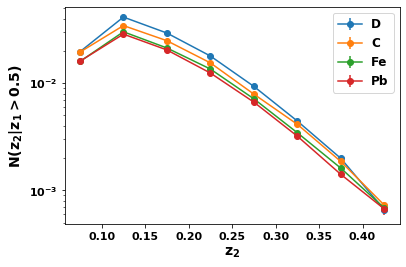

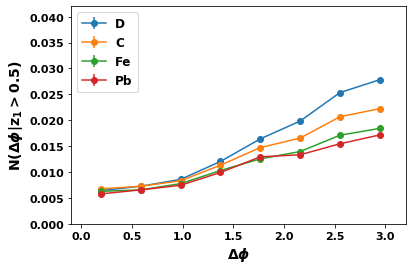

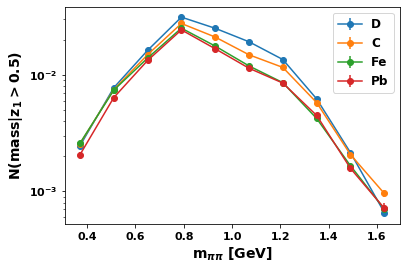

In [168]:
for j,tar in enumerate(['D','C','Fe','Pb']):
    r, err,x = getMultiplicity(df=df[tar],df_trigger=df_trigger['%s_trigger'%tar], variable='h2_z',
                               minz=minz2,maxz=maxz2, nbins=dpionz2Bins,
                               trig_cut='%s'%trigger_cut_nom,
                               pair_cut = 'h1_z>0.5 and h2_z>0.05 and h2_z<0.45 %s '%pair_cut_nom)
    plt.errorbar(x,r,err,linestyle='-',marker='o',label=tar)
                               
plt.legend(ncol=1, loc='best' ,frameon=True,fontsize=12, title='', title_fontsize=12)
#plt.ylim(0.01,0.02)

plt.gca().set_xlabel("z$_{2}$", fontweight='bold', fontsize=14) #gca stands for 'get current axis'
plt.gca().set_ylabel("N(z$_{2}|\mathrm{z}_{1}>0.5)$", fontsize=14, fontweight='bold',) #gca stands for 'get current axis'
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=11)
#plt.grid(b=True, which='both', axis='both',color='gainsboro', linestyle='dashed' )

outname='multiplicity_z2'
if not os.path.isdir(outdir):
    os.mkdir(outdir)
plt.savefig(outdir+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir+outname+'.png', bbox_inches='tight')


plt.show()

for j,tar in enumerate(['D','C','Fe','Pb']):
    r, err,x = getMultiplicity(df=df[tar],df_trigger=df_trigger['%s_trigger'%tar], variable='dphi',
                               minz=mindphi,maxz=maxdphi,nbins=dpiondphiBins,
                               trig_cut='h1_cm_pt**2 > 0.005 and %s'%trigger_cut_nom,
                               pair_cut = 'h1_cm_pt**2 > 0.005 and h2_cm_pt**2 > 0.005 and h1_z>0.5 and h2_z>0.05 and h2_z<0.45 %s '%pair_cut_nom)
    plt.errorbar(x,r,err,linestyle='-',marker='o',label=tar)
                               
plt.legend(ncol=1, loc='best' ,frameon=True,fontsize=12, title='', title_fontsize=12)
plt.ylim(0.0,0.042)
plt.xlim(-0.1,3.2)
plt.gca().set_xlabel("$\\Delta\\phi$", fontsize=14) #gca stands for 'get current axis'
plt.gca().set_ylabel("N$(\Delta \phi|\mathrm{z}_{1}>0.5)$", fontsize=14, fontweight='bold',) #gca stands for 'get current axis'
#plt.yscale('log')
#plt.grid(b=True, which='both', axis='both',color='gainsboro', linestyle='dashed' )
plt.tick_params(axis='both', which='major', labelsize=11)

outname='multiplicity_dphi'
if not os.path.isdir(outdir):
    os.mkdir(outdir)
plt.savefig(outdir+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir+outname+'.png', bbox_inches='tight')

plt.show()

for j,tar in enumerate(['D','C','Fe','Pb']):
    r, err,x = getMultiplicity(df=df[tar],df_trigger=df_trigger['%s_trigger'%tar], variable='pair_mass',
                               minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,
                               trig_cut='%s'%trigger_cut_nom,
                               pair_cut = 'h1_z>0.5 and h2_z>0.05 and h2_z<0.45 %s '%pair_cut_nom)
    
    plt.errorbar(x,r,err,linestyle='-',marker='o',label=tar)
                               
plt.legend(ncol=1, loc='best' ,frameon=True,fontsize=12, title='', title_fontsize=12)
#plt.ylim(0.0003,0.0004)
plt.gca().set_xlabel("m$_{\pi\pi}$ [GeV]", fontweight='bold', fontsize=14) #gca stands for 'get current axis'
plt.gca().set_ylabel("N(mass|z$_{1}>0.5)$", fontsize=14, fontweight='bold') #gca stands for 'get current axis'
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=11)
#plt.grid(b=True, which='both', axis='both',color='gainsboro', linestyle='dashed' )

outname='multiplicity_dipionMass'
if not os.path.isdir(outdir):
    os.mkdir(outdir)
plt.savefig(outdir+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir+outname+'.png', bbox_inches='tight')

plt.show()


**MC case**

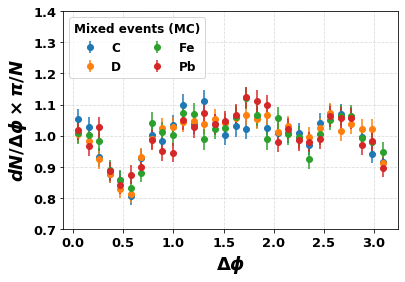

In [79]:
nbins = 30
dys = []
ys = []
for tar in ['C','D','Fe','Pb']:
    a=df_mc_mix[tar]['dphi']
    rang=None
    if rang == None:        rang=(min(a),max(a))
    y,x = np.histogram(a,bins=nbins) ## this return the y array of values and the x arrays of bin edges 
    #print(y)
    #print(x)
    #print(x[1] ,' ; ', x[0])
    y = pd.Series(y)
    denom = np.sum(y)*(x[1]-x[0])/(rang[1]-rang[0])
    #print('denom is ',denom)
    #print(rang[1]-rang[0])
    dy = np.sqrt(y)/denom
    y = y/denom
    dys.append(dy)
    ys.append(y)
    x = np.add(x[1:],x[:-1])/2
    plt.errorbar(x,y,dy,linestyle='',marker='o',label=tar)
plt.legend(ncol=2, loc='upper left' ,frameon=True,fontsize=12, title='Mixed events (MC)', title_fontsize=12)
plt.ylim(0.7,1.4)
plt.gca().set_xlabel("$\\Delta\\phi$") #gca stands for 'get current axis'
plt.gca().set_ylabel("$dN/\\Delta\\phi \\times \pi/N$") #gca stands for 'get current axis'

plt.grid(b=True, which='both', axis='both',color='gainsboro', linestyle='dashed' )
#plt.savefig('dphi_mixedEvents_comp_MC.pdf', bbox_inches='tight')

**Including the ratios Nuclear event-mixed / D event-mixed**

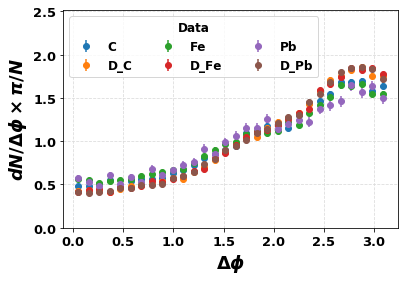

In [80]:
nbins = 30
dys = []
ys = []
for tar in ['C','D_C','Fe','D_Fe','Pb','D_Pb']:
    a=df[tar]['dphi']
    rang=None
    if rang == None:        rang=(min(a),max(a))
    y,x = np.histogram(a,bins=nbins) 
    y = pd.Series(y)
    denom = np.sum(y)*(x[1]-x[0])/(rang[1]-rang[0])
    dy = np.sqrt(y)/denom
    y = y/denom
    dys.append(dy)
    ys.append(y)
    x = np.add(x[1:],x[:-1])/2
    plt.errorbar(x,y,dy,linestyle='',marker='o',label=tar)
plt.legend(ncol=3, loc='upper left' ,frameon=True,fontsize=12, title='Data', title_fontsize=12)
plt.ylim(0.,2.51)
plt.gca().set_xlabel("$\\Delta\\phi$") #gca stands for 'get current axis'
plt.gca().set_ylabel("$dN/\\Delta\\phi \\times \pi/N$") #gca stands for 'get current axis'

plt.grid(b=True, which='both', axis='both',color='gainsboro', linestyle='dashed' )
#plt.savefig('dphi_Events_comp_data.pdf', bbox_inches='tight')

**Study the Xf cut. No notizable difference wrt not applying the cut**

**Xf effect as a a function of pair $z_{2}$**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) an

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) an

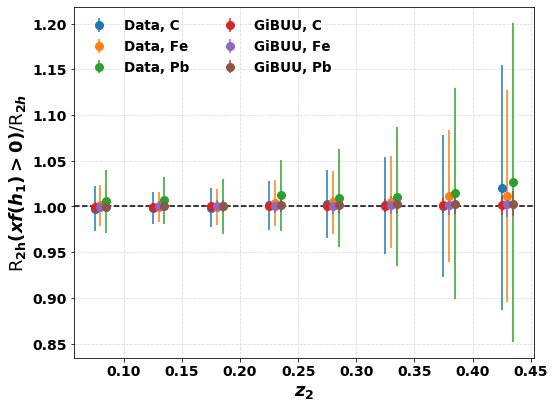

In [81]:
fig = plt.figure(figsize=(8,6))
y_ratio={}
y_ratio_GiB={}
y_ratio_err={}
y_ratio_err_GiB={}


for i,target in enumerate(['C','Fe','Pb']):
    r_noxf, err_noxf,x_noxf = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2, nbins=dpionz2Bins, variable='h2_z', 
                        pair_cut = '%s'%pair_cut_nom,
                            trig_cut = '%s '%trigger_cut_nom)
    #plt.errorbar(x_noxf+0.005*i,r_noxf,yerr=err_noxf,label='No xf, %s'%target,fmt='o',ms=8) ## 'fmt' is for formatting
    
    r_xf, err_xf,x_xf = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2, nbins=dpionz2Bins, variable='h2_z', 
                        pair_cut = '%s and h1_xf>0'%pair_cut_nom,
                            trig_cut = '%s and h1_xf>0'%trigger_cut_nom)
    #plt.errorbar(x_xf+0.005*i,r_xf,yerr=err_xf,label='h1_xf>0, %s'%target,fmt='o',ms=8) ## 'fmt' is for formatting
    y_ratio[target]=r_xf/r_noxf
    y_ratio_err[target]=(r_xf/r_noxf)*np.hypot(err_xf/r_xf,err_noxf/r_noxf )
    
    plt.errorbar(x_xf+0.005*i,y_ratio[target],yerr=y_ratio_err[target],label='Data, %s'%target,fmt='o',ms=8) ## 'fmt' is for formatting

for i,target in enumerate(['C','Fe','Pb']):
    r_noxf_GiB, err_noxf_GiB,x_noxf_GiB = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,variable='h2_z',minz=minz2,maxz=maxz2, nbins=dpionz2Bins, applyweight=False, 
                            trig_cut='h1_z>0.5',
                        pair_cut = 'and h1_z>0.5')
    #plt.errorbar(x_noxf_GiB+0.005*i,r_noxf_GiB,yerr=err_noxf_GiB,label='GiBUU no, xf %s'%target,fmt='s',fillstyle='none',ms=8)

    r_xf_GiB, err_xf_GiB,x_xf_GiB = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,variable='h2_z',minz=minz2,maxz=maxz2, nbins=dpionz2Bins, applyweight=False, 
                            trig_cut='h1_xf>0',
                        pair_cut = 'and h1_xf>0')
    #plt.errorbar(x_xf_GiB+0.005*i,r_xf_GiB,yerr=err_xf_GiB,label='GiBUU xf ,%s'%target,fmt='s',fillstyle='none',ms=8)
    
    y_ratio_GiB[target]=r_xf_GiB/r_noxf_GiB
    y_ratio_err_GiB[target]=(r_xf_GiB/r_noxf_GiB)*np.hypot(err_xf_GiB/r_xf_GiB,err_noxf_GiB/r_noxf_GiB )
    
    plt.errorbar(x_xf+0.005*i,y_ratio_GiB[target],yerr=y_ratio_err_GiB[target],label='GiBUU, %s'%target,fmt='o',ms=8) ## 'fmt' is for formatting

    
    
    
plt.xlabel('$z_{2}$',fontsize=18)
plt.ylabel('R$_{2\mathrm{h}}(xf(h_{1})>0)$/R$_{2h}$',fontsize=18)


#plt.ylim([0.,1.5])
#plt.xlim([0.00,0.5])
plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(loc='upper left',frameon=False,fontsize=13.5,ncol=2 )

plt.tight_layout()
##plt.savefig('ComparisonWithHermes_Linear.png')
#plt.ylim([0.55,1.85]) 

#plt.yscale('log')
##plt.savefig('ComparisonWithHermes_Log.png')
plt.grid(True, axis='x',color='gainsboro', linestyle='dashed')
plt.grid(True, axis='y',color='gainsboro', linestyle='dashed')
plt.xticks(np.arange(0.1,0.5,0.05),fontsize=14)
plt.yticks(fontsize=14)


##plt.savefig('ComparisonWithHermes_XfCut.pdf', bbox_inches='tight')
plt.show()

**Xf effect as a a function of pair $\Delta \phi$**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) an

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) an

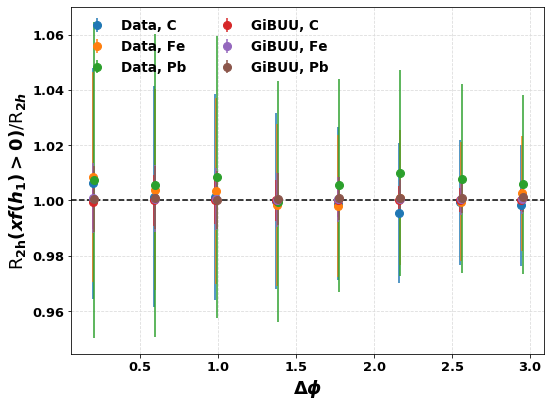

In [82]:
fig = plt.figure(figsize=(8,6))
y_ratio={}
y_ratio_GiB={}
y_ratio_err={}
y_ratio_err_GiB={}


for i,target in enumerate(['C','Fe','Pb']):
    r_noxf, err_noxf,x_noxf = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi, variable='dphi', 
                        pair_cut = '%s'%pair_cut_nom,
                            trig_cut = '%s '%trigger_cut_nom)
    #plt.errorbar(x_noxf+0.005*i,r_noxf,yerr=err_noxf,label='No xf, %s'%target,fmt='o',ms=8) ## 'fmt' is for formatting
    
    r_xf, err_xf,x_xf = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi, variable='dphi', 
                        pair_cut = '%s and h1_xf>0'%pair_cut_nom,
                            trig_cut = '%s and h1_xf>0'%trigger_cut_nom)
    #plt.errorbar(x_xf+0.005*i,r_xf,yerr=err_xf,label='h1_xf>0, %s'%target,fmt='o',ms=8) ## 'fmt' is for formatting
    y_ratio[target]=r_xf/r_noxf
    y_ratio_err[target]=(r_xf/r_noxf)*np.hypot(err_xf/r_xf,err_noxf/r_noxf )
    
    plt.errorbar(x_xf+0.005*i,y_ratio[target],yerr=y_ratio_err[target],label='Data, %s'%target,fmt='o',ms=8) ## 'fmt' is for formatting

for i,target in enumerate(['C','Fe','Pb']):
    r_noxf_GiB, err_noxf_GiB,x_noxf_GiB = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,variable='dphi',minz=mindphi,maxz=maxdphi, applyweight=False, 
                            trig_cut='h1_z>0.5',
                        pair_cut = 'and h1_z>0.5')
    #plt.errorbar(x_noxf_GiB+0.005*i,r_noxf_GiB,yerr=err_noxf_GiB,label='GiBUU no, xf %s'%target,fmt='s',fillstyle='none',ms=8)

    r_xf_GiB, err_xf_GiB,x_xf_GiB = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,variable='dphi',minz=mindphi,maxz=maxdphi, applyweight=False, 
                            trig_cut='h1_xf>0',
                        pair_cut = 'and h1_xf>0')
    #plt.errorbar(x_xf_GiB+0.005*i,r_xf_GiB,yerr=err_xf_GiB,label='GiBUU xf ,%s'%target,fmt='s',fillstyle='none',ms=8)
    
    y_ratio_GiB[target]=r_xf_GiB/r_noxf_GiB
    y_ratio_err_GiB[target]=(r_xf_GiB/r_noxf_GiB)*np.hypot(err_xf_GiB/r_xf_GiB,err_noxf_GiB/r_noxf_GiB )
    
    plt.errorbar(x_xf+0.005*i,y_ratio_GiB[target],yerr=y_ratio_err_GiB[target],label='GiBUU, %s'%target,fmt='o',ms=8) ## 'fmt' is for formatting

    
    
    
plt.xlabel('$\Delta \phi$',fontsize=18)
plt.ylabel('R$_{2\mathrm{h}}(xf(h_{1})>0)$/R$_{2h}$',fontsize=18)


#plt.ylim([0.,1.5])
#plt.xlim([0.00,0.5])
plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(loc='upper left',frameon=False,fontsize=13.5,ncol=2 )

plt.tight_layout()
##plt.savefig('ComparisonWithHermes_Linear.png')
#plt.ylim([0.55,1.85]) 

#plt.yscale('log')
##plt.savefig('ComparisonWithHermes_Log.png')
plt.grid(True, axis='x',color='gainsboro', linestyle='dashed')
plt.grid(True, axis='y',color='gainsboro', linestyle='dashed')
#plt.xticks(np.arange(0.1,0.5,0.05),fontsize=14)
#plt.yticks(fontsize=14)


##plt.savefig('ComparisonWithHermes_XfCut.pdf', bbox_inches='tight')
plt.show()


**Xf effect as a a function of pair inv mass**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) an

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) an

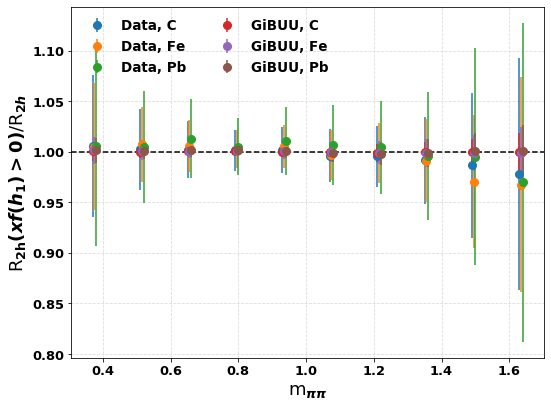

In [83]:
fig = plt.figure(figsize=(8,6))
y_ratio={}
y_ratio_GiB={}
y_ratio_err={}
y_ratio_err_GiB={}

for i,target in enumerate(['C','Fe','Pb']):
    r_noxf, err_noxf,x_noxf = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minzmass,maxz=maxzmass, variable='pair_mass', 
                        pair_cut = '%s'%pair_cut_nom,
                        trig_cut = '%s '%trigger_cut_nom,nbins=dpionMassBins)
    #plt.errorbar(x_noxf+0.005*i,r_noxf,yerr=err_noxf,label='No xf, %s'%target,fmt='o',ms=8) ## 'fmt' is for formatting
    
    r_xf, err_xf,x_xf = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minzmass,maxz=maxzmass, variable='pair_mass', 
                        pair_cut = '%s and h1_xf>0'%pair_cut_nom,
                            trig_cut = '%s and h1_xf>0'%trigger_cut_nom,nbins=dpionMassBins)
    #plt.errorbar(x_xf+0.005*i,r_xf,yerr=err_xf,label='h1_xf>0, %s'%target,fmt='o',ms=8) ## 'fmt' is for formatting
    y_ratio[target]=r_xf/r_noxf
    y_ratio_err[target]=(r_xf/r_noxf)*np.hypot(err_xf/r_xf,err_noxf/r_noxf )
    
    plt.errorbar(x_xf+0.005*i,y_ratio[target],yerr=y_ratio_err[target],label='Data, %s'%target,fmt='o',ms=8) ## 'fmt' is for formatting

for i,target in enumerate(['C','Fe','Pb']):
    r_noxf_GiB, err_noxf_GiB,x_noxf_GiB = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,variable='pair_mass',minz=minzmass,maxz=maxzmass, applyweight=False, 
                            trig_cut='h1_z>0.5',
                        pair_cut = 'and h1_z>0.5',nbins=dpionMassBins)
    #plt.errorbar(x_noxf_GiB+0.005*i,r_noxf_GiB,yerr=err_noxf_GiB,label='GiBUU no, xf %s'%target,fmt='s',fillstyle='none',ms=8)

    r_xf_GiB, err_xf_GiB,x_xf_GiB = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,variable='pair_mass',minz=minzmass,maxz=maxzmass, applyweight=False, 
                            trig_cut='h1_xf>0',
                        pair_cut = 'and h1_xf>0',nbins=dpionMassBins)
    #plt.errorbar(x_xf_GiB+0.005*i,r_xf_GiB,yerr=err_xf_GiB,label='GiBUU xf ,%s'%target,fmt='s',fillstyle='none',ms=8)
    
    y_ratio_GiB[target]=r_xf_GiB/r_noxf_GiB
    y_ratio_err_GiB[target]=(r_xf_GiB/r_noxf_GiB)*np.hypot(err_xf_GiB/r_xf_GiB,err_noxf_GiB/r_noxf_GiB )
    
    plt.errorbar(x_xf+0.005*i,y_ratio_GiB[target],yerr=y_ratio_err_GiB[target],label='GiBUU, %s'%target,fmt='o',ms=8) ## 'fmt' is for formatting

    
    
    
plt.xlabel('m$_{\pi\pi}$',fontsize=18)
plt.ylabel('R$_{2\mathrm{h}}(xf(h_{1})>0)$/R$_{2h}$',fontsize=18)


#plt.ylim([0.,1.5])
#plt.xlim([0.00,0.5])
plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(loc='upper left',frameon=False,fontsize=13.5,ncol=2 )

plt.tight_layout()
##plt.savefig('ComparisonWithHermes_Linear.png')
#plt.ylim([0.55,1.85]) 

#plt.yscale('log')
##plt.savefig('ComparisonWithHermes_Log.png')
plt.grid(True, axis='x',color='gainsboro', linestyle='dashed')
plt.grid(True, axis='y',color='gainsboro', linestyle='dashed')
#plt.xticks(np.arange(0.1,0.5,0.05),fontsize=14)
#plt.yticks(fontsize=14)


##plt.savefig('ComparisonWithHermes_XfCut.pdf', bbox_inches='tight')
plt.show()


# Comparison with Sebouh's numbers

**direct comparison between the mixed event distributions that sebastian moran gets in data and MC with the ones that Sebouh gets in data and MC with his method**

**Saving Sebouh's numbers into arrays**

<ErrorbarContainer object of 3 artists>

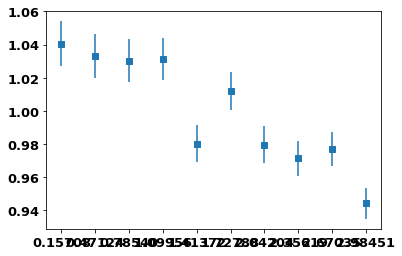

In [84]:
x=[]
y_all_C=[]
erry_all_C=[]
y_all_Fe=[]
erry_all_Fe=[]
y_all_Pb=[]
erry_all_Pb=[]

## different pairs
y_pp_C=[]
erry_pp_C=[]
y_pp_Fe=[]
erry_pp_Fe=[]
y_pp_Pb=[]
erry_pp_Pb=[]

y_pm_C=[]
erry_pm_C=[]
y_pm_Fe=[]
erry_pm_Fe=[]
y_pm_Pb=[]
erry_pm_Pb=[]

y_mp_C=[]
erry_mp_C=[]
y_mp_Fe=[]
erry_mp_Fe=[]
y_mp_Pb=[]
erry_mp_Pb=[]

y_mm_C=[]
erry_mm_C=[]
y_mm_Fe=[]
erry_mm_Fe=[]
y_mm_Pb=[]
erry_mm_Pb=[]

# different z bins

y_z_1_C=[]
erry_z_1_C=[]
y_z_1_Fe=[]
erry_z_1_Fe=[]   
y_z_1_Pb=[]
erry_z_1_Pb=[]

y_z_2_C=[]
erry_z_2_C=[]
y_z_2_Fe=[]
erry_z_2_Fe=[]   
y_z_2_Pb=[]
erry_z_2_Pb=[]

y_z_3_C=[]
erry_z_3_C=[]
y_z_3_Fe=[]
erry_z_3_Fe=[]   
y_z_3_Pb=[]
erry_z_3_Pb=[]

y_z_4_C=[]
erry_z_4_C=[]
y_z_4_Fe=[]
erry_z_4_Fe=[]   
y_z_4_Pb=[]
erry_z_4_Pb=[]

with open('all_C.txt','r') as f:
    for line in f:
        currentline=line.split(",")
        x.append(currentline[0])
        y_all_C.append( float(currentline[1]) )       
        erry_all_C.append(float(currentline[2]))
with open('all_Fe.txt','r') as f:
    for line in f:
        currentline=line.split(",")
        y_all_Fe.append(float(currentline[1]))        
        erry_all_Fe.append(float(currentline[2]))
with open('all_Pb.txt','r') as f:
    for line in f:
        currentline=line.split(",")
        y_all_Pb.append(float(currentline[1]))        
        erry_all_Pb.append(float(currentline[2]))  
        
with open('pp_pp_C.txt','r') as f:
    for line in f:
        currentline=line.split(",")
        y_pp_C.append(float(currentline[1]))        
        erry_pp_C.append(float(currentline[2]))        
with open('pp_pp_Fe.txt','r') as f:
    for line in f:
        currentline=line.split(",")
        y_pp_Fe.append(float(currentline[1]))        
        erry_pp_Fe.append(float(currentline[2]))  
with open('pp_pp_Pb.txt','r') as f:
    for line in f:
        currentline=line.split(",")
        y_pp_Pb.append(float(currentline[1]))        
        erry_pp_Pb.append(float(currentline[2]))          

with open('pp_pm_C.txt','r') as f:
    for line in f:
        currentline=line.split(",")
        y_pm_C.append(float(currentline[1]))        
        erry_pm_C.append(float(currentline[2]))        
with open('pp_pm_Fe.txt','r') as f:
    for line in f:
        currentline=line.split(",")
        y_pm_Fe.append(float(currentline[1]))        
        erry_pm_Fe.append(float(currentline[2]))  
with open('pp_pm_Pb.txt','r') as f:
    for line in f:
        currentline=line.split(",")
        y_pm_Pb.append(float(currentline[1]))        
        erry_pm_Pb.append(float(currentline[2]))          
        
with open('pm_pp_C.txt','r') as f:
    for line in f:
        currentline=line.split(",")
        y_mp_C.append(float(currentline[1]))        
        erry_mp_C.append(float(currentline[2]))        
with open('pm_pp_Fe.txt','r') as f:
    for line in f:
        currentline=line.split(",")
        y_mp_Fe.append(float(currentline[1]))        
        erry_mp_Fe.append(float(currentline[2]))  
with open('pm_pp_Pb.txt','r') as f:
    for line in f:
        currentline=line.split(",")
        y_mp_Pb.append(float(currentline[1]))        
        erry_mp_Pb.append(float(currentline[2]))          
                
with open('pm_pm_C.txt','r') as f:
    for line in f:
        currentline=line.split(",")
        y_mm_C.append(float(currentline[1]))        
        erry_mm_C.append(float(currentline[2]))        
with open('pm_pm_Fe.txt','r') as f:
    for line in f:
        currentline=line.split(",")
        y_mm_Fe.append(float(currentline[1]))        
        erry_mm_Fe.append(float(currentline[2]))  
with open('pm_pm_Pb.txt','r') as f:
    for line in f:
        currentline=line.split(",")
        y_mm_Pb.append(float(currentline[1]))        
        erry_mm_Pb.append(float(currentline[2]))          

        
with open('z_1_C.txt','r') as f:
    for line in f:
        currentline=line.split(",")
        y_z_1_C.append(float(currentline[1]))        
        erry_z_1_C.append(float(currentline[2]))         
        
with open('z_1_Fe.txt','r') as f:
    for line in f:
        currentline=line.split(",")
        y_z_1_Fe.append(float(currentline[1]))        
        erry_z_1_Fe.append(float(currentline[2]))
        
with open('z_1_Pb.txt','r') as f:
    for line in f:
        currentline=line.split(",")
        y_z_1_Pb.append(float(currentline[1]))        
        erry_z_1_Pb.append(float(currentline[2]))         
                
with open('z_2_C.txt','r') as f:
    for line in f:
        currentline=line.split(",")
        y_z_2_C.append(float(currentline[1]))        
        erry_z_2_C.append(float(currentline[2]))         
        
with open('z_2_Fe.txt','r') as f:
    for line in f:
        currentline=line.split(",")
        y_z_2_Fe.append(float(currentline[1]))        
        erry_z_2_Fe.append(float(currentline[2]))
        
with open('z_2_Pb.txt','r') as f:
    for line in f:
        currentline=line.split(",")
        y_z_2_Pb.append(float(currentline[1]))        
        erry_z_2_Pb.append(float(currentline[2]))         
                
with open('z_3_C.txt','r') as f:
    for line in f:
        currentline=line.split(",")
        y_z_3_C.append(float(currentline[1]))        
        erry_z_3_C.append(float(currentline[2]))         
        
with open('z_3_Fe.txt','r') as f:
    for line in f:
        currentline=line.split(",")
        y_z_3_Fe.append(float(currentline[1]))        
        erry_z_3_Fe.append(float(currentline[2]))
        
with open('z_3_Pb.txt','r') as f:
    for line in f:
        currentline=line.split(",")
        y_z_3_Pb.append(float(currentline[1]))        
        erry_z_3_Pb.append(float(currentline[2]))         
        
with open('z_4_C.txt','r') as f:
    for line in f:
        currentline=line.split(",")
        y_z_4_C.append(float(currentline[1]))        
        erry_z_4_C.append(float(currentline[2]))         
        
with open('z_4_Fe.txt','r') as f:
    for line in f:
        currentline=line.split(",")
        y_z_4_Fe.append(float(currentline[1]))        
        erry_z_4_Fe.append(float(currentline[2]))
        
with open('z_4_Pb.txt','r') as f:
    for line in f:
        currentline=line.split(",")
        y_z_4_Pb.append(float(currentline[1]))        
        erry_z_4_Pb.append(float(currentline[2]))         
                
        
        
        
        
x_ar=np.asarray(x)
y_all_C_ar=np.asarray(y_all_C)        
erry_all_C_ar=np.asarray(erry_all_C)        
y_all_Fe_ar=np.asarray(y_all_Fe)        
erry_all_Fe_ar=np.asarray(erry_all_Fe)        
y_all_Pb_ar=np.asarray(y_all_Pb)        
erry_all_Pb_ar=np.asarray(erry_all_Pb)        

y_pp_C_ar=np.asarray(y_pp_C)        
erry_pp_C_ar=np.asarray(erry_pp_C) 
y_pp_Fe_ar=np.asarray(y_pp_Fe)        
erry_pp_Fe_ar=np.asarray(erry_pp_Fe) 
y_pp_Pb_ar=np.asarray(y_pp_Pb)        
erry_pp_Pb_ar=np.asarray(erry_pp_Pb) 

y_pm_C_ar=np.asarray(y_pm_C)        
erry_pm_C_ar=np.asarray(erry_pm_C) 
y_pm_Fe_ar=np.asarray(y_pm_Fe)        
erry_pm_Fe_ar=np.asarray(erry_pm_Fe) 
y_pm_Pb_ar=np.asarray(y_pm_Pb)        
erry_pm_Pb_ar=np.asarray(erry_pm_Pb) 

y_mp_C_ar=np.asarray(y_mp_C)        
erry_mp_C_ar=np.asarray(erry_mp_C) 
y_mp_Fe_ar=np.asarray(y_mp_Fe)        
erry_mp_Fe_ar=np.asarray(erry_mp_Fe) 
y_mp_Pb_ar=np.asarray(y_mp_Pb)        
erry_mp_Pb_ar=np.asarray(erry_mp_Pb) 

y_mm_C_ar=np.asarray(y_mm_C)        
erry_mm_C_ar=np.asarray(erry_mm_C) 
y_mm_Fe_ar=np.asarray(y_mm_Fe)        
erry_mm_Fe_ar=np.asarray(erry_mm_Fe) 
y_mm_Pb_ar=np.asarray(y_mm_Pb)        
erry_mm_Pb_ar=np.asarray(erry_mm_Pb) 



y_z_1_C_ar=np.asarray(y_z_1_C)
y_z_1_Fe_ar=np.asarray(y_z_1_Fe)
y_z_1_Pb_ar=np.asarray(y_z_1_Pb)
erry_z_1_C_ar=np.asarray(erry_z_1_C)
erry_z_1_Fe_ar=np.asarray(erry_z_1_Fe)
erry_z_1_Pb_ar=np.asarray(erry_z_1_Pb)

y_z_2_C_ar=np.asarray(y_z_2_C)
y_z_2_Fe_ar=np.asarray(y_z_2_Fe)
y_z_2_Pb_ar=np.asarray(y_z_2_Pb)
erry_z_2_C_ar=np.asarray(erry_z_2_C)
erry_z_2_Fe_ar=np.asarray(erry_z_2_Fe)
erry_z_2_Pb_ar=np.asarray(erry_z_2_Pb)

y_z_3_C_ar=np.asarray(y_z_3_C)
y_z_3_Fe_ar=np.asarray(y_z_3_Fe)
y_z_3_Pb_ar=np.asarray(y_z_3_Pb)
erry_z_3_C_ar=np.asarray(erry_z_3_C)
erry_z_3_Fe_ar=np.asarray(erry_z_3_Fe)
erry_z_3_Pb_ar=np.asarray(erry_z_3_Pb)

y_z_4_C_ar=np.asarray(y_z_4_C)
y_z_4_Fe_ar=np.asarray(y_z_4_Fe)
y_z_4_Pb_ar=np.asarray(y_z_4_Pb)
erry_z_4_C_ar=np.asarray(erry_z_4_C)
erry_z_4_Fe_ar=np.asarray(erry_z_4_Fe)
erry_z_4_Pb_ar=np.asarray(erry_z_4_Pb)





#print(type(y_all_Pb))
#plt.errorbar(x,y=y_all_C,yerr=erry_all_C,fmt='o',label='C')        
#plt.errorbar(x,y=y_all_Fe,yerr=erry_all_Fe,fmt='o',label='Fe')  
#plt.errorbar(x,y=y_all_Pb,yerr=erry_all_Pb,fmt='o',label='Pb')  
plt.errorbar(x,y=y_all_C_ar,yerr=erry_all_C_ar,fmt='s',label='C Sebouh')  


**Main case to compare, all pairs, for data**

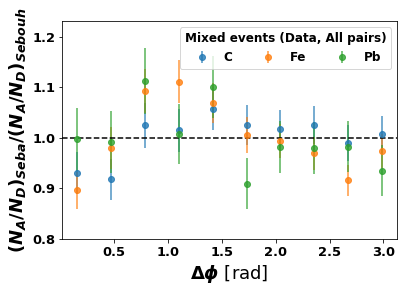

In [85]:
y = {}
erry = {}

## for data
ys = []
dys = []
x2=[]
for j,a in enumerate(['D_C', 'D_Fe', 'D_Pb', 'C' ,'Fe' ,'Pb']):
    mix = df_mix[a]
    y,x = np.histogram(mix.query('h2_z>0.1 and h1_z>0.5 and abs(h1_pid)==211 and abs(h2_pid)==211 %s'%pair_cut_nom).dphi,
                       bins=10, range=(0,np.pi))
    x = np.add(x[:-1],x[1:])/2
    dy = np.sqrt(y)
    denom = np.mean(y)
    ys.append(y)
    dys.append(dy)    
    x2.append(x)
for i,tar in enumerate(['C','Fe','Pb']):
    y = ys[i+3]/ys[i]
    dy = ys[i+3]/ys[i]*np.hypot(dys[i]/ys[i],dys[i+3]/ys[i+3])
    denom = np.average(y)
    y/=denom
    dy/=denom
    #plt.errorbar(x2[0],y,dy,linestyle='',marker='o',label=tar,alpha=0.8)
    if i==0:
        tmp=y/y_all_C_ar
        errtmp= y/y_all_C_ar *np.hypot(dy/y,  erry_all_C_ar/y_all_C_ar  )
        plt.errorbar(x2[0],tmp,errtmp,linestyle='',marker='o',label=tar,alpha=0.8)
    if i==1:
        tmp=y/y_all_Fe_ar
        errtmp= y/y_all_Fe_ar *np.hypot(dy/y,  erry_all_Fe_ar/y_all_Fe_ar  )
        plt.errorbar(x2[0],tmp,errtmp,linestyle='',marker='o',label=tar,alpha=0.8)    
    if i==2:
        tmp=y/y_all_Pb_ar
        errtmp= y/y_all_Pb_ar *np.hypot(dy/y,  erry_all_Pb_ar/y_all_Pb_ar  )
        plt.errorbar(x2[0],tmp,errtmp,linestyle='',marker='o',label=tar,alpha=0.8)
        

#plt.errorbar(x2[0],y=y_all_C_ar,yerr=erry_all_C_ar,fmt='s',label='C Sebouh', fillstyle='none',color='#1f77b4')    
#plt.errorbar(x2[0],y=y_all_Fe_ar,yerr=erry_all_Fe_ar,fmt='s',label='Fe Sebouh', fillstyle='none',color='#ff7f0e')    
#plt.errorbar(x2[0],y=y_all_Pb_ar,yerr=erry_all_Pb_ar,fmt='s',label='Pb Sebouh', fillstyle='none',color='#2ca02c')    

    
plt.legend(ncol=3, loc='upper right' ,frameon=True,fontsize=12, title='Mixed events (Data, All pairs)', title_fontsize=12)
plt.gca().set_ylabel("$(N_{A}/N_{D})_{Seba} / (N_{A}/N_{D})_{Sebouh}$")
plt.gca().set_xlabel("$\\Delta\\phi$ [rad]")
plt.axhline(y=1.0,color='black',linestyle='--')
plt.ylim(0.8,1.23)


#plt.savefig('compSebouhSebaMixedEvents.pdf', bbox_inches='tight')

plt.show()  


**Comparing the different configurations of pairs**

<ipython-input-86-d9bdd3d01439>:24: RuntimeWarning: invalid value encountered in true_divide
  y = ys[i+3]/ys[i]
<ipython-input-86-d9bdd3d01439>:25: RuntimeWarning: invalid value encountered in true_divide
  dy = ys[i+3]/ys[i]*np.hypot(dys[i]/ys[i],dys[i+3]/ys[i+3])
<ipython-input-86-d9bdd3d01439>:55: RuntimeWarning: invalid value encountered in true_divide
  y = ys[i+3]/ys[i]
<ipython-input-86-d9bdd3d01439>:56: RuntimeWarning: invalid value encountered in true_divide
  dy = ys[i+3]/ys[i]*np.hypot(dys[i]/ys[i],dys[i+3]/ys[i+3])
<ipython-input-86-d9bdd3d01439>:85: RuntimeWarning: invalid value encountered in true_divide
  y = ys[i+3]/ys[i]
<ipython-input-86-d9bdd3d01439>:86: RuntimeWarning: invalid value encountered in true_divide
  dy = ys[i+3]/ys[i]*np.hypot(dys[i]/ys[i],dys[i+3]/ys[i+3])
<ipython-input-86-d9bdd3d01439>:114: RuntimeWarning: invalid value encountered in true_divide
  y = ys[i+3]/ys[i]
<ipython-input-86-d9bdd3d01439>:115: RuntimeWarning: invalid value encountered in tru

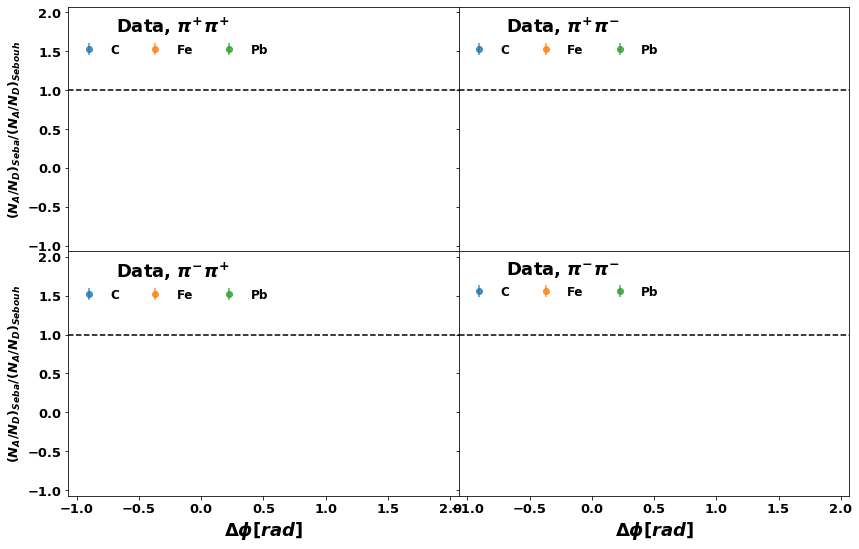

In [86]:
fig, axs = plt.subplots(2, 2,sharex=True, sharey=True,figsize=(14,9),gridspec_kw={'hspace': 0., 'wspace':0.})
#the default case is pp
ys = []
dys = []
ys_pm = []
dys_pm = []
ys_mp = []
dys_mp = []
ys_mm = []
dys_mm = []

x2=[]
for j,a in enumerate(['D_C', 'D_Fe', 'D_Pb', 'C' ,'Fe' ,'Pb']):
    mix = df_mix[a]
    y,x = np.histogram(mix.query('h2_z>0.1 and h1_z>0.5 and h1_pid==211 and h2_pid==211 %s'%pair_cut_nom).dphi,
                       bins=10, range=(0,np.pi))
    x = np.add(x[:-1],x[1:])/2
    dy = np.sqrt(y)
    denom = np.mean(y)
    ys.append(y)
    dys.append(dy)    
    x2.append(x)
for i,tar in enumerate(['C','Fe','Pb']):
    y = ys[i+3]/ys[i]
    dy = ys[i+3]/ys[i]*np.hypot(dys[i]/ys[i],dys[i+3]/ys[i+3])
    denom = np.average(y)
    y/=denom
    dy/=denom
    if i==0:
        tmp=y/y_pp_C_ar
        errtmp= y/y_pp_C_ar *np.hypot(dy/y,  erry_pp_C_ar/y_pp_C_ar  )
        axs[0][0].errorbar(x2[0],tmp,errtmp,linestyle='',marker='o',label=tar,alpha=0.8)
    if i==1:
        tmp=y/y_pp_Fe_ar
        errtmp= y/y_pp_Fe_ar *np.hypot(dy/y,  erry_pp_Fe_ar/y_pp_Fe_ar  )
        axs[0][0].errorbar(x2[0],tmp,errtmp,linestyle='',marker='o',label=tar,alpha=0.8)    
    if i==2:
        tmp=y/y_pp_Pb_ar
        errtmp= y/y_pp_Pb_ar *np.hypot(dy/y,  erry_pp_Pb_ar/y_pp_Pb_ar  )
        axs[0][0].errorbar(x2[0],tmp,errtmp,linestyle='',marker='o',label=tar,alpha=0.8)
        
        

for j,a in enumerate(['D_C', 'D_Fe', 'D_Pb', 'C' ,'Fe' ,'Pb']):
    mix = df_mix[a]
    y,x = np.histogram(mix.query('h2_z>0.1 and h1_z>0.5 and h1_pid==211 and h2_pid==-211 %s'%pair_cut_nom).dphi,
                       bins=10, range=(0,np.pi))
    x = np.add(x[:-1],x[1:])/2
    dy = np.sqrt(y)
    denom = np.mean(y)
    ys.append(y)
    dys.append(dy)    
    x2.append(x)
for i,tar in enumerate(['C','Fe','Pb']):
    y = ys[i+3]/ys[i]
    dy = ys[i+3]/ys[i]*np.hypot(dys[i]/ys[i],dys[i+3]/ys[i+3])
    denom = np.average(y)
    y/=denom
    dy/=denom
    if i==0:
        tmp=y/y_pm_C_ar
        errtmp= y/y_pm_C_ar *np.hypot(dy/y,  erry_pm_C_ar/y_pm_C_ar  )
        axs[0][1].errorbar(x2[0],tmp,errtmp,linestyle='',marker='o',label=tar,alpha=0.8)
    if i==1:
        tmp=y/y_pm_Fe_ar
        errtmp= y/y_pm_Fe_ar *np.hypot(dy/y,  erry_pm_Fe_ar/y_pm_Fe_ar  )
        axs[0][1].errorbar(x2[0],tmp,errtmp,linestyle='',marker='o',label=tar,alpha=0.8)    
    if i==2:
        tmp=y/y_pm_Pb_ar
        errtmp= y/y_pm_Pb_ar *np.hypot(dy/y,  erry_pm_Pb_ar/y_pm_Pb_ar  )
        axs[0][1].errorbar(x2[0],tmp,errtmp,linestyle='',marker='o',label=tar,alpha=0.8)
        
        
for j,a in enumerate(['D_C', 'D_Fe', 'D_Pb', 'C' ,'Fe' ,'Pb']):
    mix = df_mix[a]
    y,x = np.histogram(mix.query('h2_z>0.1 and h1_z>0.5 and h1_pid==-211 and h2_pid==211 %s'%pair_cut_nom).dphi,
                       bins=10, range=(0,np.pi))
    x = np.add(x[:-1],x[1:])/2
    dy = np.sqrt(y)
    denom = np.mean(y)
    ys.append(y)
    dys.append(dy)    
    x2.append(x)
for i,tar in enumerate(['C','Fe','Pb']):
    y = ys[i+3]/ys[i]
    dy = ys[i+3]/ys[i]*np.hypot(dys[i]/ys[i],dys[i+3]/ys[i+3])
    denom = np.average(y)
    y/=denom
    dy/=denom
    if i==0:
        tmp=y/y_mp_C_ar
        errtmp= y/y_mp_C_ar *np.hypot(dy/y,  erry_mp_C_ar/y_mp_C_ar  )
        axs[1][0].errorbar(x2[0],tmp,errtmp,linestyle='',marker='o',label=tar,alpha=0.8)
    if i==1:
        tmp=y/y_mp_Fe_ar
        errtmp= y/y_mp_Fe_ar *np.hypot(dy/y,  erry_mp_Fe_ar/y_mp_Fe_ar  )
        axs[1][0].errorbar(x2[0],tmp,errtmp,linestyle='',marker='o',label=tar,alpha=0.8)    
    if i==2:
        tmp=y/y_mp_Pb_ar
        errtmp= y/y_mp_Pb_ar *np.hypot(dy/y,  erry_mp_Pb_ar/y_mp_Pb_ar  )
        axs[1][0].errorbar(x2[0],tmp,errtmp,linestyle='',marker='o',label=tar,alpha=0.8)
        
for j,a in enumerate(['D_C', 'D_Fe', 'D_Pb', 'C' ,'Fe' ,'Pb']):
    mix = df_mix[a]
    y,x = np.histogram(mix.query('h2_z>0.1 and h1_z>0.5 and h1_pid==-211 and h2_pid==-211 %s'%pair_cut_nom).dphi,
                       bins=10, range=(0,np.pi))
    x = np.add(x[:-1],x[1:])/2
    dy = np.sqrt(y)
    denom = np.mean(y)
    ys.append(y)
    dys.append(dy)    
    x2.append(x)
for i,tar in enumerate(['C','Fe','Pb']):
    y = ys[i+3]/ys[i]
    dy = ys[i+3]/ys[i]*np.hypot(dys[i]/ys[i],dys[i+3]/ys[i+3])
    denom = np.average(y)
    y/=denom
    dy/=denom
    if i==0:
        tmp=y/y_mm_C_ar
        errtmp= y/y_mm_C_ar *np.hypot(dy/y,  erry_mm_C_ar/y_mm_C_ar  )
        axs[1][1].errorbar(x2[0],tmp,errtmp,linestyle='',marker='o',label=tar,alpha=0.8)
    if i==1:
        tmp=y/y_mm_Fe_ar
        errtmp= y/y_mm_Fe_ar *np.hypot(dy/y,  erry_mm_Fe_ar/y_mm_Fe_ar  )
        axs[1][1].errorbar(x2[0],tmp,errtmp,linestyle='',marker='o',label=tar,alpha=0.8)    
    if i==2:
        tmp=y/y_mm_Pb_ar
        errtmp= y/y_mm_Pb_ar *np.hypot(dy/y,  erry_mm_Pb_ar/y_mm_Pb_ar  )
        axs[1][1].errorbar(x2[0],tmp,errtmp,linestyle='',marker='o',label=tar,alpha=0.8)
axs[0][0].axhline(y=1.0,color='black',linestyle='--')
axs[0][1].axhline(y=1.0,color='black',linestyle='--')
axs[1][0].axhline(y=1.0,color='black',linestyle='--')
axs[1][1].axhline(y=1.0,color='black',linestyle='--')
axs[1][1].set_xlabel('$\Delta \phi [rad]$',fontsize=18)
axs[1][0].set_xlabel('$\Delta \phi [rad]$',fontsize=18)

axs[0][0].legend(loc='upper left',ncol=3,frameon=False,fontsize=12, borderaxespad=0.3, title='Data, $\pi^{+}\pi^{+}$')
axs[0][1].legend(loc='upper left',ncol=3,frameon=False,fontsize=12, borderaxespad=0.3, title='Data, $\pi^{+}\pi^{-}$')
axs[1][0].legend(loc='upper left',ncol=3,frameon=False,fontsize=12, borderaxespad=0.3, title='Data, $\pi^{-}\pi^{+}$')
axs[1][1].legend(loc='upper left',ncol=3,frameon=False,fontsize=12, borderaxespad=0.3, title='Data, $\pi^{-}\pi^{-}$')

axs[0][0].set_ylabel("$(N_{A}/N_{D})_{Seba} / (N_{A}/N_{D})_{Sebouh}$",fontsize=13)
axs[1][0].set_ylabel("$(N_{A}/N_{D})_{Seba} / (N_{A}/N_{D})_{Sebouh}$",fontsize=13)

#plt.savefig('compSebouhSebaMixedEvents_AllDiffPairs.pdf', bbox_inches='tight')
plt.show()

**Now, for the case of different z bins**

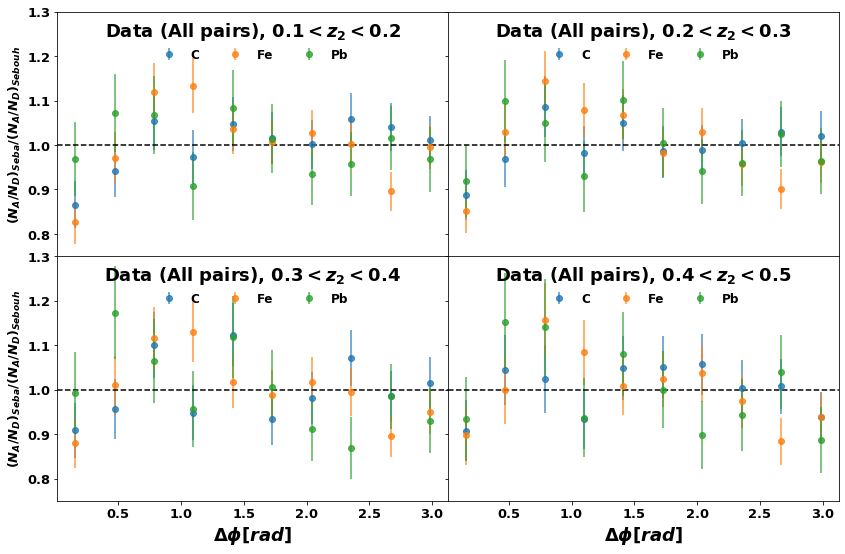

In [87]:
fig, axs = plt.subplots(2, 2,sharex=True, sharey=True,figsize=(14,9),gridspec_kw={'hspace': 0., 'wspace':0.})
#the default case is pp
ys = []
dys = []
ys_pm = []
dys_pm = []
ys_mp = []
dys_mp = []
ys_mm = []
dys_mm = []

x2=[]
for j,a in enumerate(['D_C', 'D_Fe', 'D_Pb', 'C' ,'Fe' ,'Pb']):
    mix = df_mix[a]
    y,x = np.histogram(mix.query('h2_z>0.1 and h2_z<0.2 and h1_z>0.5 and abs(h1_pid)==211 and abs(h2_pid)==211 %s'%pair_cut_nom).dphi,
                       bins=10, range=(0,np.pi))
    x = np.add(x[:-1],x[1:])/2
    dy = np.sqrt(y)
    denom = np.mean(y)
    ys.append(y)
    dys.append(dy)    
    x2.append(x)
for i,tar in enumerate(['C','Fe','Pb']):
    y = ys[i+3]/ys[i]
    dy = ys[i+3]/ys[i]*np.hypot(dys[i]/ys[i],dys[i+3]/ys[i+3])
    denom = np.average(y)
    y/=denom
    dy/=denom
    if i==0:
        tmp=y/y_z_1_C_ar
        errtmp= y/y_z_1_C_ar *np.hypot(dy/y,  erry_z_1_C_ar/y_z_1_C_ar  )
        axs[0][0].errorbar(x2[0],tmp,errtmp,linestyle='',marker='o',label=tar,alpha=0.8)
    if i==1:
        tmp=y/y_z_1_Fe_ar
        errtmp= y/y_z_1_Fe_ar *np.hypot(dy/y,  erry_z_1_Fe_ar/y_z_1_Fe_ar  )
        axs[0][0].errorbar(x2[0],tmp,errtmp,linestyle='',marker='o',label=tar,alpha=0.8)    
    if i==2:
        tmp=y/y_z_1_Pb_ar
        errtmp= y/y_z_1_Pb_ar *np.hypot(dy/y,  erry_z_1_Pb_ar/y_z_1_Pb_ar  )
        axs[0][0].errorbar(x2[0],tmp,errtmp,linestyle='',marker='o',label=tar,alpha=0.8)
        
        

for j,a in enumerate(['D_C', 'D_Fe', 'D_Pb', 'C' ,'Fe' ,'Pb']):
    mix = df_mix[a]
    y,x = np.histogram(mix.query('h2_z>0.2 and h2_z<0.3 and h1_z>0.5 and abs(h1_pid)==211 and abs(h2_pid)==211 %s'%pair_cut_nom).dphi,
                       bins=10, range=(0,np.pi))
    x = np.add(x[:-1],x[1:])/2
    dy = np.sqrt(y)
    denom = np.mean(y)
    ys.append(y)
    dys.append(dy)    
    x2.append(x)
for i,tar in enumerate(['C','Fe','Pb']):
    y = ys[i+3]/ys[i]
    dy = ys[i+3]/ys[i]*np.hypot(dys[i]/ys[i],dys[i+3]/ys[i+3])
    denom = np.average(y)
    y/=denom
    dy/=denom
    if i==0:
        tmp=y/y_z_2_C_ar
        errtmp= y/y_z_2_C_ar *np.hypot(dy/y,  erry_z_2_C_ar/y_z_2_C_ar  )
        axs[0][1].errorbar(x2[0],tmp,errtmp,linestyle='',marker='o',label=tar,alpha=0.8)
    if i==1:
        tmp=y/y_z_2_Fe_ar
        errtmp= y/y_z_2_Fe_ar *np.hypot(dy/y,  erry_z_2_Fe_ar/y_z_2_Fe_ar  )
        axs[0][1].errorbar(x2[0],tmp,errtmp,linestyle='',marker='o',label=tar,alpha=0.8)    
    if i==2:
        tmp=y/y_z_2_Pb_ar
        errtmp= y/y_z_2_Pb_ar *np.hypot(dy/y,  erry_z_2_Pb_ar/y_z_2_Pb_ar  )
        axs[0][1].errorbar(x2[0],tmp,errtmp,linestyle='',marker='o',label=tar,alpha=0.8)
        
        
for j,a in enumerate(['D_C', 'D_Fe', 'D_Pb', 'C' ,'Fe' ,'Pb']):
    mix = df_mix[a]
    y,x = np.histogram(mix.query('h2_z>0.3 and h2_z<0.4 and h1_z>0.5  and abs(h1_pid)==211 and abs(h2_pid)==211 %s'%pair_cut_nom).dphi,
                       bins=10, range=(0,np.pi))
    x = np.add(x[:-1],x[1:])/2
    dy = np.sqrt(y)
    denom = np.mean(y)
    ys.append(y)
    dys.append(dy)    
    x2.append(x)
for i,tar in enumerate(['C','Fe','Pb']):
    y = ys[i+3]/ys[i]
    dy = ys[i+3]/ys[i]*np.hypot(dys[i]/ys[i],dys[i+3]/ys[i+3])
    denom = np.average(y)
    y/=denom
    dy/=denom
    if i==0:
        tmp=y/y_z_3_C_ar
        errtmp= y/y_z_3_C_ar *np.hypot(dy/y,  erry_z_3_C_ar/y_z_3_C_ar  )
        axs[1][0].errorbar(x2[0],tmp,errtmp,linestyle='',marker='o',label=tar,alpha=0.8)
    if i==1:
        tmp=y/y_z_3_Fe_ar
        errtmp= y/y_z_3_Fe_ar *np.hypot(dy/y,  erry_z_3_Fe_ar/y_z_3_Fe_ar  )
        axs[1][0].errorbar(x2[0],tmp,errtmp,linestyle='',marker='o',label=tar,alpha=0.8)    
    if i==2:
        tmp=y/y_z_3_Pb_ar
        errtmp= y/y_z_3_Pb_ar *np.hypot(dy/y,  erry_z_3_Pb_ar/y_z_3_Pb_ar  )
        axs[1][0].errorbar(x2[0],tmp,errtmp,linestyle='',marker='o',label=tar,alpha=0.8)
        
for j,a in enumerate(['D_C', 'D_Fe', 'D_Pb', 'C' ,'Fe' ,'Pb']):
    mix = df_mix[a]
    y,x = np.histogram(mix.query('h2_z>0.4 and h2_z<0.5 and h1_z>0.5  and abs(h1_pid)==211 and abs(h2_pid)==211 %s'%pair_cut_nom).dphi,
                       bins=10, range=(0,np.pi))
    x = np.add(x[:-1],x[1:])/2
    dy = np.sqrt(y)
    denom = np.mean(y)
    ys.append(y)
    dys.append(dy)    
    x2.append(x)
for i,tar in enumerate(['C','Fe','Pb']):
    y = ys[i+3]/ys[i]
    dy = ys[i+3]/ys[i]*np.hypot(dys[i]/ys[i],dys[i+3]/ys[i+3])
    denom = np.average(y)
    y/=denom
    dy/=denom
    if i==0:
        tmp=y/y_z_4_C_ar
        errtmp= y/y_z_4_C_ar *np.hypot(dy/y,  erry_z_4_C_ar/y_z_4_C_ar  )
        axs[1][1].errorbar(x2[0],tmp,errtmp,linestyle='',marker='o',label=tar,alpha=0.8)
    if i==1:
        tmp=y/y_z_4_Fe_ar
        errtmp= y/y_z_4_Fe_ar *np.hypot(dy/y,  erry_z_4_Fe_ar/y_z_4_Fe_ar  )
        axs[1][1].errorbar(x2[0],tmp,errtmp,linestyle='',marker='o',label=tar,alpha=0.8)    
    if i==2:
        tmp=y/y_z_4_Pb_ar
        errtmp= y/y_z_4_Pb_ar *np.hypot(dy/y,  erry_z_4_Pb_ar/y_z_4_Pb_ar  )
        axs[1][1].errorbar(x2[0],tmp,errtmp,linestyle='',marker='o',label=tar,alpha=0.8)
        
axs[0][0].axhline(y=1.0,color='black',linestyle='--')
axs[0][1].axhline(y=1.0,color='black',linestyle='--')
axs[1][0].axhline(y=1.0,color='black',linestyle='--')
axs[1][1].axhline(y=1.0,color='black',linestyle='--')
axs[1][1].set_xlabel('$\Delta \phi [rad]$',fontsize=18)
axs[1][0].set_xlabel('$\Delta \phi [rad]$',fontsize=18)

axs[0][0].legend(loc='upper center',ncol=3,frameon=False,fontsize=12, borderaxespad=0.3, title='Data (All pairs), $0.1<z_{2}<0.2$')
axs[0][1].legend(loc='upper center',ncol=3,frameon=False,fontsize=12, borderaxespad=0.3, title='Data (All pairs), $0.2<z_{2}<0.3$')
axs[1][0].legend(loc='upper center',ncol=3,frameon=False,fontsize=12, borderaxespad=0.3, title='Data (All pairs), $0.3<z_{2}<0.4$')
axs[1][1].legend(loc='upper center',ncol=3,frameon=False,fontsize=12, borderaxespad=0.3, title='Data (All pairs), $0.4<z_{2}<0.5$')

axs[0][0].set_ylabel("$(N_{A}/N_{D})_{Seba} / (N_{A}/N_{D})_{Sebouh}$",fontsize=13)
axs[1][0].set_ylabel("$(N_{A}/N_{D})_{Seba} / (N_{A}/N_{D})_{Sebouh}$",fontsize=13)

axs[1][0].set_ylim(0.75,1.3)

#plt.savefig('compSebouhSebaMixedEvents_AllDiffZhBins.pdf', bbox_inches='tight')
plt.show()

**Invariant mass plots**

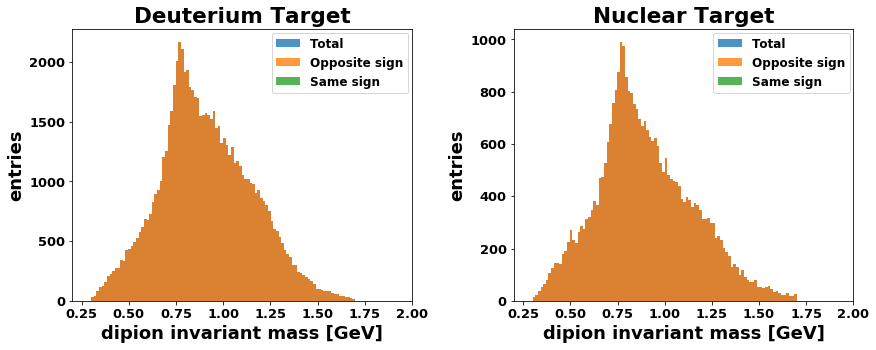

In [88]:
fig, axs = plt.subplots(1, 2,sharex=True, sharey=False,figsize=(14,5),gridspec_kw={'hspace': 0., 'wspace':0.3})
minz=0.05
maxz=1.2
nbins=100
op_sign='and h1_pid*h2_pid<0'
eq_sign='and h1_pid*h2_pid>0'

#axs[0].errorbar(x,y,label=tar,alpha=0.8)
axs[0].hist(df['D_Fe'].query(trigger_cut_nom+pair_cut_nom)['pair_mass'],alpha=0.8,histtype='stepfilled', bins=nbins, label='Total')
axs[0].hist(df['D_Fe'].query(trigger_cut_nom+pair_cut_nom + op_sign)['pair_mass'],alpha=0.8,histtype='stepfilled', bins=nbins, label='Opposite sign')
axs[0].hist(df['D_Fe'].query(trigger_cut_nom+pair_cut_nom + eq_sign)['pair_mass'],alpha=0.8,histtype='stepfilled', bins=nbins, label='Same sign')

axs[1].hist(df['Fe'].query(trigger_cut_nom+pair_cut_nom)['pair_mass'],alpha=0.8, bins=nbins,histtype='stepfilled', label='Total')
axs[1].hist(df['Fe'].query(trigger_cut_nom+pair_cut_nom + op_sign)['pair_mass'],alpha=0.8,histtype='stepfilled', bins=nbins, label='Opposite sign')
axs[1].hist(df['Fe'].query(trigger_cut_nom+pair_cut_nom + eq_sign)['pair_mass'],alpha=0.8,histtype='stepfilled', bins=nbins, label='Same sign')
axs[0].set_xlim(0.2,2.0)
axs[0].set_xlabel('dipion invariant mass [GeV]',fontweight='bold')
axs[1].set_xlabel('dipion invariant mass [GeV]',fontweight='bold')
axs[0].set_ylabel('entries',fontweight='bold')
axs[1].set_ylabel('entries',fontweight='bold')
axs[0].legend(loc='upper right',ncol=1,frameon=True,fontsize=12, borderaxespad=0.3, title='')
axs[1].legend(loc='upper right',ncol=1,frameon=True,fontsize=12, borderaxespad=0.3, title='')
axs[0].set_title('Deuterium Target',fontweight='bold')
axs[1].set_title('Nuclear Target',fontweight='bold')


outname='dipionInvMassD_A_comparisonSigns'
if not os.path.isdir(outdir_app):
    os.mkdir(outdir_app)
plt.savefig(outdir_app+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_app+outname+'.png', bbox_inches='tight')




plt.show()

**The same as the previous using GiBUU**

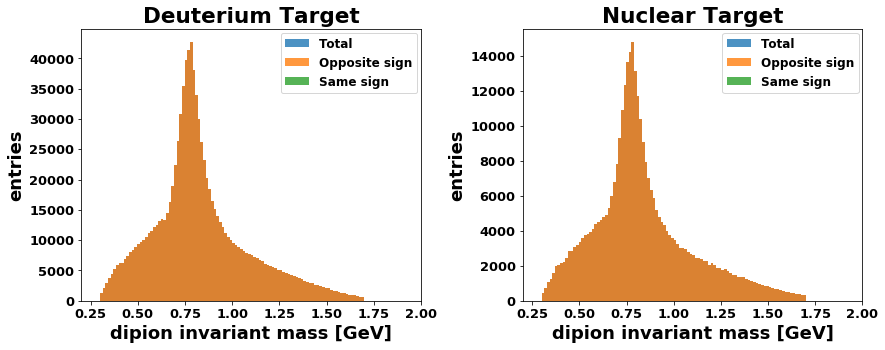

In [89]:
fig, axs = plt.subplots(1, 2,sharex=True, sharey=False,figsize=(14,5),gridspec_kw={'hspace': 0., 'wspace':0.3})
minz=0.05
maxz=1.2
nbins=100
op_sign='and h1_pid*h2_pid<0'
eq_sign='and h1_pid*h2_pid>0'

#axs[0].errorbar(x,y,label=tar,alpha=0.8)
axs[0].hist(df['GiBUU_D'].query('Q2>1')['pair_mass'],alpha=0.8,histtype='stepfilled', bins=nbins, label='Total')
axs[0].hist(df['GiBUU_D'].query('Q2>1' + op_sign)['pair_mass'],alpha=0.8,histtype='stepfilled', bins=nbins, label='Opposite sign')
axs[0].hist(df['GiBUU_D'].query('Q2>1' + eq_sign)['pair_mass'],alpha=0.8,histtype='stepfilled', bins=nbins, label='Same sign')

axs[1].hist(df['GiBUU_Fe'].query('Q2>1')['pair_mass'],alpha=0.8, bins=nbins,histtype='stepfilled', label='Total')
axs[1].hist(df['GiBUU_Fe'].query('Q2>1' + op_sign)['pair_mass'],alpha=0.8,histtype='stepfilled', bins=nbins, label='Opposite sign')
axs[1].hist(df['GiBUU_Fe'].query('Q2>1' + eq_sign)['pair_mass'],alpha=0.8,histtype='stepfilled', bins=nbins, label='Same sign')
axs[0].set_xlim(0.2,2.0)
axs[0].set_xlabel('dipion invariant mass [GeV]',fontweight='bold')
axs[1].set_xlabel('dipion invariant mass [GeV]',fontweight='bold')
axs[0].set_ylabel('entries',fontweight='bold')
axs[1].set_ylabel('entries',fontweight='bold')
axs[0].legend(loc='upper right',ncol=1,frameon=True,fontsize=12, borderaxespad=0.3, title='')
axs[1].legend(loc='upper right',ncol=1,frameon=True,fontsize=12, borderaxespad=0.3, title='')
axs[0].set_title('Deuterium Target',fontweight='bold')
axs[1].set_title('Nuclear Target',fontweight='bold')


outname='dipionInvMassD_A_comparisonSigns_GiBUU'
if not os.path.isdir(outdir_app):    os.mkdir(outdir_app)
plt.savefig(outdir_app+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_app+outname+'.png', bbox_inches='tight')


plt.show()

**Invariant mass plots, using SEABORN (it doesn't really work, because the distributions are normalized (prob) and youo can not see how small is the green distribution compared to the other ones)**

/home/seba/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/seba/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/seba/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

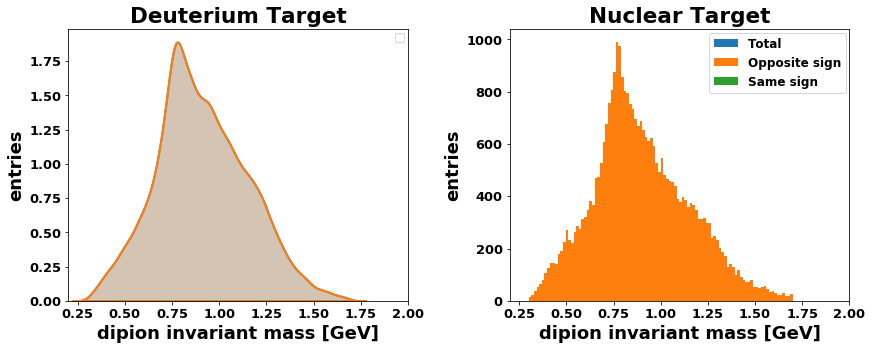

In [90]:
fig, axs = plt.subplots(1, 2,sharex=True, sharey=False,figsize=(14,5),gridspec_kw={'hspace': 0., 'wspace':0.3})
minz=0.05
maxz=1.2
nbins=100
op_sign='and h1_pid*h2_pid<0'
eq_sign='and h1_pid*h2_pid>0'
nalpha=1
#axs[0].errorbar(x,y,label=tar,alpha=0.8)
nlw=2

sns.distplot(df['D_Fe'].query(trigger_cut_nom+pair_cut_nom)['pair_mass'],kde_kws={'lw':nlw, 'shade':True}, hist=False, rug=False, color='#1f77b4', ax=axs[0])
sns.distplot(df['D_Fe'].query(trigger_cut_nom+pair_cut_nom+ op_sign)['pair_mass'],kde_kws={'lw':nlw, 'shade':True}, hist=False, rug=False, color='#ff7f0e', ax=axs[0])
sns.distplot(df['D_Fe'].query(trigger_cut_nom+pair_cut_nom+ eq_sign)['pair_mass'],kde_kws={'lw':nlw, 'shade':True}, hist=False, rug=False, color='#2ca02c', ax=axs[0])




#axs[0].hist(df['D_Fe'].query(trigger_cut_nom+pair_cut_nom)['pair_mass'],alpha=nalpha,histtype='stepfilled', bins=nbins, label='Total')
#axs[0].hist(df['D_Fe'].query(trigger_cut_nom+pair_cut_nom + op_sign)['pair_mass'],alpha=nalpha,histtype='stepfilled', bins=nbins, label='Opposite sign')
#axs[0].hist(df['D_Fe'].query(trigger_cut_nom+pair_cut_nom + eq_sign)['pair_mass'],alpha=nalpha,histtype='stepfilled', bins=nbins, label='Same sign')

axs[1].hist(df['Fe'].query(trigger_cut_nom+pair_cut_nom)['pair_mass'],alpha=nalpha, bins=nbins,histtype='stepfilled', label='Total')
axs[1].hist(df['Fe'].query(trigger_cut_nom+pair_cut_nom + op_sign)['pair_mass'],alpha=nalpha,histtype='stepfilled', bins=nbins, label='Opposite sign')
axs[1].hist(df['Fe'].query(trigger_cut_nom+pair_cut_nom + eq_sign)['pair_mass'],alpha=nalpha,histtype='stepfilled', bins=nbins, label='Same sign')
axs[0].set_xlim(0.2,2.0)
axs[0].set_xlabel('dipion invariant mass [GeV]',fontweight='bold')
axs[1].set_xlabel('dipion invariant mass [GeV]',fontweight='bold')
axs[0].set_ylabel('entries',fontweight='bold')
axs[1].set_ylabel('entries',fontweight='bold')
axs[0].legend(loc='upper right',ncol=1,frameon=True,fontsize=12, borderaxespad=0.3, title='')
axs[1].legend(loc='upper right',ncol=1,frameon=True,fontsize=12, borderaxespad=0.3, title='')
axs[0].set_title('Deuterium Target',fontweight='bold')
axs[1].set_title('Nuclear Target',fontweight='bold')


##plt.savefig('dipionInvMassD_A_comparisonSigns.pdf', bbox_inches='tight')

plt.show()

**Missing Mass plots, for different bins in h2_z**

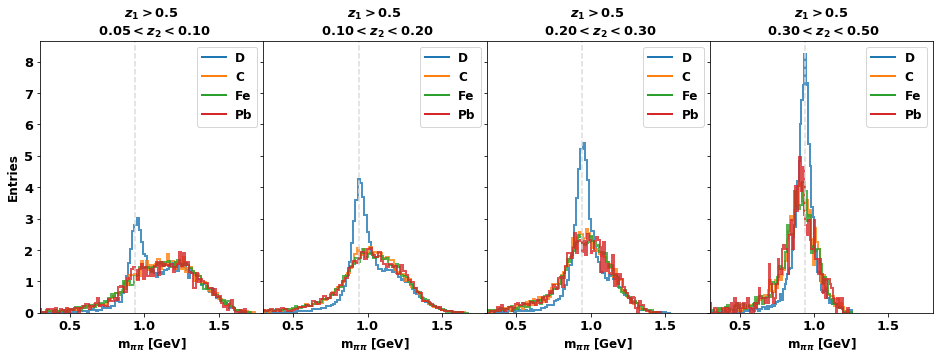

In [91]:
from matplotlib import lines
fig, axs = plt.subplots(1, 4,sharex=True, sharey=True,figsize=(16,5),gridspec_kw={'hspace': 0., 'wspace':0.})
minz=0.05
maxz=1.2
nbins=250
z_1_bin='and h2_z>0.05 and h2_z<0.1'
z_2_bin='and h2_z>0.1 and h2_z<0.2'
z_3_bin='and h2_z>0.2 and h2_z<0.3'
z_4_bin='and h2_z>0.3 and h2_z<0.5'
nlw=2

axs[0].hist(df['D_Fe'].query(trigger_cut_nom+pair_cut_nom+z_1_bin)['mx_eh1h2x'],alpha=0.8,lw=nlw, bins=nbins, histtype='step', label='D', density=True)
axs[0].hist(df['C'].query(trigger_cut_nom+pair_cut_nom+z_1_bin)['mx_eh1h2x'],alpha=0.8, bins=nbins,lw=nlw, histtype='step', label='C', density=True)
axs[0].hist(df['Fe'].query(trigger_cut_nom+pair_cut_nom+z_1_bin)['mx_eh1h2x'],alpha=0.8, bins=nbins,lw=nlw, histtype='step', label='Fe', density=True)
axs[0].hist(df['Pb'].query(trigger_cut_nom+pair_cut_nom+z_1_bin)['mx_eh1h2x'],alpha=0.8, bins=nbins, lw=nlw,histtype='step', label='Pb', density=True)

axs[1].hist(df['D_Fe'].query(trigger_cut_nom+pair_cut_nom+z_2_bin)['mx_eh1h2x'],alpha=0.8, bins=nbins,lw=nlw, histtype='step', label='D', density=True)
axs[1].hist(df['C'].query(trigger_cut_nom+pair_cut_nom+z_2_bin)['mx_eh1h2x'],alpha=0.8, bins=nbins,lw=nlw, histtype='step', label='C', density=True)
axs[1].hist(df['Fe'].query(trigger_cut_nom+pair_cut_nom+z_2_bin)['mx_eh1h2x'],alpha=0.8, bins=nbins,lw=nlw, histtype='step', label='Fe', density=True)
axs[1].hist(df['Pb'].query(trigger_cut_nom+pair_cut_nom+z_2_bin)['mx_eh1h2x'],alpha=0.8, bins=nbins,lw=nlw, histtype='step', label='Pb', density=True)

axs[2].hist(df['D_Fe'].query(trigger_cut_nom+pair_cut_nom+z_3_bin)['mx_eh1h2x'],alpha=0.8, bins=nbins,lw=nlw, histtype='step', label='D', density=True)
axs[2].hist(df['C'].query(trigger_cut_nom+pair_cut_nom+z_3_bin)['mx_eh1h2x'],alpha=0.8, bins=nbins, lw=nlw,histtype='step', label='C', density=True)
axs[2].hist(df['Fe'].query(trigger_cut_nom+pair_cut_nom+z_3_bin)['mx_eh1h2x'],alpha=0.8, bins=nbins,lw=nlw, histtype='step', label='Fe', density=True)
axs[2].hist(df['Pb'].query(trigger_cut_nom+pair_cut_nom+z_3_bin)['mx_eh1h2x'],alpha=0.8, bins=nbins, lw=nlw,histtype='step', label='Pb', density=True)

axs[3].hist(df['D_Fe'].query(trigger_cut_nom+pair_cut_nom+z_4_bin)['mx_eh1h2x'],alpha=0.8, bins=nbins,lw=nlw, histtype='step',label='D', density=True)
axs[3].hist(df['C'].query(trigger_cut_nom+pair_cut_nom+z_4_bin)['mx_eh1h2x'],alpha=0.8, bins=nbins, lw=nlw,histtype='step', label='C', density=True)
axs[3].hist(df['Fe'].query(trigger_cut_nom+pair_cut_nom+z_4_bin)['mx_eh1h2x'],alpha=0.8, bins=nbins, lw=nlw,histtype='step', label='Fe', density=True)
axs[3].hist(df['Pb'].query(trigger_cut_nom+pair_cut_nom+z_4_bin)['mx_eh1h2x'],alpha=0.8, bins=nbins, lw=nlw,histtype='step', label='Pb', density=True)

for i in range(4):    axs[i].axvline(x=0.93956,color='gainsboro',linestyle='--') ## neutron mass
axs[0].set_xlim(0.3,1.8)

lgd = []
lgd.append(lines.Line2D([0,0],[0,1], color = '#1f77b4',lw=nlw, label = 'D'))
lgd.append(lines.Line2D([0,0],[0,1], color = '#ff7f0e',lw=nlw, label = 'C'))
lgd.append(lines.Line2D([0,0],[0,1], color = '#2ca02c',lw=nlw, label = 'Fe'))
lgd.append(lines.Line2D([0,0],[0,1], color = '#d62728',lw=nlw, label = 'Pb'))

for i in range(4):    
    axs[i].legend(handles = lgd,fontsize=12)
    axs[i].set_xlabel('m$_{\pi\pi}$ [GeV]',fontsize=12, fontweight='bold')
axs[0].set_ylabel('Entries',fontsize=12, fontweight='bold')    
axs[0].set_title('$z_{1}>0.5$ \n $0.05<z_{2}<0.10$',fontsize=13)
axs[1].set_title('$z_{1}>0.5$ \n $0.10<z_{2}<0.20$',fontsize=13)
axs[2].set_title('$z_{1}>0.5$ \n $0.20<z_{2}<0.30$',fontsize=13)
axs[3].set_title('$z_{1}>0.5$ \n $0.30<z_{2}<0.50$',fontsize=13)
#plt.savefig('MissingMassD_A_comparisonZ2bins.pdf', bbox_inches='tight')

plt.show()

**Same as before, but this time using seaborn**

/home/sebouh/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/sebouh/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/sebouh/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

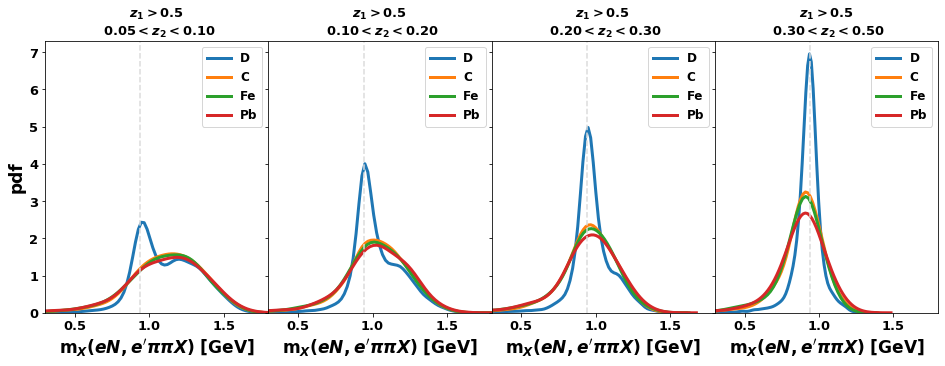

In [27]:
#sns.kdeplot(df['Fe'].query(trigger_cut_nom+pair_cut_nom+z_4_bin)['mx_eh1h2x']   )


from matplotlib import lines
fig, axs = plt.subplots(1, 4,sharex=True, sharey=True,figsize=(16,5),gridspec_kw={'hspace': 0., 'wspace':0.})
minz=0.05
maxz=1.2
nbins=2
z_1_bin='and h2_z>0.05 and h2_z<=0.1'
z_2_bin='and h2_z>=0.1 and h2_z<=0.2'
z_3_bin='and h2_z>=0.2 and h2_z<=0.3'
z_4_bin='and h2_z>=0.3 and h2_z<=0.5'
nlw=3


#axs[0].sns.kdeplot(df['D_Fe'].query(trigger_cut_nom+pair_cut_nom+z_1_bin)['mx_eh1h2x'])
#sns.despine(left=True)

sns.distplot(df['D_Fe'].query(trigger_cut_nom+pair_cut_nom+z_1_bin)['mx_eh1h2x'],kde_kws={'lw':nlw}, bins=nbins,hist=False, rug=False, color='#1f77b4', ax=axs[0])
sns.distplot(df['C'].query(trigger_cut_nom+pair_cut_nom+z_1_bin)['mx_eh1h2x'], kde_kws={'lw':nlw}, bins=nbins,hist=False, rug=False, color='#ff7f0e', ax=axs[0])
sns.distplot(df['Fe'].query(trigger_cut_nom+pair_cut_nom+z_1_bin)['mx_eh1h2x'],kde_kws={'lw':nlw},  bins=nbins,hist=False, rug=False, color='#2ca02c', ax=axs[0])
sns.distplot(df['Pb'].query(trigger_cut_nom+pair_cut_nom+z_1_bin)['mx_eh1h2x'],kde_kws={'lw':nlw},  bins=nbins,hist=False, rug=False, color='#d62728', ax=axs[0])

sns.distplot(df['D_Fe'].query(trigger_cut_nom+pair_cut_nom+z_2_bin)['mx_eh1h2x'],kde_kws={'lw':nlw},  bins=nbins,hist=False, rug=False, color='#1f77b4', ax=axs[1])
sns.distplot(df['C'].query(trigger_cut_nom+pair_cut_nom+z_2_bin)['mx_eh1h2x'],kde_kws={'lw':nlw},  bins=nbins,hist=False, rug=False, color='#ff7f0e', ax=axs[1])
sns.distplot(df['Fe'].query(trigger_cut_nom+pair_cut_nom+z_2_bin)['mx_eh1h2x'],kde_kws={'lw':nlw}, bins=nbins, hist=False, rug=False, color='#2ca02c', ax=axs[1])
sns.distplot(df['Pb'].query(trigger_cut_nom+pair_cut_nom+z_2_bin)['mx_eh1h2x'],kde_kws={'lw':nlw}, bins=nbins, hist=False, rug=False, color='#d62728', ax=axs[1])

sns.distplot(df['D_Fe'].query(trigger_cut_nom+pair_cut_nom+z_3_bin)['mx_eh1h2x'],kde_kws={'lw':nlw},  bins=nbins,hist=False, rug=False, color='#1f77b4', ax=axs[2])
sns.distplot(df['C'].query(trigger_cut_nom+pair_cut_nom+z_3_bin)['mx_eh1h2x'],kde_kws={'lw':nlw}, bins=nbins, hist=False, rug=False, color='#ff7f0e', ax=axs[2])
sns.distplot(df['Fe'].query(trigger_cut_nom+pair_cut_nom+z_3_bin)['mx_eh1h2x'],kde_kws={'lw':nlw},  bins=nbins,hist=False, rug=False, color='#2ca02c', ax=axs[2])
sns.distplot(df['Pb'].query(trigger_cut_nom+pair_cut_nom+z_3_bin)['mx_eh1h2x'], kde_kws={'lw':nlw}, bins=nbins,hist=False, rug=False, color='#d62728', ax=axs[2])

sns.distplot(df['D_Fe'].query(trigger_cut_nom+pair_cut_nom+z_4_bin)['mx_eh1h2x'],kde_kws={'lw':nlw}, bins=nbins, hist=False, rug=False, color='#1f77b4', ax=axs[3])
sns.distplot(df['C'].query(trigger_cut_nom+pair_cut_nom+z_4_bin)['mx_eh1h2x'],kde_kws={'lw':nlw}, bins=nbins, hist=False, rug=False, color='#ff7f0e', ax=axs[3])
sns.distplot(df['Fe'].query(trigger_cut_nom+pair_cut_nom+z_4_bin)['mx_eh1h2x'],kde_kws={'lw':nlw}, bins=nbins, hist=False, rug=False, color='#2ca02c', ax=axs[3])
sns.distplot(df['Pb'].query(trigger_cut_nom+pair_cut_nom+z_4_bin)['mx_eh1h2x'],kde_kws={'lw':nlw}, bins=nbins, hist=False, rug=False, color='#d62728', ax=axs[3])

for i in range(4):    axs[i].axvline(x=0.93956,color='gainsboro',linestyle='--') ## neutron mass
axs[0].set_xlim(0.3,1.8)

lgd = []
lgd.append(lines.Line2D([0,0],[0,1], color = '#1f77b4',lw=nlw, label = 'D'))
lgd.append(lines.Line2D([0,0],[0,1], color = '#ff7f0e',lw=nlw, label = 'C'))
lgd.append(lines.Line2D([0,0],[0,1], color = '#2ca02c',lw=nlw, label = 'Fe'))
lgd.append(lines.Line2D([0,0],[0,1], color = '#d62728',lw=nlw, label = 'Pb'))

for i in range(4):    
    axs[i].legend(handles = lgd,fontsize=12)
    axs[i].set_xlabel('m$_{X}(eN,e\'\pi\pi X)$ [GeV]',fontsize=17, fontweight='bold')
axs[0].set_ylabel('pdf',fontsize=17, fontweight='bold')    
axs[0].set_title('$z_{1}>0.5$ \n $0.05<z_{2}<0.10$',fontsize=13)
axs[1].set_title('$z_{1}>0.5$ \n $0.10<z_{2}<0.20$',fontsize=13)
axs[2].set_title('$z_{1}>0.5$ \n $0.20<z_{2}<0.30$',fontsize=13)
axs[3].set_title('$z_{1}>0.5$ \n $0.30<z_{2}<0.50$',fontsize=13)

outdir_app="images/"
outname='MissingMassD_A_comparisonZ2bins'
if not os.path.isdir(outdir_app):
    os.mkdir(outdir_app)
plt.savefig(outdir_app+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_app+outname+'.png', bbox_inches='tight')




plt.show()

**Same but the GiBUU**

/home/seba/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/seba/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/seba/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

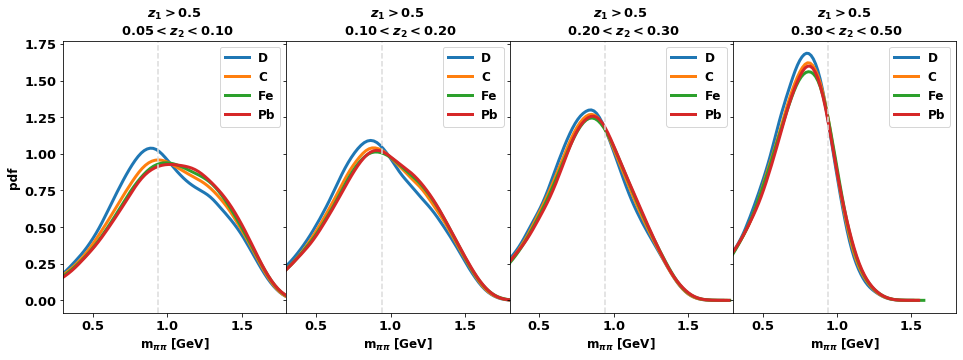

In [93]:
#sns.kdeplot(df['Fe'].query('Q2>1'+z_4_bin)['mx_eh1h2']   )


from matplotlib import lines
fig, axs = plt.subplots(1, 4,sharex=True, sharey=True,figsize=(16,5),gridspec_kw={'hspace': 0., 'wspace':0.})
minz=0.05
maxz=1.2
nbins=2
z_1_bin='and h2_z>0.05 and h2_z<=0.1'
z_2_bin='and h2_z>=0.1 and h2_z<=0.2'
z_3_bin='and h2_z>=0.2 and h2_z<=0.3'
z_4_bin='and h2_z>=0.3 and h2_z<=0.5'
nlw=3


#axs[0].sns.kdeplot(df['D_Fe'].query('Q2>1'+z_1_bin)['mx_eh1h2'])
#sns.despine(left=True)

sns.distplot(df['GiBUU_D'].query('Q2>1.0'+z_1_bin)['mx_eh1h2'],kde_kws={'lw':nlw}, bins=nbins,hist=False, rug=False, color='#1f77b4', ax=axs[0])
sns.distplot(df['GiBUU_C'].query('Q2>1'+z_1_bin)['mx_eh1h2'], kde_kws={'lw':nlw}, bins=nbins,hist=False, rug=False, color='#ff7f0e', ax=axs[0])
sns.distplot(df['GiBUU_Fe'].query('Q2>1'+z_1_bin)['mx_eh1h2'],kde_kws={'lw':nlw},  bins=nbins,hist=False, rug=False, color='#2ca02c', ax=axs[0])
sns.distplot(df['GiBUU_Pb'].query('Q2>1'+z_1_bin)['mx_eh1h2'],kde_kws={'lw':nlw},  bins=nbins,hist=False, rug=False, color='#d62728', ax=axs[0])

sns.distplot(df['GiBUU_D'].query('Q2>1'+z_2_bin)['mx_eh1h2'],kde_kws={'lw':nlw},  bins=nbins,hist=False, rug=False, color='#1f77b4', ax=axs[1])
sns.distplot(df['GiBUU_C'].query('Q2>1'+z_2_bin)['mx_eh1h2'],kde_kws={'lw':nlw},  bins=nbins,hist=False, rug=False, color='#ff7f0e', ax=axs[1])
sns.distplot(df['GiBUU_Fe'].query('Q2>1'+z_2_bin)['mx_eh1h2'],kde_kws={'lw':nlw}, bins=nbins, hist=False, rug=False, color='#2ca02c', ax=axs[1])
sns.distplot(df['GiBUU_Pb'].query('Q2>1'+z_2_bin)['mx_eh1h2'],kde_kws={'lw':nlw}, bins=nbins, hist=False, rug=False, color='#d62728', ax=axs[1])

sns.distplot(df['GiBUU_D'].query('Q2>1'+z_3_bin)['mx_eh1h2'],kde_kws={'lw':nlw},  bins=nbins,hist=False, rug=False, color='#1f77b4', ax=axs[2])
sns.distplot(df['GiBUU_C'].query('Q2>1'+z_3_bin)['mx_eh1h2'],kde_kws={'lw':nlw}, bins=nbins, hist=False, rug=False, color='#ff7f0e', ax=axs[2])
sns.distplot(df['GiBUU_Fe'].query('Q2>1'+z_3_bin)['mx_eh1h2'],kde_kws={'lw':nlw},  bins=nbins,hist=False, rug=False, color='#2ca02c', ax=axs[2])
sns.distplot(df['GiBUU_Pb'].query('Q2>1'+z_3_bin)['mx_eh1h2'], kde_kws={'lw':nlw}, bins=nbins,hist=False, rug=False, color='#d62728', ax=axs[2])

sns.distplot(df['GiBUU_D'].query('Q2>1'+z_4_bin)['mx_eh1h2'],kde_kws={'lw':nlw}, bins=nbins, hist=False, rug=False, color='#1f77b4', ax=axs[3])
sns.distplot(df['GiBUU_C'].query('Q2>1'+z_4_bin)['mx_eh1h2'],kde_kws={'lw':nlw}, bins=nbins, hist=False, rug=False, color='#ff7f0e', ax=axs[3])
sns.distplot(df['GiBUU_Fe'].query('Q2>1'+z_4_bin)['mx_eh1h2'],kde_kws={'lw':nlw}, bins=nbins, hist=False, rug=False, color='#2ca02c', ax=axs[3])
sns.distplot(df['GiBUU_Pb'].query('Q2>1'+z_4_bin)['mx_eh1h2'],kde_kws={'lw':nlw}, bins=nbins, hist=False, rug=False, color='#d62728', ax=axs[3])

for i in range(4):    axs[i].axvline(x=0.93956,color='gainsboro',linestyle='--') ## neutron mass
axs[0].set_xlim(0.3,1.8)

lgd = []
lgd.append(lines.Line2D([0,0],[0,1], color = '#1f77b4',lw=nlw, label = 'D'))
lgd.append(lines.Line2D([0,0],[0,1], color = '#ff7f0e',lw=nlw, label = 'C'))
lgd.append(lines.Line2D([0,0],[0,1], color = '#2ca02c',lw=nlw, label = 'Fe'))
lgd.append(lines.Line2D([0,0],[0,1], color = '#d62728',lw=nlw, label = 'Pb'))

for i in range(4):    
    axs[i].legend(handles = lgd,fontsize=12)
    axs[i].set_xlabel('m$_{\pi\pi}$ [GeV]',fontsize=12, fontweight='bold')
axs[0].set_ylabel('pdf',fontsize=12, fontweight='bold')    
axs[0].set_title('$z_{1}>0.5$ \n $0.05<z_{2}<0.10$',fontsize=13)
axs[1].set_title('$z_{1}>0.5$ \n $0.10<z_{2}<0.20$',fontsize=13)
axs[2].set_title('$z_{1}>0.5$ \n $0.20<z_{2}<0.30$',fontsize=13)
axs[3].set_title('$z_{1}>0.5$ \n $0.30<z_{2}<0.50$',fontsize=13)


outname='MissingMassD_A_comparisonZ2bins_GiBUU'
#if not os.path.isdir(outdir_app):    os.mkdir(outdir_app)
#plt.savefig(outdir_app+outname+'.pdf', bbox_inches='tight')
#plt.savefig(outdir_app+outname+'.png', bbox_inches='tight')




plt.show()

In [94]:
print(df['GiBUU_Fe'].columns)

Index(['dphi', 'dphi_lab', 'qt', 'drap', 'h1_z', 'h2_z', 'z_tot', 'h1_xf',
       'h2_xf', 'h1_rap', 'ycm', 'h2_rap', 'h1_pid', 'h2_pid', 'h1_cm_ph',
       'h2_cm_ph', 'h1_cm_th', 'h2_cm_th', 'pair_mass', 'pair_pt', 'mx_eh1h2',
       'Q2', 'x', 'nu', 'W', 'h1_ph', 'h1_th', 'h2_ph', 'h2_th', 'pos_x',
       'pos_y', 'pos_z', 'pos_x_asso', 'pos_y_asso', 'pos_z_asso', '__index__',
       'inelasticity', 'h1_e', 'h1_p', 'h2_e', 'h2_p', 'pair_pt2'],
      dtype='object')


**Dipion Invariant Mass plots, for different bins in h2_z**

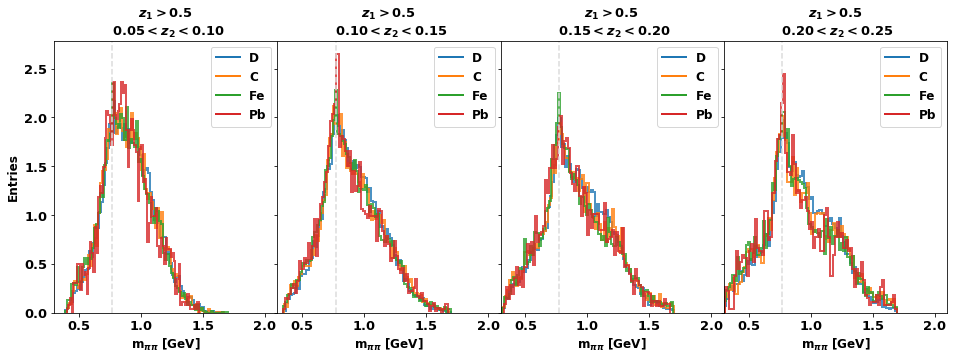

In [95]:
from matplotlib import lines
fig, axs = plt.subplots(1, 4,sharex=True, sharey=True,figsize=(16,5),gridspec_kw={'hspace': 0., 'wspace':0.})
nbins=80
z_1_bin='and h2_z>0.05 and h2_z<0.1'
z_2_bin='and h2_z>=0.1 and h2_z<0.15'
z_3_bin='and h2_z>=0.15 and h2_z<0.2'
z_4_bin='and h2_z>=0.2 and h2_z<0.25'
nlw=2

axs[0].hist(df['D_Fe'].query(trigger_cut_nom+pair_cut_nom+z_1_bin)['pair_mass'],alpha=0.8,lw=nlw, bins=nbins, histtype='step', label='D', density=True)
axs[0].hist(df['C'].query(trigger_cut_nom+pair_cut_nom+z_1_bin)['pair_mass'],alpha=0.8, bins=nbins,lw=nlw, histtype='step', label='C', density=True)
axs[0].hist(df['Fe'].query(trigger_cut_nom+pair_cut_nom+z_1_bin)['pair_mass'],alpha=0.8, bins=nbins,lw=nlw, histtype='step', label='Fe', density=True)
axs[0].hist(df['Pb'].query(trigger_cut_nom+pair_cut_nom+z_1_bin)['pair_mass'],alpha=0.8, bins=nbins, lw=nlw,histtype='step', label='Pb', density=True)

axs[1].hist(df['D_Fe'].query(trigger_cut_nom+pair_cut_nom+z_2_bin)['pair_mass'],alpha=0.8, bins=nbins,lw=nlw, histtype='step', label='D', density=True)
axs[1].hist(df['C'].query(trigger_cut_nom+pair_cut_nom+z_2_bin)['pair_mass'],alpha=0.8, bins=nbins,lw=nlw, histtype='step', label='C', density=True)
axs[1].hist(df['Fe'].query(trigger_cut_nom+pair_cut_nom+z_2_bin)['pair_mass'],alpha=0.8, bins=nbins,lw=nlw, histtype='step', label='Fe', density=True)
axs[1].hist(df['Pb'].query(trigger_cut_nom+pair_cut_nom+z_2_bin)['pair_mass'],alpha=0.8, bins=nbins,lw=nlw, histtype='step', label='Pb', density=True)

axs[2].hist(df['D_Fe'].query(trigger_cut_nom+pair_cut_nom+z_3_bin)['pair_mass'],alpha=0.8, bins=nbins,lw=nlw, histtype='step', label='D', density=True)
axs[2].hist(df['C'].query(trigger_cut_nom+pair_cut_nom+z_3_bin)['pair_mass'],alpha=0.8, bins=nbins, lw=nlw,histtype='step', label='C', density=True)
axs[2].hist(df['Fe'].query(trigger_cut_nom+pair_cut_nom+z_3_bin)['pair_mass'],alpha=0.8, bins=nbins,lw=nlw, histtype='step', label='Fe', density=True)
axs[2].hist(df['Pb'].query(trigger_cut_nom+pair_cut_nom+z_3_bin)['pair_mass'],alpha=0.8, bins=nbins, lw=nlw,histtype='step', label='Pb', density=True)

axs[3].hist(df['D_Fe'].query(trigger_cut_nom+pair_cut_nom+z_4_bin)['pair_mass'],alpha=0.8, bins=nbins,lw=nlw, histtype='step',label='D', density=True)
axs[3].hist(df['C'].query(trigger_cut_nom+pair_cut_nom+z_4_bin)['pair_mass'],alpha=0.8, bins=nbins, lw=nlw,histtype='step', label='C', density=True)
axs[3].hist(df['Fe'].query(trigger_cut_nom+pair_cut_nom+z_4_bin)['pair_mass'],alpha=0.8, bins=nbins, lw=nlw,histtype='step', label='Fe', density=True)
axs[3].hist(df['Pb'].query(trigger_cut_nom+pair_cut_nom+z_4_bin)['pair_mass'],alpha=0.8, bins=nbins, lw=nlw,histtype='step', label='Pb', density=True)

for i in range(4):    axs[i].axvline(x=0.77,color='gainsboro',linestyle='--') ## rho0 mass
axs[0].set_xlim(0.3,2.1)
#axs[0].set_ylim(-0.1,2.7)
lgd = []
lgd.append(lines.Line2D([0,0],[0,1], color = '#1f77b4',lw=nlw, label = 'D'))
lgd.append(lines.Line2D([0,0],[0,1], color = '#ff7f0e',lw=nlw, label = 'C'))
lgd.append(lines.Line2D([0,0],[0,1], color = '#2ca02c',lw=nlw, label = 'Fe'))
lgd.append(lines.Line2D([0,0],[0,1], color = '#d62728',lw=nlw, label = 'Pb'))

for i in range(4):    
    axs[i].legend(handles = lgd,fontsize=12)
    axs[i].set_xlabel('m$_{\pi\pi}$ [GeV]',fontsize=12, fontweight='bold')
axs[0].set_ylabel('Entries',fontsize=12, fontweight='bold')    
axs[0].set_title('$z_{1}>0.5$ \n $0.05<z_{2}<0.10$',fontsize=13)
axs[1].set_title('$z_{1}>0.5$ \n $0.10<z_{2}<0.15$',fontsize=13)
axs[2].set_title('$z_{1}>0.5$ \n $0.15<z_{2}<0.20$',fontsize=13)
axs[3].set_title('$z_{1}>0.5$ \n $0.20<z_{2}<0.25$',fontsize=13)
#plt.savefig('InvMassD_A_comparisonZ2bins.pdf', bbox_inches='tight')
plt.show()

**Dipion Invariant Mass plots, for different bins in h2_z, using SEABORN**

/home/seba/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/seba/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/seba/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

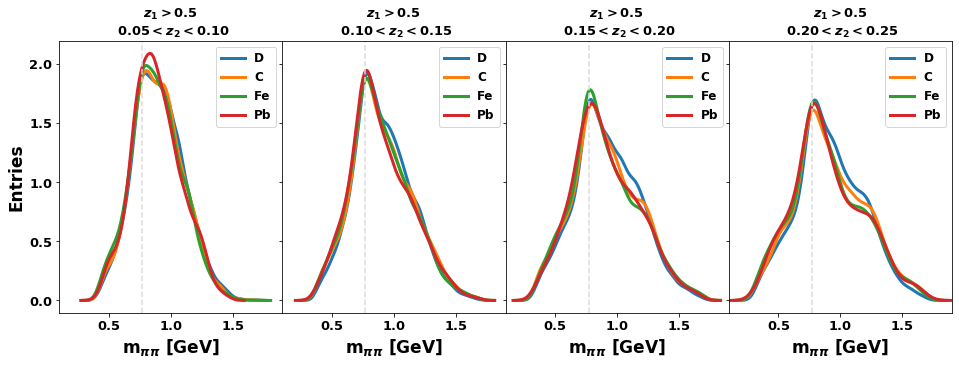

In [96]:
from matplotlib import lines
fig, axs = plt.subplots(1, 4,sharex=True, sharey=True,figsize=(16,5),gridspec_kw={'hspace': 0., 'wspace':0.})
nbins=80
z_1_bin='and h2_z>0.05 and h2_z<0.1'
z_2_bin='and h2_z>=0.1 and h2_z<0.15'
z_3_bin='and h2_z>=0.15 and h2_z<0.2'
z_4_bin='and h2_z>=0.2 and h2_z<0.25'
nlw=3


sns.distplot(df['D_Fe'].query(trigger_cut_nom+pair_cut_nom+z_1_bin)['pair_mass'],kde_kws={'lw':nlw}, bins=nbins,hist=False, rug=False, color='#1f77b4', ax=axs[0])
sns.distplot(df['C'].query(trigger_cut_nom+pair_cut_nom+z_1_bin)['pair_mass'], kde_kws={'lw':nlw}, bins=nbins,hist=False, rug=False, color='#ff7f0e', ax=axs[0])
sns.distplot(df['Fe'].query(trigger_cut_nom+pair_cut_nom+z_1_bin)['pair_mass'],kde_kws={'lw':nlw},  bins=nbins,hist=False, rug=False, color='#2ca02c', ax=axs[0])
sns.distplot(df['Pb'].query(trigger_cut_nom+pair_cut_nom+z_1_bin)['pair_mass'],kde_kws={'lw':nlw},  bins=nbins,hist=False, rug=False, color='#d62728', ax=axs[0])

sns.distplot(df['D_Fe'].query(trigger_cut_nom+pair_cut_nom+z_2_bin)['pair_mass'],kde_kws={'lw':nlw},  bins=nbins,hist=False, rug=False, color='#1f77b4', ax=axs[1])
sns.distplot(df['C'].query(trigger_cut_nom+pair_cut_nom+z_2_bin)['pair_mass'],kde_kws={'lw':nlw},  bins=nbins,hist=False, rug=False, color='#ff7f0e', ax=axs[1])
sns.distplot(df['Fe'].query(trigger_cut_nom+pair_cut_nom+z_2_bin)['pair_mass'],kde_kws={'lw':nlw}, bins=nbins, hist=False, rug=False, color='#2ca02c', ax=axs[1])
sns.distplot(df['Pb'].query(trigger_cut_nom+pair_cut_nom+z_2_bin)['pair_mass'],kde_kws={'lw':nlw}, bins=nbins, hist=False, rug=False, color='#d62728', ax=axs[1])

sns.distplot(df['D_Fe'].query(trigger_cut_nom+pair_cut_nom+z_3_bin)['pair_mass'],kde_kws={'lw':nlw},  bins=nbins,hist=False, rug=False, color='#1f77b4', ax=axs[2])
sns.distplot(df['C'].query(trigger_cut_nom+pair_cut_nom+z_3_bin)['pair_mass'],kde_kws={'lw':nlw}, bins=nbins, hist=False, rug=False, color='#ff7f0e', ax=axs[2])
sns.distplot(df['Fe'].query(trigger_cut_nom+pair_cut_nom+z_3_bin)['pair_mass'],kde_kws={'lw':nlw},  bins=nbins,hist=False, rug=False, color='#2ca02c', ax=axs[2])
sns.distplot(df['Pb'].query(trigger_cut_nom+pair_cut_nom+z_3_bin)['pair_mass'], kde_kws={'lw':nlw}, bins=nbins,hist=False, rug=False, color='#d62728', ax=axs[2])

sns.distplot(df['D_Fe'].query(trigger_cut_nom+pair_cut_nom+z_4_bin)['pair_mass'],kde_kws={'lw':nlw}, bins=nbins, hist=False, rug=False, color='#1f77b4', ax=axs[3])
sns.distplot(df['C'].query(trigger_cut_nom+pair_cut_nom+z_4_bin)['pair_mass'],kde_kws={'lw':nlw}, bins=nbins, hist=False, rug=False, color='#ff7f0e', ax=axs[3])
sns.distplot(df['Fe'].query(trigger_cut_nom+pair_cut_nom+z_4_bin)['pair_mass'],kde_kws={'lw':nlw}, bins=nbins, hist=False, rug=False, color='#2ca02c', ax=axs[3])
sns.distplot(df['Pb'].query(trigger_cut_nom+pair_cut_nom+z_4_bin)['pair_mass'],kde_kws={'lw':nlw}, bins=nbins, hist=False, rug=False, color='#d62728', ax=axs[3])

for i in range(4):    axs[i].axvline(x=0.77,color='gainsboro',linestyle='--') ## rho0 mass
axs[0].set_xlim(0.1,1.9)
#axs[0].set_ylim(-0.1,2.7)
lgd = []
lgd.append(lines.Line2D([0,0],[0,1], color = '#1f77b4',lw=nlw, label = 'D'))
lgd.append(lines.Line2D([0,0],[0,1], color = '#ff7f0e',lw=nlw, label = 'C'))
lgd.append(lines.Line2D([0,0],[0,1], color = '#2ca02c',lw=nlw, label = 'Fe'))
lgd.append(lines.Line2D([0,0],[0,1], color = '#d62728',lw=nlw, label = 'Pb'))

for i in range(4):    
    axs[i].legend(handles = lgd,fontsize=12)
    axs[i].set_xlabel('m$_{\pi\pi}$ [GeV]',fontsize=17, fontweight='bold')
axs[0].set_ylabel('Entries',fontsize=17, fontweight='bold')    
axs[0].set_title('$z_{1}>0.5$ \n $0.05<z_{2}<0.10$',fontsize=13)
axs[1].set_title('$z_{1}>0.5$ \n $0.10<z_{2}<0.15$',fontsize=13)
axs[2].set_title('$z_{1}>0.5$ \n $0.15<z_{2}<0.20$',fontsize=13)
axs[3].set_title('$z_{1}>0.5$ \n $0.20<z_{2}<0.25$',fontsize=13)

outname='InvMassD_A_comparisonZ2bins'
if not os.path.isdir(outdir_app):
    os.mkdir(outdir_app)
plt.savefig(outdir_app+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_app+outname+'.png', bbox_inches='tight')
#ssssssssssss
plt.show()

**R2h for different Nu and Q2 bins**

**Nu dependence**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and nu>2.2 and nu<3.2 and abs(h1_pid)==211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and nu>3.2 and nu<3.7 and abs(h1_pid)==211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and nu>3.7 and nu<4.2 and abs(h1_pid)==211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and nu>3.2 and nu<3.7 and abs(h1_pid)==211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and nu>3.7 and nu<4.2 and abs(h1_pid)==211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and nu>3.2 and nu<3.7 and abs(h1_pid)==211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and nu>3.7 and nu<4.2 and abs(h1_pid)==211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*

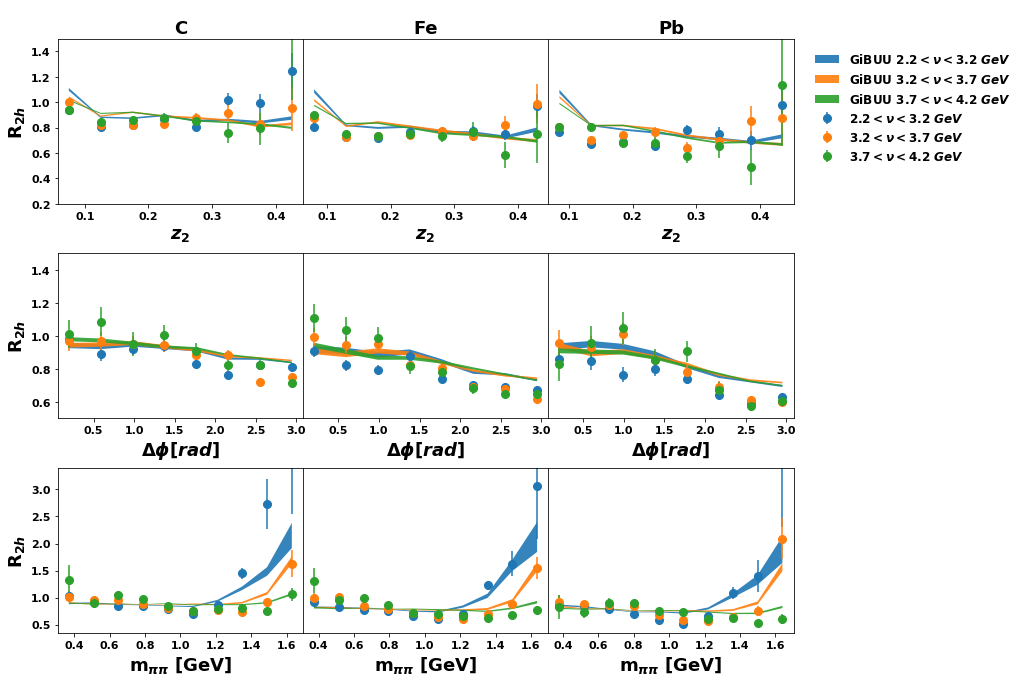

In [97]:
fig, axs = plt.subplots(3, 3,sharex=False, sharey=False,figsize=(14,10),gridspec_kw={'hspace': 0.3, 'wspace':0.})

nulabel = {} 
nulabel['bin_1'] = r'$2.2<\nu<3.2$ $GeV$' 
nulabel['bin_2'] = r'$3.2<\nu<3.7$ $GeV$' 
nulabel['bin_3'] = r'$3.7<\nu<4.2$ $GeV$' 

for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2, nbins=dpionz2Bins, variable='h2_z', 
                               pair_cut ='%s and nu>2.2 and nu<3.2 and abs(h1_pid)==211 and abs(h2_pid)==211'%pair_cut_nom,
                               trig_cut ='%s and nu>2.2 and nu<3.2 and abs(h1_pid)==211'%trigger_cut_nom )
    axs[0][i].errorbar(x2+0.005*i,r2,yerr=err2,label=nulabel['bin_1']if i == 0 else "",fmt='o',ms=8) 
    
for i,target in enumerate(['C','Fe','Pb']):    
    r3, err3,x3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2, nbins=dpionz2Bins, variable='h2_z', 
                               pair_cut = '%s and nu>3.2 and nu<3.7  and abs(h1_pid)==211 and abs(h2_pid)==211'%pair_cut_nom,
                               trig_cut ='%s and nu>3.2 and nu<3.7 and abs(h1_pid)==211'%trigger_cut_nom )
    axs[0][i].errorbar(x3+0.005*i,r3,yerr=err3,label=nulabel['bin_2']if i == 0 else "",fmt='o',ms=8) 

for i,target in enumerate(['C','Fe','Pb']):    
    r4, err4,x4 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2, nbins=dpionz2Bins, variable='h2_z', 
                               pair_cut = '%s and nu>3.7 and nu<4.2 and abs(h1_pid)==211 and abs(h2_pid)==211'%pair_cut_nom,
                               trig_cut ='%s and nu>3.7 and nu<4.2 and abs(h1_pid)==211'%trigger_cut_nom )
    axs[0][i].errorbar(x4+0.005*i,r4,yerr=err4,label=nulabel['bin_3']if i == 0 else "",fmt='o',ms=8) 

 #GiBUU    

for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,variable='h2_z',minz=minz2,maxz=maxz2, nbins=dpionz2Bins, applyweight=False, 
                        pair_cut = ' and nu>2.2 and nu<3.2  and abs(h1_pid)==211 and abs(h2_pid)==211', 
                            trig_cut='nu>2.2 and nu<3.2 and  h1_z>0.5 and abs(h1_pid)==211')
    axs[0][i].fill_between(x+0.005*i,r-err,r+err,label='GiBUU %s'%nulabel['bin_1'] if i == 0 else "",alpha=0.9,lw=5)
    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,variable='h2_z',minz=minz2,maxz=maxz2, nbins=dpionz2Bins, applyweight=False, 
                        pair_cut = ' and nu>3.2 and nu<3.7  and abs(h1_pid)==211 and abs(h2_pid)==211', 
                            trig_cut='nu>3.2 and nu<3.7 and  h1_z>0.5 and abs(h1_pid)==211')
    axs[0][i].fill_between(x+0.005*i,r-err,r+err,label='GiBUU %s'%nulabel['bin_2'] if i == 0 else "",alpha=0.9,lw=5)
    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,variable='h2_z',minz=minz2,maxz=maxz2, nbins=dpionz2Bins, applyweight=False, 
                        pair_cut = ' and nu>3.7 and nu<4.2  and abs(h1_pid)==211 and abs(h2_pid)==211', 
                            trig_cut='nu>3.7 and nu<4.2 and  h1_z>0.5 and abs(h1_pid)==211')
    axs[0][i].fill_between(x+0.005*i,r-err,r+err,label='GiBUU %s'%nulabel['bin_3'] if i == 0 else "",alpha=0.9,lw=5)
    
### Dphi
dphiBins=8

for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi, variable='dphi', 
                               pair_cut ='%s and nu>2.2 and nu<3.2 and abs(h1_pid)==211 and abs(h2_pid)==211 and h2_z>0.1  and h2_z<0.5'%pair_cut_nom,
                               trig_cut ='%s and nu>2.2 and nu<3.2 and abs(h1_pid)==211'%trigger_cut_nom, nbins=dpiondphiBins )
    axs[1][i].errorbar(x2+0.005*i,r2,yerr=err2,fmt='o',ms=8) 
    
for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi, variable='dphi', 
                               pair_cut ='%s and nu>3.2 and nu<3.7 and abs(h1_pid)==211 and abs(h2_pid)==211 and h2_z>0.1  and h2_z<0.5'%pair_cut_nom,
                               trig_cut ='%s and nu>3.2 and nu<3.7 and abs(h1_pid)==211'%trigger_cut_nom, nbins=dpiondphiBins )
    axs[1][i].errorbar(x2+0.005*i,r2,yerr=err2,fmt='o',ms=8) 
    
for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi, variable='dphi', 
                               pair_cut ='%s and nu>3.7 and nu<4.2 and abs(h1_pid)==211 and abs(h2_pid)==211 and h2_z>0.1  and h2_z<0.5'%pair_cut_nom,
                               trig_cut ='%s and nu>3.7 and nu<4.2 and abs(h1_pid)==211'%trigger_cut_nom, nbins=dpiondphiBins )
    axs[1][i].errorbar(x2+0.005*i,r2,yerr=err2,fmt='o',ms=8) 

 #GiBUU    

for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=mindphi,maxz=maxdphi, variable='dphi',  applyweight=False,  nbins=dpiondphiBins,
                        pair_cut = 'and nu>2.2 and nu<3.2 and h2_z>0.1  and h2_z<0.5 and abs(h1_pid)==211 and abs(h2_pid)==211', 
                            trig_cut='nu>2.2 and nu<3.2 and h1_z>0.5 and abs(h1_pid)==211')
    axs[1][i].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)
    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=mindphi,maxz=maxdphi, variable='dphi',  applyweight=False,  nbins=dpiondphiBins,
                        pair_cut = 'and nu>3.2 and nu<3.7 and h2_z>0.1  and h2_z<0.5 and abs(h1_pid)==211 and abs(h2_pid)==211', 
                            trig_cut='nu>3.2 and nu<3.7 and h1_z>0.5 and abs(h1_pid)==211')
    axs[1][i].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)
    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=mindphi,maxz=maxdphi, variable='dphi',  applyweight=False,  nbins=dpiondphiBins,
                        pair_cut = 'and nu>3.7 and nu<4.2 and h2_z>0.1  and h2_z<0.5 and abs(h1_pid)==211 and abs(h2_pid)==211', 
                            trig_cut='nu>3.7 and nu<4.2 and h1_z>0.5 and abs(h1_pid)==211')
    axs[1][i].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)

### Inv Mass

for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass',
                               pair_cut ='%s and nu>2.2 and nu<3.2 and abs(h1_pid)==211 and abs(h2_pid)==211 and h2_z>0.1 '%pair_cut_nom,
                               trig_cut ='%s and nu>2.2 and nu<3.2 and abs(h1_pid)==211'%trigger_cut_nom)
    axs[2][i].errorbar(x2+0.005*i,r2,yerr=err2,fmt='o',ms=8) 
    
for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass',
                               pair_cut ='%s and nu>3.2 and nu<3.7 and abs(h1_pid)==211 and abs(h2_pid)==211 and h2_z>0.1 '%pair_cut_nom,
                               trig_cut ='%s and nu>3.2 and nu<3.7 and abs(h1_pid)==211'%trigger_cut_nom)
    axs[2][i].errorbar(x2+0.005*i,r2,yerr=err2,fmt='o',ms=8) 
    
for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass',
                               pair_cut ='%s and nu>3.7 and nu<4.2 and abs(h1_pid)==211 and abs(h2_pid)==211 and h2_z>0.1 '%pair_cut_nom,
                               trig_cut ='%s and nu>3.7 and nu<4.2 and abs(h1_pid)==211'%trigger_cut_nom)
    axs[2][i].errorbar(x2+0.005*i,r2,yerr=err2,fmt='o',ms=8) 
    

 #GiBUU    

for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass',  applyweight=False, 
                        pair_cut = 'and  nu>2.2 and nu<3.2 and h2_z>0.1  and h2_z<0.5 and abs(h1_pid)==211 and abs(h2_pid)==211', 
                            trig_cut=' nu>2.2 and nu<3.2 and h1_z>0.5 and abs(h1_pid)==211')
    axs[2][i].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)
    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass',  applyweight=False, 
                        pair_cut = 'and  nu>3.2 and nu<3.7 and h2_z>0.1  and h2_z<0.5 and abs(h1_pid)==211 and abs(h2_pid)==211', 
                            trig_cut=' nu>3.2 and nu<3.7 and h1_z>0.5 and abs(h1_pid)==211')
    axs[2][i].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)
    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass',  applyweight=False, 
                        pair_cut = 'and  nu>3.7 and nu<4.2 and h2_z>0.1  and h2_z<0.5 and abs(h1_pid)==211 and abs(h2_pid)==211', 
                            trig_cut=' nu>3.7 and nu<4.2 and h1_z>0.5 and abs(h1_pid)==211')
    axs[2][i].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)
        
    
    
    
    
for i in range(3):    
    axs[0][i].set_xlabel('$z_{2}$',fontsize=18)
    axs[1][i].set_xlabel('$\Delta \phi [rad]$',fontsize=18)
    axs[2][i].set_xlabel('m$_{\pi\pi}$ [GeV]',fontsize=18,fontweight='bold')

    
axs[0][0].set_title('C',fontsize=18,fontweight='bold')
axs[0][1].set_title('Fe',fontsize=18,fontweight='bold')
axs[0][2].set_title('Pb',fontsize=18,fontweight='bold')
#axs[0][0].set_ylabel('C \n R$_{2h}$',fontsize=18,fontweight='bold')
#axs[1][0].set_ylabel('Fe \n R$_{2h}$',fontsize=18,fontweight='bold')
#axs[2][0].set_ylabel('Pb \n R$_{2h}$',fontsize=18,fontweight='bold')

    
axs[0][0].set_ylabel('R$_{2h}$',fontsize=18,fontweight='bold')
axs[1][0].set_ylabel('R$_{2h}$',fontsize=18,fontweight='bold')
axs[2][0].set_ylabel('R$_{2h}$',fontsize=18,fontweight='bold')
for i in range(3): 
    axs[0][i].set_ylim([0.2,1.5])
    axs[1][i].set_ylim([0.5,1.5])
    axs[2][i].set_ylim([0.35,3.4])

#for i in range(3):    
#    axs[i][1].set_ylim([0.5,1.5])
#    axs[i][0].set_ylim([0.2,1.5])
#    axs[i][2].set_ylim([0.35,3.4])
    
#axs[0].set_xlim([0.00,0.5])
for i in range(0,3):    
    #axs[i][0].axhline(y=1.0,color='black',linestyle='--')
    #axs[i].legend(loc='best',frameon=False,fontsize=13.5,ncol=2 )
    #axs[i][0].grid(True, axis='x',color='gainsboro', linestyle='dashed')
    #axs[i][0].grid(True, axis='y',color='gainsboro', linestyle='dashed')
    
    #axs[i][0].tick_params(axis='y', which='major', labelsize=11)
    axs[i][0].tick_params(axis='both', which='major', labelsize=11)    
    axs[i][1].tick_params(axis='both', which='major', labelsize=11)
    axs[i][2].tick_params(axis='both', which='major', labelsize=11)
for i in range(1,3):
    axs[0][i].yaxis.set_visible(False)    
    axs[1][i].yaxis.set_visible(False)    
    axs[2][i].yaxis.set_visible(False)      

plt.subplots_adjust(right=0.78, top=0.95, left=0.05)
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=12, borderaxespad=0.3, title='\n')
##plt.savefig('ComparisonWithHermes_Linear.png')
#plt.yscale('log')
#plt.savefig('R2hPairs_NuBins.pdf', bbox_inches='tight')
#plt.savefig('R2hPairs_NuBins.png', bbox_inches='tight')

plt.show()

**Q2 dependence**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and Q2>1.0 and Q2<1.3 and abs(h1_pid)==211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and Q2>1.3 and Q2<1.8 and abs(h1_pid)==211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and Q2>1.8 and Q2<4.1 and abs(h1_pid)==211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and Q2>1.0 and Q2<1.3 and abs(h1_pid)==211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and Q2>1.8 and Q2<4.1 and abs(h1_pid)==211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*

Print Trigger Cut  Q2>1.3 and Q2<1.8 and h1_z>0.5 and abs(h1_pid)==211
Total Cut  Q2>1.3 and Q2<1.8 and h1_z>0.5 and abs(h1_pid)==211and Q2>1.3 and Q2<1.8 and h2_z>0.1  and h2_z<0.5 and abs(h1_pid)==211 and abs(h2_pid)==211
Print Trigger Cut  Q2>1.3 and Q2<1.8 and h1_z>0.5 and abs(h1_pid)==211
Total Cut  Q2>1.3 and Q2<1.8 and h1_z>0.5 and abs(h1_pid)==211and Q2>1.3 and Q2<1.8 and h2_z>0.1  and h2_z<0.5 and abs(h1_pid)==211 and abs(h2_pid)==211
Print Trigger Cut  Q2>1.3 and Q2<1.8 and h1_z>0.5 and abs(h1_pid)==211
Total Cut  Q2>1.3 and Q2<1.8 and h1_z>0.5 and abs(h1_pid)==211and Q2>1.3 and Q2<1.8 and h2_z>0.1  and h2_z<0.5 and abs(h1_pid)==211 and abs(h2_pid)==211
Print Trigger Cut  Q2>1.8 and Q2<4.1 and h1_z>0.5 and abs(h1_pid)==211
Total Cut  Q2>1.8 and Q2<4.1 and h1_z>0.5 and abs(h1_pid)==211and Q2>1.8 and Q2<4.1 and h2_z>0.1  and h2_z<0.5 and abs(h1_pid)==211 and abs(h2_pid)==211
Print Trigger Cut  Q2>1.8 and Q2<4.1 and h1_z>0.5 and abs(h1_pid)==211
Total Cut  Q2>1.8 and Q2<4.1 and 

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and Q2>1.3 and Q2<1.8 and abs(h1_pid)==211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and Q2>1.8 and Q2<4.1 and abs(h1_pid)==211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*

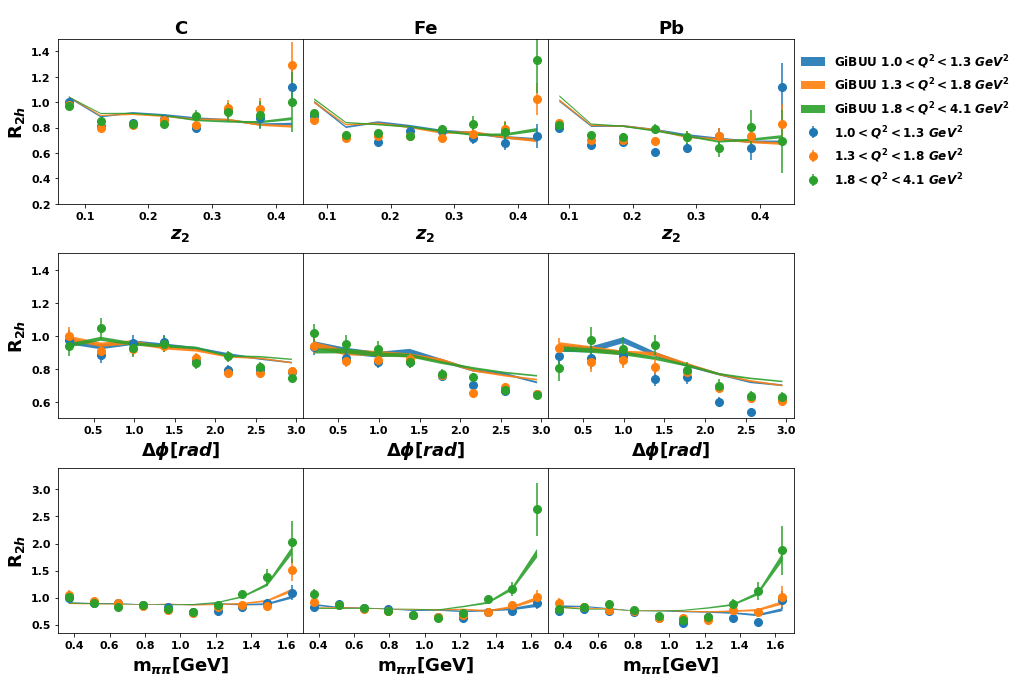

In [98]:
fig, axs = plt.subplots(3, 3,sharex=False, sharey=False,figsize=(14,10),gridspec_kw={'hspace': 0.3, 'wspace':0.})

nulabel = {} 
nulabel['bin_1'] = r'$1.0<Q^{2}<1.3$ $GeV^{2}$' 
nulabel['bin_2'] = r'$1.3<Q^{2}<1.8$ $GeV^{2}$' 
nulabel['bin_3'] = r'$1.8<Q^{2}<4.1$ $GeV^{2}$' 

for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2, nbins=dpionz2Bins, variable='h2_z', 
                               pair_cut ='%s and Q2>1.0 and Q2<1.3 and abs(h1_pid)==211 and abs(h2_pid)==211'%pair_cut_nom,
                               trig_cut ='%s and Q2>1.0 and Q2<1.3 and abs(h1_pid)==211'%trigger_cut_nom )
    axs[0][i].errorbar(x2+0.005*i,r2,yerr=err2,label=nulabel['bin_1']if i == 0 else "",fmt='o',ms=8) 
    
for i,target in enumerate(['C','Fe','Pb']):    
    r3, err3,x3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2, nbins=dpionz2Bins, variable='h2_z', 
                               pair_cut = '%s and Q2>1.3 and Q2<1.8  and abs(h1_pid)==211 and abs(h2_pid)==211'%pair_cut_nom,
                               trig_cut ='%s and Q2>1.3 and Q2<1.8 and abs(h1_pid)==211'%trigger_cut_nom )
    axs[0][i].errorbar(x3+0.005*i,r3,yerr=err3,label=nulabel['bin_2']if i == 0 else "",fmt='o',ms=8) 

for i,target in enumerate(['C','Fe','Pb']):    
    r4, err4,x4 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2, nbins=dpionz2Bins, variable='h2_z', 
                               pair_cut = '%s and Q2>1.8 and Q2<4.1 and abs(h1_pid)==211 and abs(h2_pid)==211'%pair_cut_nom,
                               trig_cut ='%s and Q2>1.8 and Q2<4.1 and abs(h1_pid)==211'%trigger_cut_nom )
    axs[0][i].errorbar(x4+0.005*i,r4,yerr=err4,label=nulabel['bin_3']if i == 0 else "",fmt='o',ms=8) 

 #GiBUU    

for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,variable='h2_z',minz=minz2,maxz=maxz2, nbins=dpionz2Bins, applyweight=False, 
                        pair_cut = ' and Q2>1.0 and Q2<1.3  and abs(h1_pid)==211 and abs(h2_pid)==211', 
                            trig_cut='Q2>1.0 and Q2<1.3 and  h1_z>0.5 and abs(h1_pid)==211')
    axs[0][i].fill_between(x+0.005*i,r-err,r+err,label='GiBUU %s'%nulabel['bin_1'] if i == 0 else "",alpha=0.9,lw=5)
    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,variable='h2_z',minz=minz2,maxz=maxz2, nbins=dpionz2Bins, applyweight=False, 
                        pair_cut = ' and Q2>1.3 and Q2<1.8  and abs(h1_pid)==211 and abs(h2_pid)==211', 
                            trig_cut='Q2>1.3 and Q2<1.8 and  h1_z>0.5 and abs(h1_pid)==211')
    axs[0][i].fill_between(x+0.005*i,r-err,r+err,label='GiBUU %s'%nulabel['bin_2'] if i == 0 else "",alpha=0.9,lw=5)
    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,variable='h2_z',minz=minz2,maxz=maxz2, nbins=dpionz2Bins, applyweight=False, 
                        pair_cut = ' and Q2>1.8 and Q2<4.1  and abs(h1_pid)==211 and abs(h2_pid)==211', 
                            trig_cut='Q2>1.8 and Q2<4.1 and  h1_z>0.5 and abs(h1_pid)==211')
    axs[0][i].fill_between(x+0.005*i,r-err,r+err,label='GiBUU %s'%nulabel['bin_3'] if i == 0 else "",alpha=0.9,lw=5)
    
### Dphi
dphiBins=8

for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi, variable='dphi', 
                               pair_cut ='%s and Q2>1.0 and Q2<1.3 and abs(h1_pid)==211 and abs(h2_pid)==211 and h2_z>0.1  and h2_z<0.5'%pair_cut_nom,
                               trig_cut ='%s and Q2>1.0 and Q2<1.3 and abs(h1_pid)==211'%trigger_cut_nom, nbins=dpiondphiBins )
    axs[1][i].errorbar(x2+0.005*i,r2,yerr=err2,fmt='o',ms=8) 
    
for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi, variable='dphi', 
                               pair_cut ='%s and Q2>1.3 and Q2<1.8 and abs(h1_pid)==211 and abs(h2_pid)==211 and h2_z>0.1  and h2_z<0.5'%pair_cut_nom,
                               trig_cut ='%s and Q2>1.3 and Q2<1.8 and abs(h1_pid)==211'%trigger_cut_nom, nbins=dpiondphiBins )
    axs[1][i].errorbar(x2+0.005*i,r2,yerr=err2,fmt='o',ms=8) 
    
for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi, variable='dphi', 
                               pair_cut ='%s and Q2>1.8 and Q2<4.1 and abs(h1_pid)==211 and abs(h2_pid)==211 and h2_z>0.1  and h2_z<0.5'%pair_cut_nom,
                               trig_cut ='%s and Q2>1.8 and Q2<4.1 and abs(h1_pid)==211'%trigger_cut_nom, nbins=dpiondphiBins )
    axs[1][i].errorbar(x2+0.005*i,r2,yerr=err2,fmt='o',ms=8) 

 #GiBUU    

for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=mindphi,maxz=maxdphi, variable='dphi',  applyweight=False,  nbins=dpiondphiBins,
                        pair_cut = 'and Q2>1.0 and Q2<1.3 and h2_z>0.1  and h2_z<0.5 and abs(h1_pid)==211 and abs(h2_pid)==211', 
                            trig_cut='Q2>1.0 and Q2<1.3 and h1_z>0.5 and abs(h1_pid)==211')
    axs[1][i].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)
    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=mindphi,maxz=maxdphi, variable='dphi',  applyweight=False,  nbins=dpiondphiBins,
                        pair_cut = 'and Q2>1.3 and Q2<1.8 and h2_z>0.1  and h2_z<0.5 and abs(h1_pid)==211 and abs(h2_pid)==211', 
                            trig_cut='Q2>1.3 and Q2<1.8 and h1_z>0.5 and abs(h1_pid)==211')
    axs[1][i].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)
    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=mindphi,maxz=maxdphi, variable='dphi',  applyweight=False,  nbins=dpiondphiBins,
                        pair_cut = 'and Q2>1.8 and Q2<4.1 and h2_z>0.1  and h2_z<0.5 and abs(h1_pid)==211 and abs(h2_pid)==211', 
                            trig_cut='Q2>1.8 and Q2<4.1 and h1_z>0.5 and abs(h1_pid)==211')
    axs[1][i].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)

### Inv Mass

for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass',
                               pair_cut ='%s and Q2>1.0 and Q2<1.3 and abs(h1_pid)==211 and abs(h2_pid)==211 and h2_z>0.1 '%pair_cut_nom,
                               trig_cut ='%s and Q2>1.0 and Q2<1.3 and abs(h1_pid)==211'%trigger_cut_nom)
    axs[2][i].errorbar(x2+0.005*i,r2,yerr=err2,fmt='o',ms=8) 
    
for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass',
                               pair_cut ='%s and Q2>1.3 and Q2<1.8 and abs(h1_pid)==211 and abs(h2_pid)==211 and h2_z>0.1 '%pair_cut_nom,
                               trig_cut ='%s and Q2>1.3 and Q2<1.8 and abs(h1_pid)==211'%trigger_cut_nom)
    axs[2][i].errorbar(x2+0.005*i,r2,yerr=err2,fmt='o',ms=8) 
    
for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass',
                               pair_cut ='%s and Q2>1.8 and Q2<4.1 and abs(h1_pid)==211 and abs(h2_pid)==211 and h2_z>0.1 '%pair_cut_nom,
                               trig_cut ='%s and Q2>1.8 and Q2<4.1 and abs(h1_pid)==211'%trigger_cut_nom)
    axs[2][i].errorbar(x2+0.005*i,r2,yerr=err2,fmt='o',ms=8) 
    

 #GiBUU    

for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass',  applyweight=False, 
                        pair_cut = 'and Q2>1.0 and Q2<1.3 and h2_z>0.1  and h2_z<0.5 and abs(h1_pid)==211 and abs(h2_pid)==211', 
                            trig_cut=' Q2>1.0 and Q2<1.3 and h1_z>0.5 and abs(h1_pid)==211')
    axs[2][i].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)
    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass',  applyweight=False, 
                        pair_cut = 'and Q2>1.3 and Q2<1.8 and h2_z>0.1  and h2_z<0.5 and abs(h1_pid)==211 and abs(h2_pid)==211', 
                            trig_cut=' Q2>1.3 and Q2<1.8 and h1_z>0.5 and abs(h1_pid)==211')
    axs[2][i].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)
    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass',  applyweight=False, 
                        pair_cut = 'and  Q2>1.8 and Q2<4.1 and h2_z>0.1  and h2_z<0.5 and abs(h1_pid)==211 and abs(h2_pid)==211', 
                            trig_cut=' Q2>1.8 and Q2<4.1 and h1_z>0.5 and abs(h1_pid)==211')
    axs[2][i].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)

    
for i in range(3):    
    axs[0][i].set_xlabel('$z_{2}$',fontsize=18)
    axs[1][i].set_xlabel('$\Delta \phi [rad]$',fontsize=18)
    axs[2][i].set_xlabel('m$_{\pi\pi}$[GeV]',fontsize=18,fontweight='bold')

    
axs[0][0].set_title('C',fontsize=18,fontweight='bold')
axs[0][1].set_title('Fe',fontsize=18,fontweight='bold')
axs[0][2].set_title('Pb',fontsize=18,fontweight='bold')
#axs[0][0].set_ylabel('C \n R$_{2h}$',fontsize=18,fontweight='bold')
#axs[1][0].set_ylabel('Fe \n R$_{2h}$',fontsize=18,fontweight='bold')
#axs[2][0].set_ylabel('Pb \n R$_{2h}$',fontsize=18,fontweight='bold')

    
axs[0][0].set_ylabel('R$_{2h}$',fontsize=18,fontweight='bold')
axs[1][0].set_ylabel('R$_{2h}$',fontsize=18,fontweight='bold')
axs[2][0].set_ylabel('R$_{2h}$',fontsize=18,fontweight='bold')
for i in range(3): 
    axs[0][i].set_ylim([0.2,1.5])
    axs[1][i].set_ylim([0.5,1.5])
    axs[2][i].set_ylim([0.35,3.4])

#for i in range(3):    
#    axs[i][1].set_ylim([0.5,1.5])
#    axs[i][0].set_ylim([0.2,1.5])
#    axs[i][2].set_ylim([0.35,3.4])
    
#axs[0].set_xlim([0.00,0.5])
for i in range(0,3):    
    #axs[i][0].axhline(y=1.0,color='black',linestyle='--')
    #axs[i].legend(loc='best',frameon=False,fontsize=13.5,ncol=2 )
    #axs[i][0].grid(True, axis='x',color='gainsboro', linestyle='dashed')
    #axs[i][0].grid(True, axis='y',color='gainsboro', linestyle='dashed')
    
    #axs[i][0].tick_params(axis='y', which='major', labelsize=11)
    axs[i][0].tick_params(axis='both', which='major', labelsize=11)    
    axs[i][1].tick_params(axis='both', which='major', labelsize=11)
    axs[i][2].tick_params(axis='both', which='major', labelsize=11)
for i in range(1,3):
    axs[0][i].yaxis.set_visible(False)    
    axs[1][i].yaxis.set_visible(False)    
    axs[2][i].yaxis.set_visible(False)      

plt.subplots_adjust(right=0.78, top=0.95, left=0.05)
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=12, borderaxespad=0.3, title='\n')
##plt.savefig('ComparisonWithHermes_Linear.png')
#plt.yscale('log')
#plt.savefig('R2hPairs_Q2Bins.pdf', bbox_inches='tight')
#plt.savefig('R2hPairs_Q2Bins.png', bbox_inches='tight')

plt.show()

**R2h factor as a function of $\Theta_{lab}$**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

/home/seba/di-hadron/R2h_module.py:15: RuntimeWarning: invalid value encountered in true_divide
  err_A = np.true_divide(np.sqrt(erry_A),y_A)
/home/seba/di-hadron/R2h_module.py:16: RuntimeWarning: invalid value encountered in true_divide
  err_D = np.true_divide(np.sqrt(erry_D),y_D)
/home/seba/di-hadron/R2h_module.py:19: RuntimeWarning: invalid value encountered in true_divide
  ratio_conditional = np.true_divide(y_A,y_D)


Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

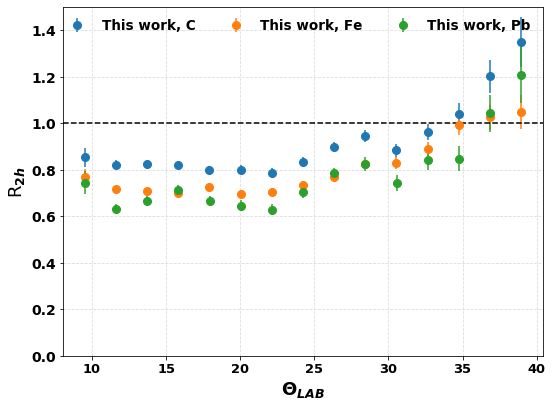

In [99]:
fig = plt.figure(figsize=(8,6))

for i,target in enumerate(['C','Fe','Pb']):
    r, err,x = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=40, variable='h1_th', nbins=20,
                        pair_cut = pair_cut_nom,trig_cut = trigger_cut_nom)
    plt.errorbar(x+0.005*i,r,yerr=err,label='This work, %s'%target,fmt='o',ms=8) ## 'fmt' is for formatting
    
#plt.errorbar(np.subtract(x,-i*0.005),r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',
#alpha=0.99,color=colors[target])
#plt.fill_between(np.subtract(x,-i*0.005), r*0.94,r*1.04, color=colors[target],alpha=0.2)

plt.xlabel('$\Theta_{LAB}$',fontsize=18)
plt.ylabel('R$_{2h}$',fontsize=18)

plt.ylim([0.,1.5])
#plt.xlim([0.00,0.5])
plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(loc='best',frameon=False,fontsize=13.5,ncol=3 )

plt.tight_layout()
##plt.savefig('ComparisonWithHermes_Linear.png')
#plt.ylim([0.55,1.85]) 

#plt.yscale('log')
##plt.savefig('ComparisonWithHermes_Log.png')
plt.grid(True, axis='x',color='gainsboro', linestyle='dashed')
plt.grid(True, axis='y',color='gainsboro', linestyle='dashed')
#plt.xticks(np.arange(0.1,0.5,0.05),fontsize=14)
plt.yticks(fontsize=14)

##plt.savefig('ComparisonWithHermes_Linear.pdf', bbox_inches='tight')
plt.show()

**R2h factor as a function of Xf**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

/home/seba/di-hadron/R2h_module.py:19: RuntimeWarning: divide by zero encountered in true_divide
  ratio_conditional = np.true_divide(y_A,y_D)


Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

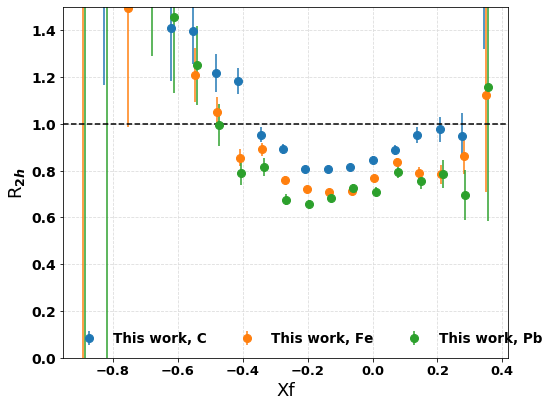

In [100]:
fig = plt.figure(figsize=(8,6))

for i,target in enumerate(['C','Fe','Pb']):
    r, err,x = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=-1.0,maxz=1.0, variable='h2_xf', nbins=30,
                        pair_cut = pair_cut_nom,trig_cut = trigger_cut_nom)
    plt.errorbar(x+0.005*i,r,yerr=err,label='This work, %s'%target,fmt='o',ms=8) ## 'fmt' is for formatting
    
#plt.errorbar(np.subtract(x,-i*0.005),r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',
#alpha=0.99,color=colors[target])
#plt.fill_between(np.subtract(x,-i*0.005), r*0.94,r*1.04, color=colors[target],alpha=0.2)

plt.xlabel('Xf',fontsize=18)
plt.ylabel('R$_{2h}$',fontsize=18)

plt.ylim([0.,1.5])
#plt.xlim([0.00,0.5])
plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(loc='best',frameon=False,fontsize=13.5,ncol=3 )

plt.tight_layout()
##plt.savefig('ComparisonWithHermes_Linear.png')
#plt.ylim([0.55,1.85]) 

#plt.yscale('log')
##plt.savefig('ComparisonWithHermes_Log.png')
plt.grid(True, axis='x',color='gainsboro', linestyle='dashed')
plt.grid(True, axis='y',color='gainsboro', linestyle='dashed')
#plt.xticks(np.arange(0.1,0.5,0.05),fontsize=14)
plt.yticks(fontsize=14)

##plt.savefig('ComparisonWithHermes_Linear.pdf', bbox_inches='tight')
plt.show()

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and Q2>1.0 and Q2<1.3 and abs(h1_pid)==211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and Q2>1.3 and Q2<1.8 and abs(h1_pid)==211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and Q2>1.8 and Q2<4.1 and abs(h1_pid)==211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and Q2>1.0 and Q2<1.3 and abs(h1_pid)==211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and Q2>1.8 and Q2<4.1 and abs(h1_pid)==211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*

Print Trigger Cut  Q2>1.3 and Q2<1.8 and h1_z>0.5 and abs(h1_pid)==211
Total Cut  Q2>1.3 and Q2<1.8 and h1_z>0.5 and abs(h1_pid)==211and Q2>1.3 and Q2<1.8 and h2_z>0.1  and h2_z<0.5 and abs(h1_pid)==211 and abs(h2_pid)==211
Print Trigger Cut  Q2>1.3 and Q2<1.8 and h1_z>0.5 and abs(h1_pid)==211
Total Cut  Q2>1.3 and Q2<1.8 and h1_z>0.5 and abs(h1_pid)==211and Q2>1.3 and Q2<1.8 and h2_z>0.1  and h2_z<0.5 and abs(h1_pid)==211 and abs(h2_pid)==211
Print Trigger Cut  Q2>1.3 and Q2<1.8 and h1_z>0.5 and abs(h1_pid)==211
Total Cut  Q2>1.3 and Q2<1.8 and h1_z>0.5 and abs(h1_pid)==211and Q2>1.3 and Q2<1.8 and h2_z>0.1  and h2_z<0.5 and abs(h1_pid)==211 and abs(h2_pid)==211
Print Trigger Cut  Q2>1.8 and Q2<4.1 and h1_z>0.5 and abs(h1_pid)==211
Total Cut  Q2>1.8 and Q2<4.1 and h1_z>0.5 and abs(h1_pid)==211and Q2>1.8 and Q2<4.1 and h2_z>0.1  and h2_z<0.5 and abs(h1_pid)==211 and abs(h2_pid)==211
Print Trigger Cut  Q2>1.8 and Q2<4.1 and h1_z>0.5 and abs(h1_pid)==211
Total Cut  Q2>1.8 and Q2<4.1 and 

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and Q2>1.3 and Q2<1.8 and abs(h1_pid)==211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and Q2>1.8 and Q2<4.1 and abs(h1_pid)==211
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*

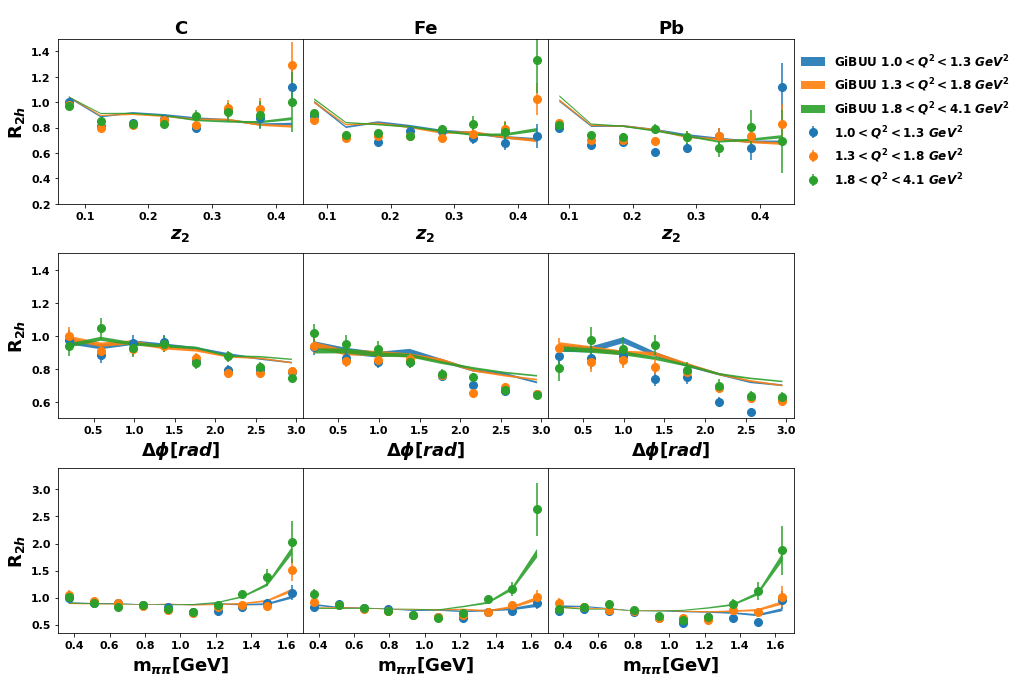

In [101]:
fig, axs = plt.subplots(3, 3,sharex=False, sharey=False,figsize=(14,10),gridspec_kw={'hspace': 0.3, 'wspace':0.})

nulabel = {} 
nulabel['bin_1'] = r'$1.0<Q^{2}<1.3$ $GeV^{2}$' 
nulabel['bin_2'] = r'$1.3<Q^{2}<1.8$ $GeV^{2}$' 
nulabel['bin_3'] = r'$1.8<Q^{2}<4.1$ $GeV^{2}$' 

for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2, nbins=dpionz2Bins, variable='h2_z', 
                               pair_cut ='%s and Q2>1.0 and Q2<1.3 and abs(h1_pid)==211 and abs(h2_pid)==211'%pair_cut_nom,
                               trig_cut ='%s and Q2>1.0 and Q2<1.3 and abs(h1_pid)==211'%trigger_cut_nom )
    axs[0][i].errorbar(x2+0.005*i,r2,yerr=err2,label=nulabel['bin_1']if i == 0 else "",fmt='o',ms=8) 
    
for i,target in enumerate(['C','Fe','Pb']):    
    r3, err3,x3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2, nbins=dpionz2Bins, variable='h2_z', 
                               pair_cut = '%s and Q2>1.3 and Q2<1.8  and abs(h1_pid)==211 and abs(h2_pid)==211'%pair_cut_nom,
                               trig_cut ='%s and Q2>1.3 and Q2<1.8 and abs(h1_pid)==211'%trigger_cut_nom )
    axs[0][i].errorbar(x3+0.005*i,r3,yerr=err3,label=nulabel['bin_2']if i == 0 else "",fmt='o',ms=8) 

for i,target in enumerate(['C','Fe','Pb']):    
    r4, err4,x4 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2, nbins=dpionz2Bins, variable='h2_z', 
                               pair_cut = '%s and Q2>1.8 and Q2<4.1 and abs(h1_pid)==211 and abs(h2_pid)==211'%pair_cut_nom,
                               trig_cut ='%s and Q2>1.8 and Q2<4.1 and abs(h1_pid)==211'%trigger_cut_nom )
    axs[0][i].errorbar(x4+0.005*i,r4,yerr=err4,label=nulabel['bin_3']if i == 0 else "",fmt='o',ms=8) 

 #GiBUU    

for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,variable='h2_z',minz=minz2,maxz=maxz2, nbins=dpionz2Bins, applyweight=False, 
                        pair_cut = ' and Q2>1.0 and Q2<1.3  and abs(h1_pid)==211 and abs(h2_pid)==211', 
                            trig_cut='Q2>1.0 and Q2<1.3 and  h1_z>0.5 and abs(h1_pid)==211')
    axs[0][i].fill_between(x+0.005*i,r-err,r+err,label='GiBUU %s'%nulabel['bin_1'] if i == 0 else "",alpha=0.9,lw=5)
    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,variable='h2_z',minz=minz2,maxz=maxz2, nbins=dpionz2Bins, applyweight=False, 
                        pair_cut = ' and Q2>1.3 and Q2<1.8  and abs(h1_pid)==211 and abs(h2_pid)==211', 
                            trig_cut='Q2>1.3 and Q2<1.8 and  h1_z>0.5 and abs(h1_pid)==211')
    axs[0][i].fill_between(x+0.005*i,r-err,r+err,label='GiBUU %s'%nulabel['bin_2'] if i == 0 else "",alpha=0.9,lw=5)
    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,variable='h2_z',minz=minz2,maxz=maxz2, nbins=dpionz2Bins, applyweight=False, 
                        pair_cut = ' and Q2>1.8 and Q2<4.1  and abs(h1_pid)==211 and abs(h2_pid)==211', 
                            trig_cut='Q2>1.8 and Q2<4.1 and  h1_z>0.5 and abs(h1_pid)==211')
    axs[0][i].fill_between(x+0.005*i,r-err,r+err,label='GiBUU %s'%nulabel['bin_3'] if i == 0 else "",alpha=0.9,lw=5)
    
### Dphi
dphiBins=8

for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi, variable='dphi', 
                               pair_cut ='%s and Q2>1.0 and Q2<1.3 and abs(h1_pid)==211 and abs(h2_pid)==211 and h2_z>0.1  and h2_z<0.5'%pair_cut_nom,
                               trig_cut ='%s and Q2>1.0 and Q2<1.3 and abs(h1_pid)==211'%trigger_cut_nom, nbins=dpiondphiBins )
    axs[1][i].errorbar(x2+0.005*i,r2,yerr=err2,fmt='o',ms=8) 
    
for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi, variable='dphi', 
                               pair_cut ='%s and Q2>1.3 and Q2<1.8 and abs(h1_pid)==211 and abs(h2_pid)==211 and h2_z>0.1  and h2_z<0.5'%pair_cut_nom,
                               trig_cut ='%s and Q2>1.3 and Q2<1.8 and abs(h1_pid)==211'%trigger_cut_nom, nbins=dpiondphiBins )
    axs[1][i].errorbar(x2+0.005*i,r2,yerr=err2,fmt='o',ms=8) 
    
for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi, variable='dphi', 
                               pair_cut ='%s and Q2>1.8 and Q2<4.1 and abs(h1_pid)==211 and abs(h2_pid)==211 and h2_z>0.1  and h2_z<0.5'%pair_cut_nom,
                               trig_cut ='%s and Q2>1.8 and Q2<4.1 and abs(h1_pid)==211'%trigger_cut_nom, nbins=dpiondphiBins )
    axs[1][i].errorbar(x2+0.005*i,r2,yerr=err2,fmt='o',ms=8) 

 #GiBUU    

for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=mindphi,maxz=maxdphi, variable='dphi',  applyweight=False,  nbins=dpiondphiBins,
                        pair_cut = 'and Q2>1.0 and Q2<1.3 and h2_z>0.1  and h2_z<0.5 and abs(h1_pid)==211 and abs(h2_pid)==211', 
                            trig_cut='Q2>1.0 and Q2<1.3 and h1_z>0.5 and abs(h1_pid)==211')
    axs[1][i].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)
    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=mindphi,maxz=maxdphi, variable='dphi',  applyweight=False,  nbins=dpiondphiBins,
                        pair_cut = 'and Q2>1.3 and Q2<1.8 and h2_z>0.1  and h2_z<0.5 and abs(h1_pid)==211 and abs(h2_pid)==211', 
                            trig_cut='Q2>1.3 and Q2<1.8 and h1_z>0.5 and abs(h1_pid)==211')
    axs[1][i].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)
    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=mindphi,maxz=maxdphi, variable='dphi',  applyweight=False,  nbins=dpiondphiBins,
                        pair_cut = 'and Q2>1.8 and Q2<4.1 and h2_z>0.1  and h2_z<0.5 and abs(h1_pid)==211 and abs(h2_pid)==211', 
                            trig_cut='Q2>1.8 and Q2<4.1 and h1_z>0.5 and abs(h1_pid)==211')
    axs[1][i].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)

### Inv Mass

for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass',
                               pair_cut ='%s and Q2>1.0 and Q2<1.3 and abs(h1_pid)==211 and abs(h2_pid)==211 and h2_z>0.1 '%pair_cut_nom,
                               trig_cut ='%s and Q2>1.0 and Q2<1.3 and abs(h1_pid)==211'%trigger_cut_nom)
    axs[2][i].errorbar(x2+0.005*i,r2,yerr=err2,fmt='o',ms=8) 
    
for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass',
                               pair_cut ='%s and Q2>1.3 and Q2<1.8 and abs(h1_pid)==211 and abs(h2_pid)==211 and h2_z>0.1 '%pair_cut_nom,
                               trig_cut ='%s and Q2>1.3 and Q2<1.8 and abs(h1_pid)==211'%trigger_cut_nom)
    axs[2][i].errorbar(x2+0.005*i,r2,yerr=err2,fmt='o',ms=8) 
    
for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass',
                               pair_cut ='%s and Q2>1.8 and Q2<4.1 and abs(h1_pid)==211 and abs(h2_pid)==211 and h2_z>0.1 '%pair_cut_nom,
                               trig_cut ='%s and Q2>1.8 and Q2<4.1 and abs(h1_pid)==211'%trigger_cut_nom)
    axs[2][i].errorbar(x2+0.005*i,r2,yerr=err2,fmt='o',ms=8) 
    

 #GiBUU    

for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass',  applyweight=False, 
                        pair_cut = 'and Q2>1.0 and Q2<1.3 and h2_z>0.1  and h2_z<0.5 and abs(h1_pid)==211 and abs(h2_pid)==211', 
                            trig_cut=' Q2>1.0 and Q2<1.3 and h1_z>0.5 and abs(h1_pid)==211')
    axs[2][i].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)
    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass',  applyweight=False, 
                        pair_cut = 'and Q2>1.3 and Q2<1.8 and h2_z>0.1  and h2_z<0.5 and abs(h1_pid)==211 and abs(h2_pid)==211', 
                            trig_cut=' Q2>1.3 and Q2<1.8 and h1_z>0.5 and abs(h1_pid)==211')
    axs[2][i].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)
    
for i,target in enumerate(['C','Fe','Pb']):    
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,variable='pair_mass',  applyweight=False, 
                        pair_cut = 'and  Q2>1.8 and Q2<4.1 and h2_z>0.1  and h2_z<0.5 and abs(h1_pid)==211 and abs(h2_pid)==211', 
                            trig_cut=' Q2>1.8 and Q2<4.1 and h1_z>0.5 and abs(h1_pid)==211')
    axs[2][i].fill_between(x+0.005*i,r-err,r+err,alpha=0.9,lw=5)

    
for i in range(3):    
    axs[0][i].set_xlabel('$z_{2}$',fontsize=18)
    axs[1][i].set_xlabel('$\Delta \phi [rad]$',fontsize=18)
    axs[2][i].set_xlabel('m$_{\pi\pi}$[GeV]',fontsize=18,fontweight='bold')

    
axs[0][0].set_title('C',fontsize=18,fontweight='bold')
axs[0][1].set_title('Fe',fontsize=18,fontweight='bold')
axs[0][2].set_title('Pb',fontsize=18,fontweight='bold')
#axs[0][0].set_ylabel('C \n R$_{2h}$',fontsize=18,fontweight='bold')
#axs[1][0].set_ylabel('Fe \n R$_{2h}$',fontsize=18,fontweight='bold')
#axs[2][0].set_ylabel('Pb \n R$_{2h}$',fontsize=18,fontweight='bold')

    
axs[0][0].set_ylabel('R$_{2h}$',fontsize=18,fontweight='bold')
axs[1][0].set_ylabel('R$_{2h}$',fontsize=18,fontweight='bold')
axs[2][0].set_ylabel('R$_{2h}$',fontsize=18,fontweight='bold')
for i in range(3): 
    axs[0][i].set_ylim([0.2,1.5])
    axs[1][i].set_ylim([0.5,1.5])
    axs[2][i].set_ylim([0.35,3.4])

#for i in range(3):    
#    axs[i][1].set_ylim([0.5,1.5])
#    axs[i][0].set_ylim([0.2,1.5])
#    axs[i][2].set_ylim([0.35,3.4])
    
#axs[0].set_xlim([0.00,0.5])
for i in range(0,3):    
    #axs[i][0].axhline(y=1.0,color='black',linestyle='--')
    #axs[i].legend(loc='best',frameon=False,fontsize=13.5,ncol=2 )
    #axs[i][0].grid(True, axis='x',color='gainsboro', linestyle='dashed')
    #axs[i][0].grid(True, axis='y',color='gainsboro', linestyle='dashed')
    
    #axs[i][0].tick_params(axis='y', which='major', labelsize=11)
    axs[i][0].tick_params(axis='both', which='major', labelsize=11)    
    axs[i][1].tick_params(axis='both', which='major', labelsize=11)
    axs[i][2].tick_params(axis='both', which='major', labelsize=11)
for i in range(1,3):
    axs[0][i].yaxis.set_visible(False)    
    axs[1][i].yaxis.set_visible(False)    
    axs[2][i].yaxis.set_visible(False)      

plt.subplots_adjust(right=0.78, top=0.95, left=0.05)
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=12, borderaxespad=0.3, title='\n')
##plt.savefig('ComparisonWithHermes_Linear.png')
#plt.yscale('log')
##plt.savefig('R2hPairs_Q2Bins.pdf', bbox_inches='tight')
##plt.savefig('R2hPairs_Q2Bins.png', bbox_inches='tight')

plt.show()

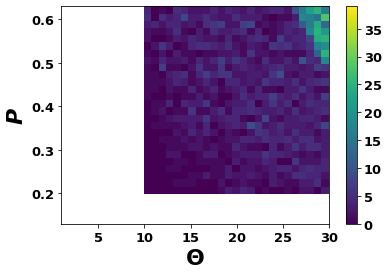

In [102]:
query = 'Q2>1 %s'%pair_cut_nom
h =plt.hist2d(df['Fe'].query(query)['h2_th'], df['Fe'].query(query)['h2_p'], 
              bins=(100, 100), cmap=plt.cm.viridis)
plt.xlim(1.,30) 
plt.ylim(0.13,0.63) 
plt.colorbar()
plt.xlabel('$\Theta$', fontsize=22,fontweight='bold')
plt.ylabel('$P$', fontsize=22,fontweight='bold')
##plt.savefig('2D_paitPt2_ztot.png', bbox_inches='tight')  
plt.show()


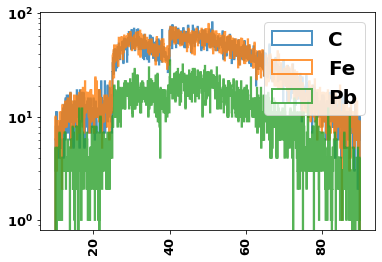

In [103]:
extra_cut = ' and ( (h2_pid==211) or (h2_pid==-211 and h2_th>25 and h2_th<90) or (h2_pid==-211 and h2_th<40 and h2_th>25 and h2_p>0.5))'

for i,target in enumerate(['C','Fe','Pb']):
    
    y, x, _ = plt.hist(df[target].query('Q2>1 '+pair_cut_nom)['h2_th'],alpha=0.8,lw=2,
                       bins=1000,histtype='step',  label=target, density=False)

#plt.xlim(100,130)  
plt.yscale('log')
plt.xticks(rotation='vertical')
plt.legend()    
plt.show()

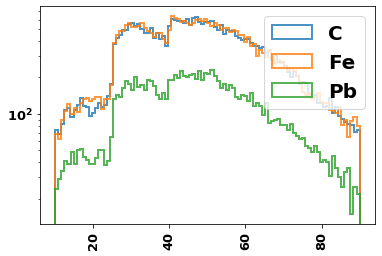

In [104]:

for i,target in enumerate(['C','Fe','Pb']):
    
    y, x, _ = plt.hist(df[target].query('Q2>1 '+pair_cut_nom)['h2_th'],alpha=0.8,lw=2,
                       bins=100,histtype='step',  label=target, density=False)

#plt.xlim(10,30)  
plt.yscale('log')
plt.xticks(rotation='vertical')
plt.legend()    
plt.show()



-211
211


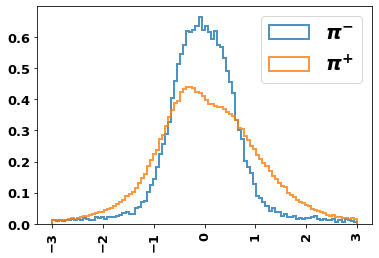

In [105]:
for i,hadron in enumerate(['-211', '211']):
    print(hadron)
    if hadron=='211':    
        name='$\pi^{+}$'
        pid=211
    if hadron=='-211':
        name='$\pi^{-}$'
        pid=-211
    y, x, _ = plt.hist(df_trigger['Fe_trigger'].query('Q2>1 and h1_pid==%s and %s'%( pid, trigger_cut_nom))['h1_deltaZ'],
                       alpha=0.8,lw=2,
                       bins=100,histtype='step',  label=name, density=True)

#plt.xlim(10,30)  
#plt.yscale('log')
plt.xticks(rotation='vertical')
plt.legend()    
plt.show()


In [106]:
%%time
df2 = {}
df2_trigger = {}
#path_data="/home/sebouh/di-hadron"
path_data2="/home/seba/di-hadron/test_dataFiles"
for target in ['C','Fe','Pb']:
    #print ('Getting dataframes from target %s'%target)
    df2[target]=getdatainChunks('%s/%s.root'%(path_data2,target), target)
    #df2['D_%s'%target]= getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 'D_%s'%target)  
    #print ('Get trigger dataframes from deuterium target %s'%target)
    #df2_trigger['%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
    #                                                  '%s_trigger'%target)
    #df2_trigger['D_%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
    #                                                    'D_%s_trigger'%target)

CPU times: user 1.08 s, sys: 38.7 ms, total: 1.12 s
Wall time: 1.23 s


In [107]:

%%time
for key in df2.keys():
    isMC = False
    if 'GiBUU' in key:
        isMC=True
    print ('\nkey: ',key)
    df2[key].rename(columns={'h1_FidCut':'h1_FidCutPiPlus'}, inplace=True)
    df2[key].rename(columns={'h2_FidCut':'h2_FidCutPiPlus'}, inplace=True)
    df2[key] = r2h.applyCuts(df2[key],isMC=isMC, nomCuts=False)
    df2[key] = r2h.applyCutsPair(df2[key],isMC=isMC, nomCuts=False)





key:  C
Entries before cut  175515
Q2>1.0 and Q2<4.0 175515  (100.00  %)
0.2<h1_p<5.0  175515  (100.00  %)
inelasticity < 0.85 175515  (100.00  %)
h1_pid = pions (trigger) 175515  (100.00  %)
2.2 < nu <4.2 175515  (100.00  %)
10< h1_th<90 175509  (100.00  %)
Theta/P fiducial region selected for trigger 175509  (100.00  %)
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 175509  (100.00  %)
2.2 < nu < 4.2 175509  (100.00  %)
secondary hadrons are pions 175509  (100.00  %)
(h1_z+h2_z)<1.0 174511  (99.43  %)
(h1_pid*h2_pid)<0, opposite charge pions 133801  (76.67  %)
kinematic limits for h2_z 132392  (98.95  %)
kinematic limits for dphi 132280  (99.92  %)
kinematic limits for pair_mass 131913  (99.72  %)
leading hadrons are pions 131913  (100.00  %)
0.2<h2_p<5.0 131913  (100.00  %)
0.2<h1_p<5.0 131913  (100.00  %)
10<h2_th<90 131765  (99.89  %)
Theta/P fiducial region selected for secondary hadron 131765  (100.00  %)
10< h1_th<90 131765  (100.00  %)
Theta/P fiducial region

-211
211


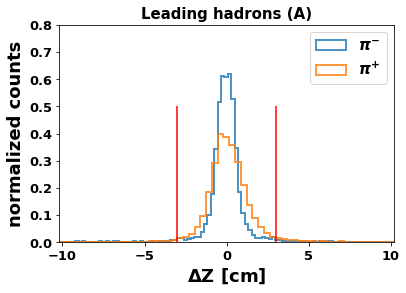

-211
211


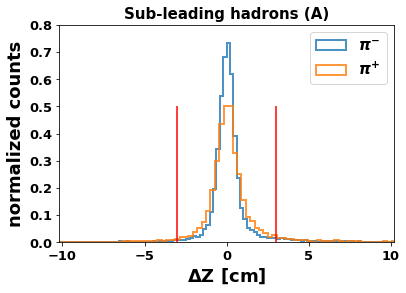

-211
211


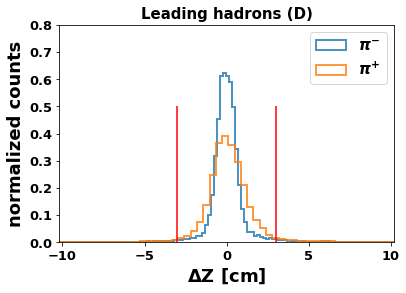

-211
211


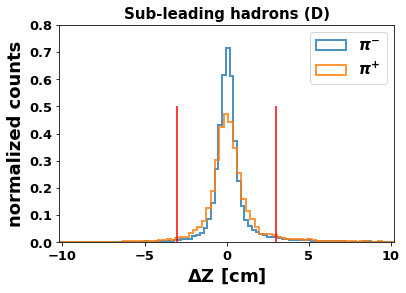

In [108]:
BINS=300
for i,hadron in enumerate(['-211', '211']):
    print(hadron)
    if hadron=='211':    
        name='$\pi^{+}$'
        pid=211
    if hadron=='-211':
        name='$\pi^{-}$'
        pid=-211
    y, x, _ = plt.hist(df2['Fe'].query('Q2>1  and h1_pid==%s and TargType==2 and abs(YC)<1.4'%( pid))['h1_deltaZ'],
                       alpha=0.8,lw=2,
                       bins=BINS,histtype='step',  label=name, density=True)

plt.xlim(-10.2,10.2)  
plt.ylim(0,0.8)  
plt.xlabel('$\Delta$Z [cm]', fontweight='bold')
plt.ylabel('normalized counts', fontweight='bold')
#plt.yscale('log')
#plt.xticks(rotation='vertical')
#plt.axhline(y=1.0,color='black',linestyle='--',alpha=0.5)
plt.vlines([-3, 3], 0, 0.5, colors='red')
plt.legend(fontsize='small' )    
plt.title('Leading hadrons (A)', fontweight='bold', size=15)
outname='deltaZcut_A_leading'
if not os.path.isdir(outdir_vertex):    os.mkdir(outdir_vertex)
plt.savefig(outdir_vertex+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_vertex+outname+'.png', bbox_inches='tight')

plt.show()


for i,hadron in enumerate(['-211', '211']):
    print(hadron)
    if hadron=='211':    
        name='$\pi^{+}$'
        pid=211
    if hadron=='-211':
        name='$\pi^{-}$'
        pid=-211
    y, x, _ = plt.hist(df2['Fe'].query('Q2>1  and abs(h1_pid)==211 and abs(h1_pid)==211 and h2_pid==%s and TargType==2 and abs(YC)<1.4'%( pid))['h2_deltaZ'],
                       alpha=0.8,lw=2,
                       bins=BINS,histtype='step',  label=name, density=True)

plt.xlim(-10.2,10.2)  
plt.ylim(0,0.8)  
plt.xlabel('$\Delta$Z [cm]', fontweight='bold')
plt.ylabel('normalized counts', fontweight='bold')
#plt.yscale('log')
plt.title('Sub-leading hadrons (A)', fontweight='bold', size=15)
#plt.xticks(rotation='vertical')
#plt.axhline(y=1.0,color='black',linestyle='--',alpha=0.5)
plt.vlines([-3, 3], 0, 0.5, colors='red')
plt.legend(fontsize='small' )
outname='deltaZcut_A_subleading'
if not os.path.isdir(outdir_vertex):    os.mkdir(outdir_vertex)
plt.savefig(outdir_vertex+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_vertex+outname+'.png', bbox_inches='tight')

plt.show()



for i,hadron in enumerate(['-211', '211']):
    print(hadron)
    if hadron=='211':    
        name='$\pi^{+}$'
        pid=211
    if hadron=='-211':
        name='$\pi^{-}$'
        pid=-211
    y, x, _ = plt.hist(df2['Fe'].query('Q2>1  and h1_pid==%s and TargType==1 and abs(YC)<1.4'%( pid))['h1_deltaZ'],
                       alpha=0.8,lw=2,
                       bins=BINS,histtype='step',  label=name, density=True)

plt.xlim(-10.2,10.2)  
plt.ylim(0,0.8)  
plt.xlabel('$\Delta$Z [cm]', fontweight='bold')
plt.ylabel('normalized counts', fontweight='bold')
#plt.yscale('log')
#plt.xticks(rotation='vertical')
#plt.axhline(y=1.0,color='black',linestyle='--',alpha=0.5)
plt.vlines([-3, 3], 0, 0.5, colors='red')
plt.legend(fontsize='small' )    
plt.title('Leading hadrons (D)', fontweight='bold', size=15)
outname='deltaZcut_D_leading'
if not os.path.isdir(outdir_vertex):    os.mkdir(outdir_vertex)
plt.savefig(outdir_vertex+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_vertex+outname+'.png', bbox_inches='tight')

plt.show()


for i,hadron in enumerate(['-211', '211']):
    print(hadron)
    if hadron=='211':    
        name='$\pi^{+}$'
        pid=211
    if hadron=='-211':
        name='$\pi^{-}$'
        pid=-211
    y, x, _ = plt.hist(df2['Fe'].query('Q2>1  and h2_pid==%s and TargType==1 and abs(YC)<1.4'%( pid))['h2_deltaZ'],
                       alpha=0.8,lw=2,
                       bins=BINS,histtype='step',  label=name, density=True)

plt.xlim(-10.2,10.2)  
plt.ylim(0,0.8)  
plt.xlabel('$\Delta$Z [cm]', fontweight='bold')
plt.ylabel('normalized counts', fontweight='bold')
#plt.yscale('log')
plt.title('Sub-leading hadrons (D)', fontweight='bold', size=15)
#plt.xticks(rotation='vertical')
#plt.axhline(y=1.0,color='black',linestyle='--',alpha=0.5)
plt.vlines([-3, 3], 0, 0.5, colors='red')
plt.legend(fontsize='small' )

outname='deltaZcut_D_subleading'
if not os.path.isdir(outdir_vertex):    os.mkdir(outdir_vertex)
plt.savefig(outdir_vertex+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_vertex+outname+'.png', bbox_inches='tight')

plt.show()

del BINS

**calculating the difference bwteen leading and subleading z-vertex i.e h1_deltaZ-h2_deltaZ**

-211
211


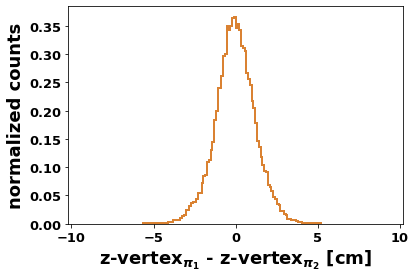

In [109]:
df2['Fe'].eval('z1_z2=h1_deltaZ-h2_deltaZ', inplace=True)

for i,hadron in enumerate(['-211', '211']):
    print(hadron)
    if hadron=='211':    
        name='$\pi^{+}$'
        pid=211
    if hadron=='-211':
        name='$\pi^{-}$'
        pid=-211
    y, x, _ = plt.hist(df2['Fe'].query('Q2>1 and (h1_pid*h2_pid)<0.  and abs(h1_deltaZ)<3.0 and abs(h2_deltaZ)<3.0 and abs(YC)<1.4 and TargType==1')['z1_z2'],
                       alpha=0.8,lw=2,
                       bins=100,histtype='step',   density=True)
    

plt.xlim(-10.2,10.2)  
plt.xlabel('z-vertex$_{\pi_{1}}$ - z-vertex$_{\pi_{2}} $ [cm]', fontweight='bold')
plt.ylabel('normalized counts', fontweight='bold')
#plt.yscale('log')
#plt.title('z-vertex (leading) - z-vertex (sub-leading)', fontweight='bold', size=15)
#plt.xticks(rotation='vertical')
#plt.axhline(y=1.0,color='black',linestyle='--',alpha=0.5)
#plt.vlines([-3, 3], 0, 1, colors='red')
#plt.legend(fontsize='small' )
##plt.savefig('Vertex_pi_data.pdf', bbox_inches='tight')  

outname='differenceZvertexPions'
if not os.path.isdir(outdir_vertex):    os.mkdir(outdir_vertex)
plt.savefig(outdir_vertex+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_vertex+outname+'.png', bbox_inches='tight')


plt.show()

**plotting the ZC coordinate to explain the vertex cuts**

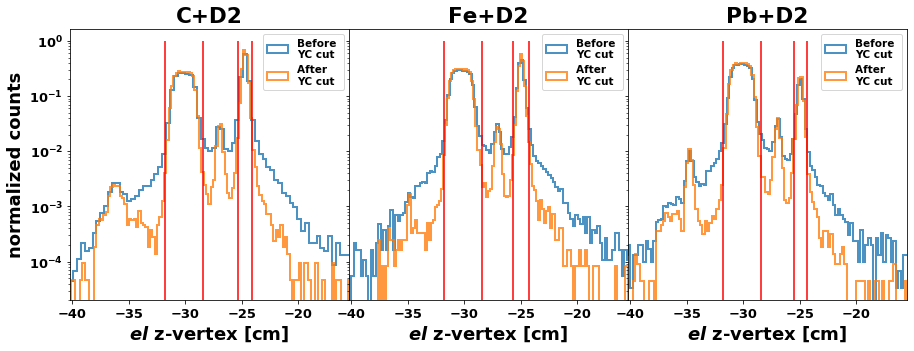

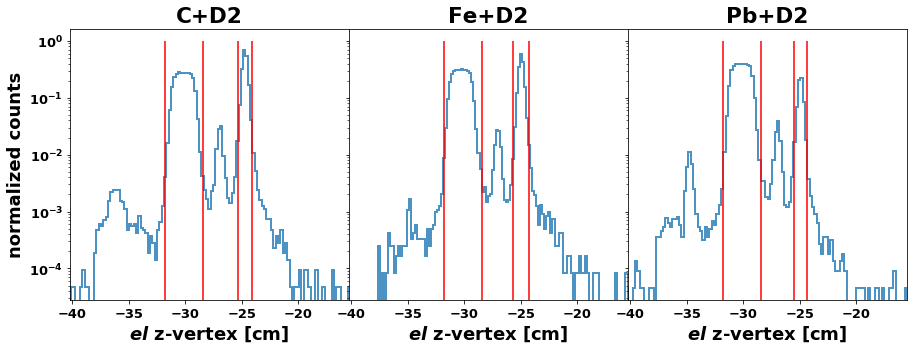

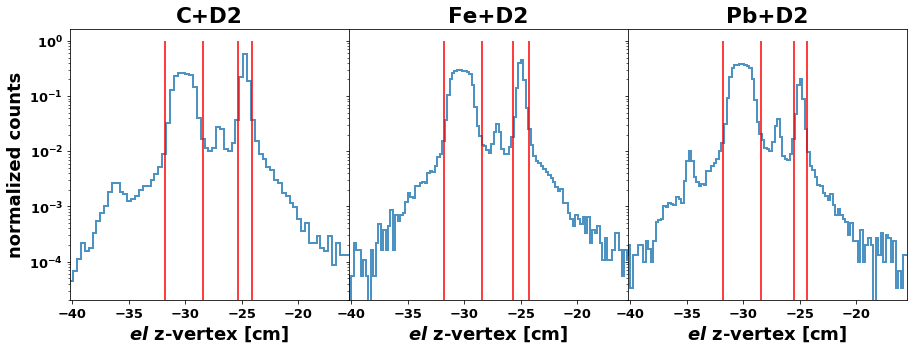

In [110]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,5),gridspec_kw={'hspace': 0., 'wspace':0.})

for i,target in enumerate(['C', 'Fe', 'Pb']):
    y, x, _ = axs[i].hist(df2[target].query('Q2>1.0')['ZC'],
                       alpha=0.8,lw=2,
                       bins=300,histtype='step', label='Before \nYC cut' , density=True)
    y, x, _ = axs[i].hist(df2[target].query('abs(YC)<1.4')['ZC'],
                       alpha=0.8,lw=2,
                       bins=300,histtype='step', label= 'After \nYC cut' , density=True)
    
    axs[i].set_xlim(-40.2,-15.5)  
    axs[i].set_xlabel('$el$ z-vertex [cm]', fontweight='bold')
    if i==0:    axs[i].set_ylabel('normalized counts', fontweight='bold')
    axs[i].set_yscale('log')
    #plt.title('Sub-leading hadrons', fontweight='bold', size=15)
    #plt.xticks(rotation='vertical')
    #plt.axhline(y=1.0,color='black',linestyle='--',alpha=0.5)
    if i==0:    
        axs[i].vlines([-25.3, -24.1], 0, 1, colors='red')
        axs[i].vlines([-31.8, -28.4], 0, 1, colors='red')
    if i==1:    
        axs[i].vlines([-25.65, -24.26], 0, 1, colors='red')
        axs[i].vlines([-31.8, -28.4], 0, 1, colors='red')
        
    if i==2:    
        axs[i].vlines([-25.54, -24.36], 0, 1, colors='red')
        axs[i].vlines([-31.8, -28.4], 0, 1, colors='red')        
        
    axs[i].legend(fontsize='xx-small' )
    ##plt.savefig('Vertex_pi_data.pdf', bbox_inches='tight')  
    #plt.show()
axs[0].set_title('C+D2', fontweight='bold')
axs[1].set_title('Fe+D2', fontweight='bold')
axs[2].set_title('Pb+D2', fontweight='bold')

outname='electron_ZC_vertex_withandwitoutYC'
if not os.path.isdir(outdir_vertex):    os.mkdir(outdir_vertex)
plt.savefig(outdir_vertex+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_vertex+outname+'.png', bbox_inches='tight')
plt.show()



fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,5),gridspec_kw={'hspace': 0., 'wspace':0.})

for i,target in enumerate(['C', 'Fe', 'Pb']):

    y, x, _ = axs[i].hist(df2[target].query('abs(YC)<1.4')['ZC'],
                       alpha=0.8,lw=2,
                       bins=300,histtype='step', label=target , density=True)
    
    axs[i].set_xlim(-40.2,-15.5)  
    axs[i].set_xlabel('$el$ z-vertex [cm]', fontweight='bold')
    if i==0:    axs[i].set_ylabel('normalized counts', fontweight='bold')
    axs[i].set_yscale('log')
    #plt.title('Sub-leading hadrons', fontweight='bold', size=15)
    #plt.xticks(rotation='vertical')
    #plt.axhline(y=1.0,color='black',linestyle='--',alpha=0.5)
    if i==0:    
        axs[i].vlines([-25.3, -24.1], 0, 1, colors='red')
        axs[i].vlines([-31.8, -28.4], 0, 1, colors='red')
    if i==1:    
        axs[i].vlines([-25.65, -24.26], 0, 1, colors='red')
        axs[i].vlines([-31.8, -28.4], 0, 1, colors='red')
        
    if i==2:    
        axs[i].vlines([-25.54, -24.36], 0, 1, colors='red')
        axs[i].vlines([-31.8, -28.4], 0, 1, colors='red')        
        
    #axs[i].legend(fontsize='small' )
    ##plt.savefig('Vertex_pi_data.pdf', bbox_inches='tight')  
    #plt.show()
axs[0].set_title('C+D2', fontweight='bold')
axs[1].set_title('Fe+D2', fontweight='bold')
axs[2].set_title('Pb+D2', fontweight='bold')

outname='electron_ZC_vertex_withYC'
if not os.path.isdir(outdir_vertex):    os.mkdir(outdir_vertex)
plt.savefig(outdir_vertex+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_vertex+outname+'.png', bbox_inches='tight')
plt.show()







fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,5),gridspec_kw={'hspace': 0., 'wspace':0.})

for i,target in enumerate(['C', 'Fe', 'Pb']):
    y, x, _ = axs[i].hist(df2[target].query('Q2>1.0')['ZC'],
                       alpha=0.8,lw=2,
                       bins=300,histtype='step', label=target , density=True)
    axs[i].set_xlim(-40.2,-15.5)  
    axs[i].set_xlabel('$el$ z-vertex [cm]', fontweight='bold')
    if i==0:    axs[i].set_ylabel('normalized counts', fontweight='bold')
    axs[i].set_yscale('log')
    #plt.title('Sub-leading hadrons', fontweight='bold', size=15)
    #plt.xticks(rotation='vertical')
    #plt.axhline(y=1.0,color='black',linestyle='--',alpha=0.5)
    if i==0:    
        axs[i].vlines([-25.3, -24.1], 0, 1, colors='red')
        axs[i].vlines([-31.8, -28.4], 0, 1, colors='red')
    if i==1:    
        axs[i].vlines([-25.65, -24.26], 0, 1, colors='red')
        axs[i].vlines([-31.8, -28.4], 0, 1, colors='red')
        
    if i==2:    
        axs[i].vlines([-25.54, -24.36], 0, 1, colors='red')
        axs[i].vlines([-31.8, -28.4], 0, 1, colors='red')        
        
    #axs[i].legend(fontsize='small' )
    ##plt.savefig('Vertex_pi_data.pdf', bbox_inches='tight')  
    #plt.show()
axs[0].set_title('C+D2', fontweight='bold')
axs[1].set_title('Fe+D2', fontweight='bold')
axs[2].set_title('Pb+D2', fontweight='bold')

outname='electron_ZC_vertex_witoutYC'
if not os.path.isdir(outdir_vertex):    os.mkdir(outdir_vertex)
plt.savefig(outdir_vertex+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_vertex+outname+'.png', bbox_inches='tight')
plt.show()



# Reproduced some studies with re-weighted MC

In [111]:
%%time
df_mc_reweighted = {}
df_mc_trigger_reweighted = {}
path_mc_reweighted="/home/sebouh/CreatePairTuples"
#path_mc="/home/sebouh/di-hadron/simul/Pairs"
for target in ['C','Fe','Pb']:
#for target in ['C','D']:
    print ('Getting dataframes from target %s'%target)
    df_mc_reweighted[target]=getdatainChunks('%s/MC_Pairs_weighted_%s.root'%(path_mc_reweighted,target), target)
    df_mc_reweighted['D_%s'%target]=getdatainChunks('%s/MC_Pairs_weighted_%s.root'%(path_mc_reweighted,target), target)
    
    df_mc_trigger_reweighted['%s_trigger'%target] = getdatainChunks('%s/MC_Pairs_weighted_%s.root'%(path_mc_reweighted,target), 
                                                         '%s_trigger'%target)
    df_mc_trigger_reweighted['D_%s_trigger'%target] = getdatainChunks('%s/MC_Pairs_weighted_%s.root'%(path_mc_reweighted,target), 
                                                         '%s_trigger'%target)


Getting dataframes from target C
Getting dataframes from target Fe
Getting dataframes from target Pb
CPU times: user 11.9 s, sys: 391 ms, total: 12.3 s
Wall time: 12.6 s


**applying the cuts to MC (reco)**

In [112]:
%%time
for key in df_mc_reweighted.keys():
    isMC = False
    if 'GiBUU' in key:
        isMC=True
    print (key)
    print('trigger cuts:\n')
    df_mc_reweighted[key] = r2h.applyCuts(df_mc_reweighted[key],isMC=isMC)
    print('pair cuts:\n')
    df_mc_reweighted[key] = r2h.applyCutsPair(df_mc_reweighted[key],isMC=isMC)    

for key in df_mc_trigger_reweighted.keys():
    print (key)
    df_mc_trigger_reweighted[key] = r2h.applyCuts(df_mc_trigger_reweighted[key],isTrigger=True)
    print (' ')


C
trigger cuts:

Entries before cut  351255
Q2>1.0 and Q2<4.0 351255  (100.00  %)
0.2<h1_p<5.0  351255  (100.00  %)
inelasticity < 0.85 351255  (100.00  %)
h1_pid = pions (trigger) 351255  (100.00  %)
2.2 < nu <4.2 351255  (100.00  %)
10< h1_th<90 351255  (100.00  %)
Theta/P fiducial region selected for trigger 351255  (100.00  %)
pair cuts:

Starting election on dipion variables
This is Data
1.0< Q2 <4.0 351255  (100.00  %)
2.2 < nu < 4.2 351255  (100.00  %)
secondary hadrons are pions 351255  (100.00  %)
(h1_z+h2_z)<1.0 351255  (100.00  %)
(h1_pid*h2_pid)<0, opposite charge pions 288963  (82.27  %)
kinematic limits for h2_z 283239  (98.02  %)
kinematic limits for dphi 282880  (99.87  %)
kinematic limits for pair_mass 271401  (95.94  %)
leading hadrons are pions 271401  (100.00  %)
0.2<h2_p<5.0 271401  (100.00  %)
0.2<h1_p<5.0 271401  (100.00  %)
10<h2_th<90 271401  (100.00  %)
Theta/P fiducial region selected for secondary hadron 271401  (100.00  %)
10< h1_th<90 271401  (100.00  %)
T

In [113]:
p_thr_MC=2.7
Nphe_thr_MC=15
Nphe_h1_cut_MC='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_MC,p_thr_MC,p_thr_MC,p_thr_MC,p_thr_MC)
Nphe_h2_cut_MC='h2_Nphe> (%d*( (h2_p*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_MC,p_thr_MC,p_thr_MC,p_thr_MC,p_thr_MC)
Chi2CC_h1_cut_MC='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_MC,p_thr_MC,p_thr_MC,p_thr_MC)
Chi2CC_h2_cut_MC='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_MC,p_thr_MC,p_thr_MC,p_thr_MC)
StatCC_h1_cut_MC='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_MC,p_thr_MC)
StatCC_h2_cut_MC='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_MC,p_thr_MC)

trigger_cut_MC_nom   ='h1_z>0.5 and %s and %s and %s  '%(Nphe_h1_cut_MC, Chi2CC_h1_cut_MC,StatCC_h1_cut_MC)
pair_cut_MC_nom  ='h1_z>0.5  and %s and %s and %s and %s and %s and %s and (h1_z+h2_z)<1.0'%(Nphe_h1_cut_MC, Nphe_h2_cut_MC,Chi2CC_h1_cut_MC,Chi2CC_h2_cut_MC,StatCC_h1_cut_MC, StatCC_h2_cut_MC)


Print Trigger Cut  h1_z> 0.5 and abs(h1_pid)==211 and h1_th<90 and h1_th>10
Total Cut  h1_z> 0.5 and abs(h1_pid)==211 and h1_th<90 and h1_th>10and  h2_z>0.1 h1_z>0.5  and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h2_Nphe> (15*( (h2_p*nu*h2_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h2_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h2_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 )

SyntaxError: Python keyword not valid identifier in numexpr query (<unknown>, line 1)

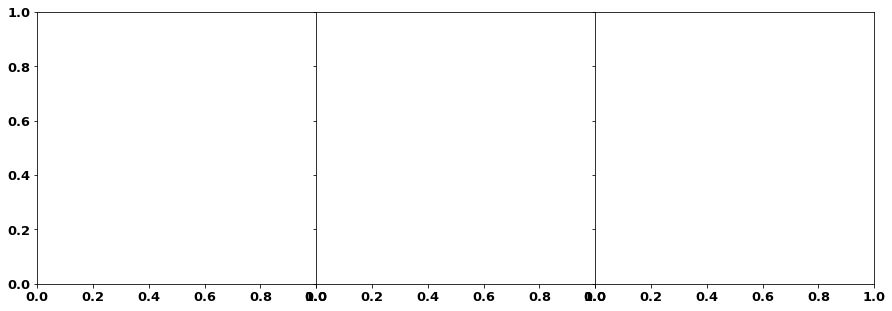

In [114]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,5),gridspec_kw={'hspace': 0., 'wspace':0.})

triCut='h1_z> 0.5 and abs(h1_pid)==211 and h1_th<90 and h1_th>10'
pairCut_1='and h1_pid==211 and abs(h2_pid)==211 and h1_z> 0.5 and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0.  and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s'%(minz2,maxz2,maxzmass ,minzmass)
pairCut_2='and h1_pid==-211 and abs(h2_pid)==211 and h1_z> 0.5 and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0.  and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s'%(minz2,maxz2,maxzmass ,minzmass)


for i,target in enumerate(['C','Fe','Pb']):
    r, err,x = r2h.getRatio(df_mc['%s'%target], df_mc['D'], 
                        df_mc_trigger['%s_trigger'%target], df_mc_trigger['D_trigger'],
                        minz=mindphi,maxz=maxdphi, variable='dphi', trig_cut='%s'%triCut,nbins=dpiondphiBins,
                           pair_cut='and  h2_z>0.1 %s'%pair_cut_MC_nom)
    
    axs[i].errorbar(x+0.01,r,yerr=err,label='All'if i == 0 else "",fmt='o',ms=8, alpha=0.7)
    r, err,x = r2h.getRatio(df_mc['%s'%target], df_mc['D'], 
                        df_mc_trigger['%s_trigger'%target], df_mc_trigger['D_trigger'],
                        minz=mindphi,maxz=maxdphi,    pair_cut='%s and h2_z>0.1'%pairCut_1, nbins=dpiondphiBins,
                            variable='dphi', trig_cut='%s'%triCut)
    axs[i].errorbar(x+0.02,r,yerr=err,label='$\pi^{+}$ trigger'if i == 0 else "",fmt='o',ms=8, alpha=0.7)
    
    
    r, err,x = r2h.getRatio(df_mc['%s'%target], df_mc['D'], 
                        df_mc_trigger['%s_trigger'%target], df_mc_trigger['D_trigger'],
                        minz=mindphi,maxz=maxdphi,   pair_cut='%s and h2_z>0.1'%pairCut_2, nbins=dpiondphiBins,
                            variable='dphi', trig_cut='%s'%triCut)
    axs[i].errorbar(x+0.03,r,yerr=err,label='$\pi^{-}$ trigger'if i == 0 else "",fmt='o',ms=8, alpha=0.7)
    

for i in range(3):    axs[i].set_xlabel(r'$\Delta \phi$ [rad]',fontsize=18, fontweight='bold')

axs[0].set_ylabel('R$_{\mathrm{2h}}$',fontsize=18, fontweight='bold')
axs[0].set_title('C', fontweight='bold')
axs[1].set_title('Fe', fontweight='bold')
axs[2].set_title('Pb', fontweight='bold')


axs[0].set_ylim([0.85,1.15])
#axs[0].set_xlim([0.00,0.5])
for i in range(0,3):    
    axs[i].axhline(y=1.0,color='black',linestyle='--')
    #axs[i].legend(loc='best',frameon=False,fontsize=13.5,ncol=2 )
    axs[i].grid(True, axis='x',color='gainsboro', linestyle='dashed')
    axs[i].grid(True, axis='y',color='gainsboro', linestyle='dashed')
    axs[i].tick_params(axis='y', which='major', labelsize=11)
    axs[i].tick_params(axis='both', which='major', labelsize=11)

plt.subplots_adjust(right=0.85, top=0.9)
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=14, borderaxespad=0.3, title='\n\n MC')
##plt.savefig('ComparisonWithHermes_Linear.png')
#plt.yscale('log')


plt.show()




In [ ]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,5),gridspec_kw={'hspace': 0., 'wspace':0.})

triCut='h1_z> 0.5 and abs(h1_pid)==211 and h1_th<90 and h1_th>10'
pairCut_1='and h1_pid==211 and abs(h2_pid)==211 and h1_z> 0.5 and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0.  and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s'%(minz2,maxz2,maxzmass ,minzmass)
pairCut_2='and h1_pid==-211 and abs(h2_pid)==211 and h1_z> 0.5 and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0.  and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s'%(minz2,maxz2,maxzmass ,minzmass)

for i,target in enumerate(['C','Fe','Pb']):
    r, err,x = r2h.getRatio(df_mc['%s'%target], df_mc['D'], 
                        df_mc_trigger['%s_trigger'%target], df_mc_trigger['D_trigger'],
                        minz=minz2,maxz=maxz2, variable='h2_z', trig_cut='%s and %s'%(triCut,trigger_cut_MC_nom ),
                            nbins=dpionz2Bins,    pair_cut='%s'%pair_cut_MC_nom )
    
    axs[i].errorbar(x+0.005,r,yerr=err,label='All'if i == 0 else "",fmt='o',ms=8)
    r, err,x = r2h.getRatio(df_mc['%s'%target], df_mc['D'], 
                        df_mc_trigger['%s_trigger'%target], df_mc_trigger['D_trigger'],
                        minz=minz2,maxz=maxz2,    pair_cut='%s %s'%(pairCut_1,pair_cut_MC_nom ), nbins=dpionz2Bins, 
                            variable='h2_z', trig_cut='%s and %s'%(triCut,trigger_cut_MC_nom ))
    axs[i].errorbar(x+0.01,r,yerr=err,label='$\pi^{+}$ trigger'if i == 0 else "",fmt='o',ms=8)
    
    
    r, err,x = r2h.getRatio(df_mc['%s'%target], df_mc['D'], 
                        df_mc_trigger['%s_trigger'%target], df_mc_trigger['D_trigger'],
                        minz=minz2,maxz=maxz2,   pair_cut='%s %s'%(pairCut_2,pair_cut_MC_nom)  , nbins=dpionz2Bins, 
                            variable='h2_z', trig_cut='%s and %s'%(triCut,trigger_cut_MC_nom ) )
    axs[i].errorbar(x+0.015,r,yerr=err,label='$\pi^{-}$ trigger'if i == 0 else "",fmt='o',ms=8)
    

for i in range(3):    axs[i].set_xlabel(r'$z_{2}$',fontsize=18)

axs[0].set_ylabel('R$_{\mathrm{2h}}$',fontsize=18, fontweight='bold')
axs[0].set_title('C', fontweight='bold')
axs[1].set_title('Fe', fontweight='bold')
axs[2].set_title('Pb', fontweight='bold')


axs[0].set_ylim([0.8,1.2])
#axs[0].set_xlim([0.00,0.5])
for i in range(0,3):    
    axs[i].axhline(y=1.0,color='black',linestyle='--')
    #axs[i].legend(loc='best',frameon=False,fontsize=13.5,ncol=2 )
    #axs[i].grid(True, axis='x',color='gainsboro', linestyle='dashed')
    #axs[i].grid(True, axis='y',color='gainsboro', linestyle='dashed')
    axs[i].tick_params(axis='y', which='major', labelsize=11)
    axs[i].tick_params(axis='both', which='major', labelsize=11)

plt.subplots_adjust(right=0.85, top=0.9)
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=14, borderaxespad=0.3, title='\n\n MC (reco)')
##plt.savefig('ComparisonWithHermes_Linear.png')
#plt.yscale('log')


#outname='MC_cross_check_z2'
#if not os.path.isdir(outdir_sys):
#    os.mkdir(outdir_sys)
#plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
#plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')


plt.show()


In [87]:
print(sysErr_z2['C']-sysErr_z2['Fe'])

[-0.65778134 -0.73853584 -0.87871964 -0.87206553 -0.85316226 -0.79874345
 -0.67069865 -0.58801314]
